# <span style='color:Purple'>DSE315 Project: 
    
#### ``Stuttering Event Detection from Podcasts with People Who Stutter``

## NAME : `Amartyaraj Kumar`
## Roll No: `19029`
### Date: `25/11/2022`

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style 
style.use('ggplot')
import matplotlib.cm as cm
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold

import plotly.offline as py 
from plotly.offline import init_notebook_mode, iplot
py.init_notebook_mode(connected=True) # this allows us to work with offline plotly version
import plotly.graph_objs as go 


plt.rcParams['figure.figsize'] = (14, 6) #increase figure size

sns.set(style='white', font_scale=1.5) #set style

import warnings
warnings.filterwarnings('ignore')


#improve resolution
%config InlineBackend.figure_format ='retina'

# Initial Setup

In [2]:
df = pd.read_csv('./Dataset/SEP-28k_labels.csv')
# df = pd.read_csv('./Dataset/fluencybank_labels.csv')
df.sample(5)

Show  EpId  ClipId     Start      Stop  Unsure  \
18860  StutteringIsCool    82      98   6227040   6275040       0   
18297  StutteringIsCool    74      24  22240160  22288160       0   
13236       StutterTalk    53      37  30733760  30781760       0   
5506   MyStutteringLife     5      16   9315040   9363040       0   
14795       StutterTalk    76      34  31764160  31812160       0   

       PoorAudioQuality  Prolongation  Block  SoundRep  WordRep  \
18860                 0             0      1         1        0   
18297                 0             0      0         0        0   
13236                 0             0      1         0        0   
5506                  0             0      1         2        0   
14795                 0             0      2         1        1   

       DifficultToUnderstand  Interjection  NoStutteredWords  NaturalPause  \
18860                      0             0                 1             0   
18297                      2             0                 3             2   
13236                      0             0                 3             1   
5506                       0             0                 0             0   
14795                      0             0                 0             0   

       Music  NoSpeech  
18860      0         0  
18297      0         0  
13236      0         0  
5506       0         0  
14795      0         0

In [3]:
df.shape

(28177, 17)

In [4]:
df.columns

Index(['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality',
       'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand',
       'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music',
       'NoSpeech'],
      dtype='object')

## Value counts of each stuttering pattern

In [5]:
df['Prolongation'].value_counts()

0    19631
1     5734
2     2022
3      790
Name: Prolongation, dtype: int64

In [6]:
df['WordRep'].value_counts()

0    23556
1     1851
3     1610
2     1160
Name: WordRep, dtype: int64

In [7]:
df['SoundRep'].value_counts()

0    22563
1     3272
2     1479
3      863
Name: SoundRep, dtype: int64

## Adding Name Column which is same as file names

In [8]:
df['Name'] = df[df.columns[0:3]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)


In [9]:
df.columns

Index(['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality',
       'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand',
       'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music', 'NoSpeech',
       'Name'],
      dtype='object')

In [10]:
df.head()

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0  HeStutters     0       0  31900320  31948320       0                 0   
1  HeStutters     0       1  31977120  32025120       0                 0   
2  HeStutters     0       2  34809760  34857760       0                 0   
3  HeStutters     0       3  35200640  35248640       0                 0   
4  HeStutters     0       4  35721920  35769920       0                 0   

   Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
0             0      0         0        0                      0   
1             0      0         0        0                      0   
2             0      0         0        0                      0   
3             1      0         0        0                      0   
4             0      0         0        0                      0   

   Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
0             0                 3             1      0         0   
1             0                 3             1      0         0   
2             0                 3             0      0         0   
3             0                 2             0      0         0   
4             0                 3             0      0         0   

             Name  
0  HeStutters_0_0  
1  HeStutters_0_1  
2  HeStutters_0_2  
3  HeStutters_0_3  
4  HeStutters_0_4

In [11]:
df['Name']

0                HeStutters_0_0
1                HeStutters_0_1
2                HeStutters_0_2
3                HeStutters_0_3
4                HeStutters_0_4
                  ...          
28172    WomenWhoStutter_109_35
28173    WomenWhoStutter_109_36
28174    WomenWhoStutter_109_37
28175    WomenWhoStutter_109_38
28176    WomenWhoStutter_109_39
Name: Name, Length: 28177, dtype: object

In [12]:
df = df.sort_values(by='Name')
df

Show  EpId  ClipId     Start      Stop  Unsure  \
3684              HVSA     0       0         0     42080       0   
3685              HVSA     0       1    626240    674240       0   
3694              HVSA     0      10   1071680   1119680       0   
3784              HVSA     0     100   4621760   4669760       0   
3785              HVSA     0     101   4652000   4700000       0   
...                ...   ...     ...       ...       ...     ...   
20121  WomenWhoStutter     9       5   5385120   5433120       0   
20122  WomenWhoStutter     9       6   6500640   6548640       0   
20123  WomenWhoStutter     9       7   8318240   8366240       0   
20124  WomenWhoStutter     9       8  10190880  10238880       0   
20125  WomenWhoStutter     9       9  10263680  10311680       0   

       PoorAudioQuality  Prolongation  Block  SoundRep  WordRep  \
3684                  0             0      1         0        0   
3685                  0             0      1         0        0   
3694                  0             2      1         1        0   
3784                  0             1      0         1        1   
3785                  0             0      0         0        0   
...                 ...           ...    ...       ...      ...   
20121                 0             0      3         1        1   
20122                 0             0      0         0        0   
20123                 0             0      0         0        0   
20124                 0             0      0         0        3   
20125                 0             0      0         0        0   

       DifficultToUnderstand  Interjection  NoStutteredWords  NaturalPause  \
3684                       0             0                 3             0   
3685                       0             3                 2             2   
3694                       1             0                 1             0   
3784                       0             2                 0             0   
3785                       1             0                 3             0   
...                      ...           ...               ...           ...   
20121                      0             0                 0             1   
20122                      0             0                 3             0   
20123                      0             3                 3             0   
20124                      0             1                 0             0   
20125                      0             0                 3             0   

       Music  NoSpeech                 Name  
3684       0         3             HVSA_0_0  
3685       0         0             HVSA_0_1  
3694       0         0            HVSA_0_10  
3784       0         0           HVSA_0_100  
3785       0         0           HVSA_0_101  
...      ...       ...                  ...  
20121      0         0  WomenWhoStutter_9_5  
20122      0         0  WomenWhoStutter_9_6  
20123      0         0  WomenWhoStutter_9_7  
20124      0         0  WomenWhoStutter_9_8  
20125      0         0  WomenWhoStutter_9_9  

[28177 rows x 18 columns]

In [13]:
df.Show.unique()

array(['HVSA', 'HeStutters', 'IStutterSoWhat', 'MyStutteringLife',
       'StrongVoices', 'StutterTalk', 'StutteringIsCool',
       'WomenWhoStutter'], dtype=object)

## Removing Empty Audios and their Dataset Entries

In [14]:
os.stat("./Dataset/clips/stuttering-clips/clips/HeStutters_0_9.wav").st_size

# empty files have st_size of 44

44

In [15]:
os.stat("./Dataset/clips/stuttering-clips/clips/FluencyBank_010_0.wav").st_size

# non empty file

96044

# Put empty filenames in a list and ignore them while feature extraction and training

In [16]:
CLIPS_DIR = "./Dataset/clips/stuttering-clips/clips/"
len(os.listdir(CLIPS_DIR))

32321

In [17]:
from tqdm.notebook import tqdm

CLIPS_DIR = "./Dataset/clips/stuttering-clips/clips/"
ignore_list = []
for filename in tqdm(os.listdir(CLIPS_DIR)):
    file_path = CLIPS_DIR + filename
    if 'HeStutters' not in filename:
        ignore_list.append(filename)
        filename = filename[:-4]
        df = df[df.Name != filename]
    
    elif 'HeStutters' in filename:
        if os.stat(file_path).st_size == 44:
            ignore_list.append(filename)
            filename = filename[:-4]
            df = df[df.Name != filename]


# print("Total number of Ignored files: {}".format(len(ignore_list)))
# print(ignore_list[1:6])

  0%|          | 0/32321 [00:00<?, ?it/s]

In [18]:
print("Total number of Ignored files: {}".format(len(ignore_list)))

Total number of Ignored files: 28753


In [19]:
ignore_list[1:6]

['FluencyBank_010_1.wav',
 'FluencyBank_010_10.wav',
 'FluencyBank_010_11.wav',
 'FluencyBank_010_12.wav',
 'FluencyBank_010_13.wav']

# updated Data after removing empty audio files

In [20]:
df.sample(5)

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
519   HeStutters     2     206  29256320  29304320       0                 0   
1431  HeStutters    11       7  37348960  37396960       0                 0   
2296  HeStutters    16     170   2573920   2621920       0                 0   
3653  HeStutters    23     184  33219040  33267040       0                 0   
445   HeStutters     2     132  15662400  15710400       0                 1   

      Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
519              1      1         0        0                      0   
1431             0      2         0        0                      0   
2296             1      1         3        0                      1   
3653             0      1         0        0                      0   
445              0      0         0        0                      0   

      Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
519              1                 2             1      0         0   
1431             3                 1             0      0         0   
2296             3                 0             0      0         0   
3653             0                 2             0      0         0   
445              1                 3             1      0         0   

                   Name  
519    HeStutters_2_206  
1431    HeStutters_11_7  
2296  HeStutters_16_170  
3653  HeStutters_23_184  
445    HeStutters_2_132

In [21]:
df.shape

(3568, 18)

In [22]:
df

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
17    HeStutters     0      17   6970880   7018880       0                 0   
18    HeStutters     0      18   8215200   8263200       0                 0   
19    HeStutters     0      19   9985280  10033280       0                 0   
20    HeStutters     0      20  11197600  11245600       0                 0   
26    HeStutters     0      26   3562240   3610240       0                 0   
...          ...   ...     ...       ...       ...     ...               ...   
1349  HeStutters     9       5  29196800  29244800       0                 0   
1350  HeStutters     9       6  30779840  30827840       0                 0   
1351  HeStutters     9       7  30866560  30914560       0                 0   
1352  HeStutters     9       8  31254720  31302720       0                 0   
1353  HeStutters     9       9  31458400  31506400       0                 0   

      Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
17               0      0         0        0                      0   
18               0      1         0        0                      0   
19               1      0         0        0                      0   
20               0      0         0        0                      0   
26               0      0         0        0                      0   
...            ...    ...       ...      ...                    ...   
1349             0      0         0        0                      0   
1350             0      1         0        0                      0   
1351             0      0         0        0                      0   
1352             2      0         0        0                      0   
1353             0      0         0        0                      0   

      Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
17               0                 3             1      0         0   
18               0                 2             1      0         0   
19               0                 2             0      0         0   
20               0                 3             0      0         0   
26               0                 3             0      0         0   
...            ...               ...           ...    ...       ...   
1349             1                 3             0      0         0   
1350             0                 3             0      0         0   
1351             0                 3             0      0         0   
1352             3                 1             0      0         0   
1353             0                 3             0      0         0   

                 Name  
17    HeStutters_0_17  
18    HeStutters_0_18  
19    HeStutters_0_19  
20    HeStutters_0_20  
26    HeStutters_0_26  
...               ...  
1349   HeStutters_9_5  
1350   HeStutters_9_6  
1351   HeStutters_9_7  
1352   HeStutters_9_8  
1353   HeStutters_9_9  

[3568 rows x 18 columns]

## MFCC Feature Extraction

In [23]:
# # pip install pydub
# import pip
# pip.main(['install'] + ['librosa'])
# # pip install librosa
# import warnings
# warnings.filterwarnings('ignore')

from pydub import AudioSegment
import librosa
import librosa.display
import numpy as np
from tqdm.notebook import tqdm

In [24]:

features = {}
directory = CLIPS_DIR

for filename in tqdm(os.listdir(CLIPS_DIR)):
    filename = filename[:-4]
    if ignore_list.count(filename + '.wav') == 0:
        audio, sample_rate = librosa.load(CLIPS_DIR + filename + '.wav', res_type='kaiser_fast', sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=25).T,axis=0)
        features[filename] = mfccs

  0%|          | 0/32321 [00:00<?, ?it/s]

In [25]:
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128,
                                   fmax=8000)

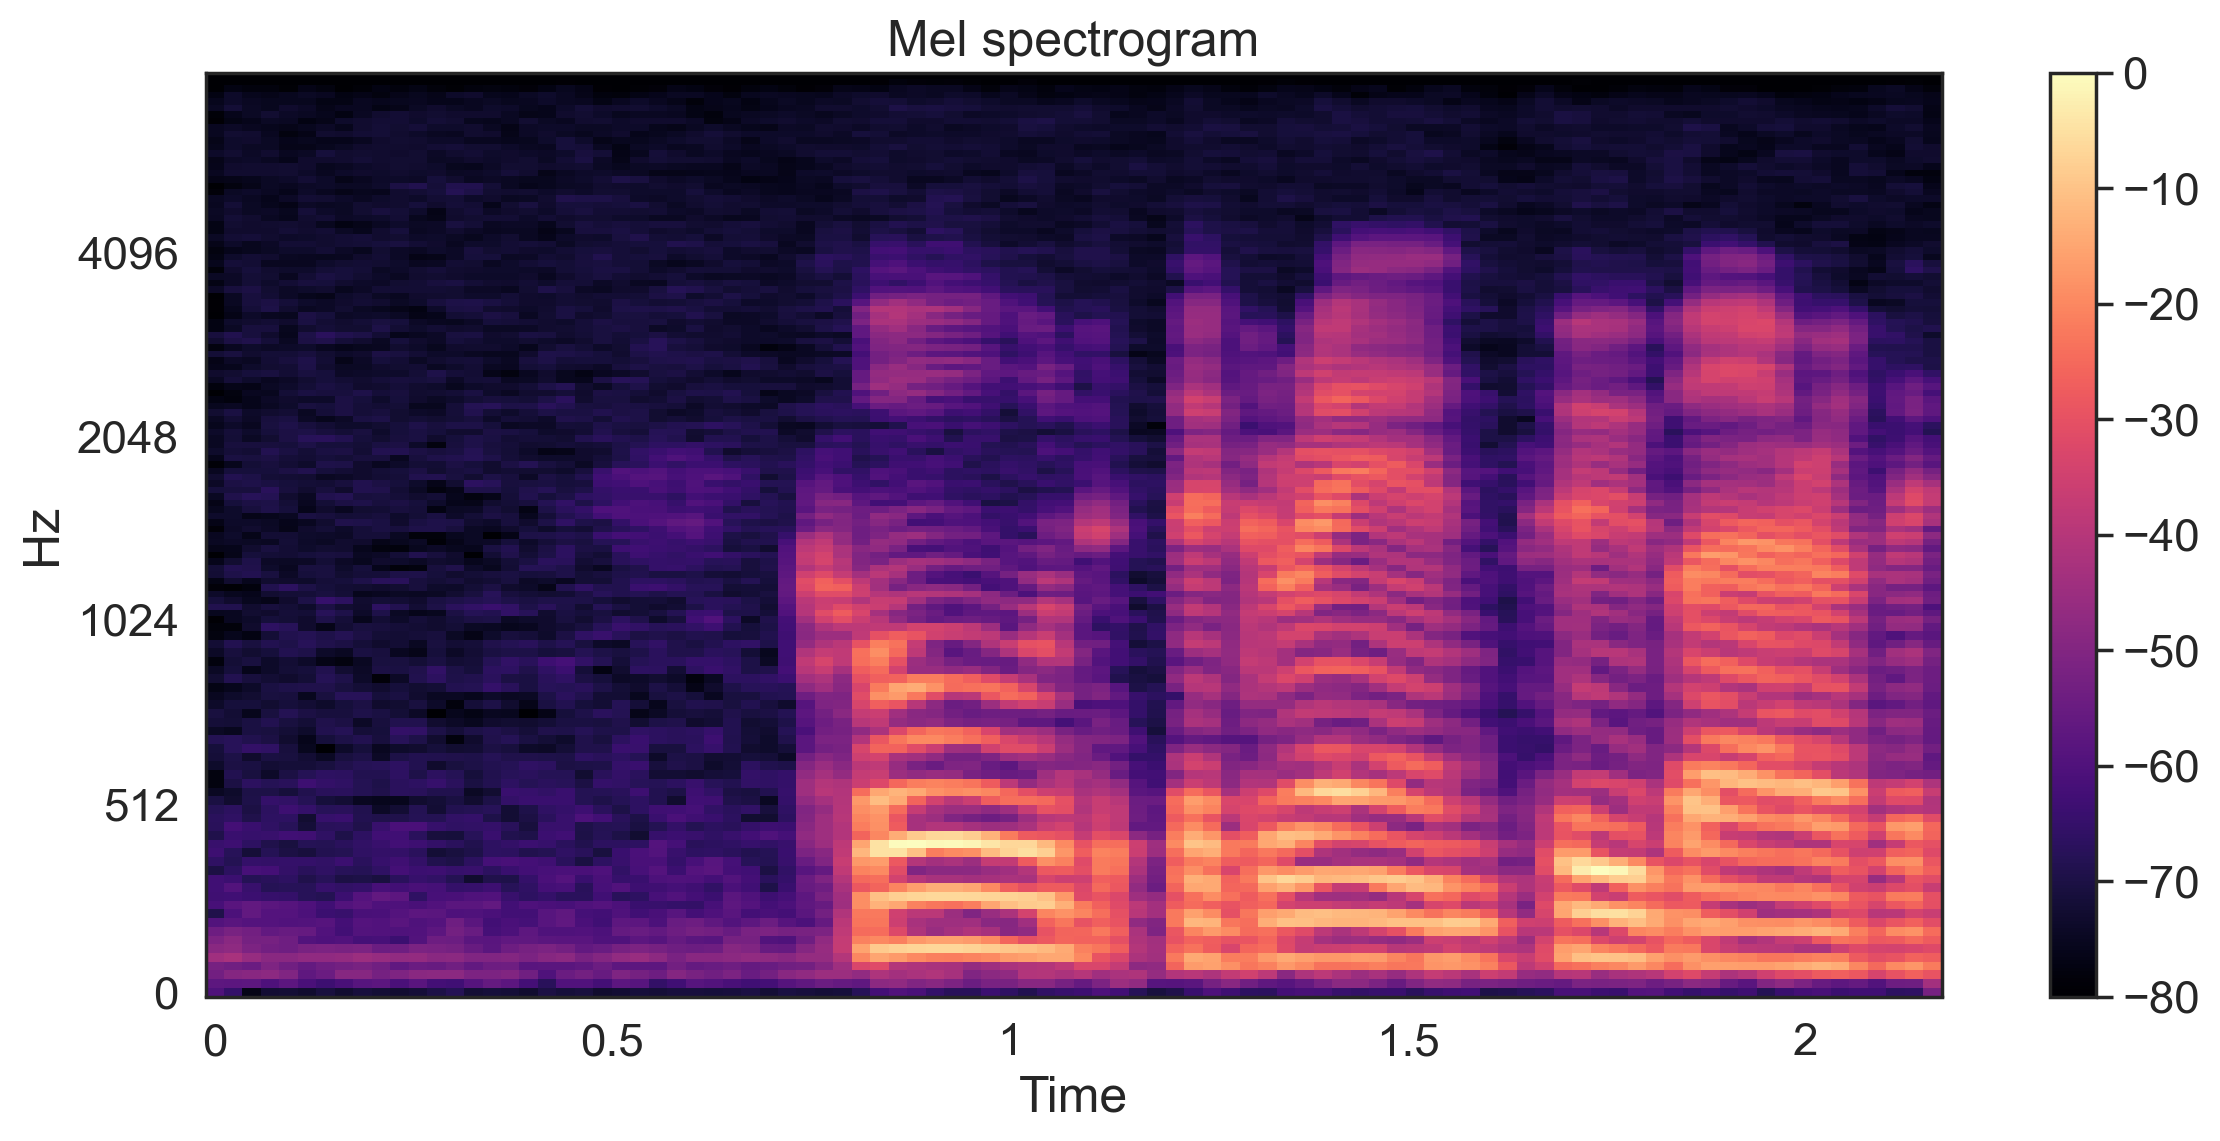

In [26]:
fig, ax = plt.subplots(nrows=1, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Mel spectrogram')
ax.label_outer()

In [27]:
print(len(features))

3568


In [28]:
# features

In [29]:
len(features['HeStutters_0_17'])

25

In [30]:
features['HeStutters_0_17']

array([-383.2359    ,   49.98627   ,    2.6920345 ,   14.354122  ,
          1.7774231 ,   -2.420322  ,  -12.342792  ,    1.0719689 ,
         -9.256073  ,   -6.607179  ,   -0.8089441 ,   -9.527816  ,
         -5.3648534 ,    0.41822615,   -7.9990735 ,   -2.9743023 ,
         -2.9893045 ,   -4.9839716 ,   -3.6998084 ,   -4.046079  ,
         -2.8578598 ,   -2.3207417 ,   -4.8005357 ,   -0.45565036,
         -4.7950087 ], dtype=float32)

# Making Dataset for machine learning

In [31]:
df_features = pd.DataFrame.from_dict(features)
df_features = df_features.transpose()
df_features

0           1          2          3          4   \
HeStutters_0_17 -383.235901   49.986271   2.692034  14.354122   1.777423   
HeStutters_0_18 -360.241272   66.061165  -1.453862  11.259468  -4.462043   
HeStutters_0_19 -293.655060   73.833069   1.900997  -2.408337  -4.000989   
HeStutters_0_20 -300.604645   52.587803  -1.105800  22.788185  -2.626716   
HeStutters_0_26 -322.675629   39.411556 -26.036314  31.284819 -20.774286   
...                     ...         ...        ...        ...        ...   
HeStutters_9_5  -391.987976   95.752922   9.024719  17.677141   3.198455   
HeStutters_9_6  -344.726135  116.403374   7.805432   7.620486   0.551768   
HeStutters_9_7  -319.141266  103.112801 -20.001846  23.953331  12.567533   
HeStutters_9_8  -327.219696  115.908722   3.807897  18.874868  -1.051909   
HeStutters_9_9  -321.221893  117.037651  -9.340935  23.441261   9.100965   

                        5          6          7          8          9   ...  \
HeStutters_0_17  -2.420322 -12.342792   1.071969  -9.256073  -6.607179  ...   
HeStutters_0_18  -0.253932  -5.415998  -6.300482  -7.769227  -6.499992  ...   
HeStutters_0_19   1.076604  -3.904765  -3.917793  -7.314900  -5.230086  ...   
HeStutters_0_20  -5.491357 -18.113766   0.016458 -17.751234 -10.870637  ...   
HeStutters_0_26  -5.054771  -8.849819  -4.670222  -6.783212  -8.442829  ...   
...                    ...        ...        ...        ...        ...  ...   
HeStutters_9_5    6.799196   1.697369  -0.451444  -7.535056  -2.101407  ...   
HeStutters_9_6   14.451855   0.352676 -11.088440 -14.743527  -2.621413  ...   
HeStutters_9_7   13.035041  -6.703744 -14.737140  -3.802872   1.641081  ...   
HeStutters_9_8    8.036952   3.818347  -4.941028 -10.341395  -3.503882  ...   
HeStutters_9_9    4.745224  -3.168241 -17.579376 -12.762151  -1.206492  ...   

                       15        16        17         18        19        20  \
HeStutters_0_17 -2.974302 -2.989305 -4.983972  -3.699808 -4.046079 -2.857860   
HeStutters_0_18 -3.634912 -4.971791 -1.833332  -7.710993  0.069483 -4.507726   
HeStutters_0_19 -6.861574 -1.248088 -3.337165  -5.428972 -1.424426 -4.697278   
HeStutters_0_20 -0.783750 -3.680684 -5.622582  -3.175051 -4.490634 -5.083001   
HeStutters_0_26 -6.857039 -0.264843 -2.226961  -4.033388  0.035163 -1.974014   
...                   ...       ...       ...        ...       ...       ...   
HeStutters_9_5  -3.116587 -8.633576 -4.010638  -7.458389 -4.468021 -6.837661   
HeStutters_9_6  -5.166616 -8.410511 -6.057311 -15.159676 -7.000687 -2.858663   
HeStutters_9_7  -5.168277 -8.459966 -7.567927 -12.495276 -2.435664 -1.211125   
HeStutters_9_8  -9.777304 -3.849983 -8.141125  -9.514221  0.365736 -9.465459   
HeStutters_9_9  -5.575107 -9.423483 -5.749158 -11.183662 -6.101176 -3.818814   

                       21        22        23         24  
HeStutters_0_17 -2.320742 -4.800536 -0.455650  -4.795009  
HeStutters_0_18 -2.640417 -2.963753 -3.574957  -3.732831  
HeStutters_0_19 -2.103874 -4.534689 -3.809132  -6.457784  
HeStutters_0_20 -4.942744 -4.551748 -3.709264  -8.050510  
HeStutters_0_26 -1.359453 -2.427017 -3.169117  -3.252512  
...                   ...       ...       ...        ...  
HeStutters_9_5   0.029483 -6.559899  0.752731  -7.293784  
HeStutters_9_6  -4.129618 -7.010985  0.323739 -10.707086  
HeStutters_9_7  -5.217443 -3.995463 -0.141155 -12.702785  
HeStutters_9_8  -2.269494 -5.703311 -3.104552  -6.851419  
HeStutters_9_9  -4.598830 -6.199409 -1.563006 -11.009380  

[3568 rows x 25 columns]

In [32]:
df_features.shape

(3568, 25)

In [33]:
df_features = df_features.reset_index()

In [34]:
df_features

index           0           1          2          3  \
0     HeStutters_0_17 -383.235901   49.986271   2.692034  14.354122   
1     HeStutters_0_18 -360.241272   66.061165  -1.453862  11.259468   
2     HeStutters_0_19 -293.655060   73.833069   1.900997  -2.408337   
3     HeStutters_0_20 -300.604645   52.587803  -1.105800  22.788185   
4     HeStutters_0_26 -322.675629   39.411556 -26.036314  31.284819   
...               ...         ...         ...        ...        ...   
3563   HeStutters_9_5 -391.987976   95.752922   9.024719  17.677141   
3564   HeStutters_9_6 -344.726135  116.403374   7.805432   7.620486   
3565   HeStutters_9_7 -319.141266  103.112801 -20.001846  23.953331   
3566   HeStutters_9_8 -327.219696  115.908722   3.807897  18.874868   
3567   HeStutters_9_9 -321.221893  117.037651  -9.340935  23.441261   

              4          5          6          7          8  ...        15  \
0      1.777423  -2.420322 -12.342792   1.071969  -9.256073  ... -2.974302   
1     -4.462043  -0.253932  -5.415998  -6.300482  -7.769227  ... -3.634912   
2     -4.000989   1.076604  -3.904765  -3.917793  -7.314900  ... -6.861574   
3     -2.626716  -5.491357 -18.113766   0.016458 -17.751234  ... -0.783750   
4    -20.774286  -5.054771  -8.849819  -4.670222  -6.783212  ... -6.857039   
...         ...        ...        ...        ...        ...  ...       ...   
3563   3.198455   6.799196   1.697369  -0.451444  -7.535056  ... -3.116587   
3564   0.551768  14.451855   0.352676 -11.088440 -14.743527  ... -5.166616   
3565  12.567533  13.035041  -6.703744 -14.737140  -3.802872  ... -5.168277   
3566  -1.051909   8.036952   3.818347  -4.941028 -10.341395  ... -9.777304   
3567   9.100965   4.745224  -3.168241 -17.579376 -12.762151  ... -5.575107   

            16        17         18        19        20        21        22  \
0    -2.989305 -4.983972  -3.699808 -4.046079 -2.857860 -2.320742 -4.800536   
1    -4.971791 -1.833332  -7.710993  0.069483 -4.507726 -2.640417 -2.963753   
2    -1.248088 -3.337165  -5.428972 -1.424426 -4.697278 -2.103874 -4.534689   
3    -3.680684 -5.622582  -3.175051 -4.490634 -5.083001 -4.942744 -4.551748   
4    -0.264843 -2.226961  -4.033388  0.035163 -1.974014 -1.359453 -2.427017   
...        ...       ...        ...       ...       ...       ...       ...   
3563 -8.633576 -4.010638  -7.458389 -4.468021 -6.837661  0.029483 -6.559899   
3564 -8.410511 -6.057311 -15.159676 -7.000687 -2.858663 -4.129618 -7.010985   
3565 -8.459966 -7.567927 -12.495276 -2.435664 -1.211125 -5.217443 -3.995463   
3566 -3.849983 -8.141125  -9.514221  0.365736 -9.465459 -2.269494 -5.703311   
3567 -9.423483 -5.749158 -11.183662 -6.101176 -3.818814 -4.598830 -6.199409   

            23         24  
0    -0.455650  -4.795009  
1    -3.574957  -3.732831  
2    -3.809132  -6.457784  
3    -3.709264  -8.050510  
4    -3.169117  -3.252512  
...        ...        ...  
3563  0.752731  -7.293784  
3564  0.323739 -10.707086  
3565 -0.141155 -12.702785  
3566 -3.104552  -6.851419  
3567 -1.563006 -11.009380  

[3568 rows x 26 columns]

In [35]:
df_features = df_features.sort_values(by='index')

In [36]:
df_features

index           0           1          2          3  \
0     HeStutters_0_17 -383.235901   49.986271   2.692034  14.354122   
1     HeStutters_0_18 -360.241272   66.061165  -1.453862  11.259468   
2     HeStutters_0_19 -293.655060   73.833069   1.900997  -2.408337   
3     HeStutters_0_20 -300.604645   52.587803  -1.105800  22.788185   
4     HeStutters_0_26 -322.675629   39.411556 -26.036314  31.284819   
...               ...         ...         ...        ...        ...   
3563   HeStutters_9_5 -391.987976   95.752922   9.024719  17.677141   
3564   HeStutters_9_6 -344.726135  116.403374   7.805432   7.620486   
3565   HeStutters_9_7 -319.141266  103.112801 -20.001846  23.953331   
3566   HeStutters_9_8 -327.219696  115.908722   3.807897  18.874868   
3567   HeStutters_9_9 -321.221893  117.037651  -9.340935  23.441261   

              4          5          6          7          8  ...        15  \
0      1.777423  -2.420322 -12.342792   1.071969  -9.256073  ... -2.974302   
1     -4.462043  -0.253932  -5.415998  -6.300482  -7.769227  ... -3.634912   
2     -4.000989   1.076604  -3.904765  -3.917793  -7.314900  ... -6.861574   
3     -2.626716  -5.491357 -18.113766   0.016458 -17.751234  ... -0.783750   
4    -20.774286  -5.054771  -8.849819  -4.670222  -6.783212  ... -6.857039   
...         ...        ...        ...        ...        ...  ...       ...   
3563   3.198455   6.799196   1.697369  -0.451444  -7.535056  ... -3.116587   
3564   0.551768  14.451855   0.352676 -11.088440 -14.743527  ... -5.166616   
3565  12.567533  13.035041  -6.703744 -14.737140  -3.802872  ... -5.168277   
3566  -1.051909   8.036952   3.818347  -4.941028 -10.341395  ... -9.777304   
3567   9.100965   4.745224  -3.168241 -17.579376 -12.762151  ... -5.575107   

            16        17         18        19        20        21        22  \
0    -2.989305 -4.983972  -3.699808 -4.046079 -2.857860 -2.320742 -4.800536   
1    -4.971791 -1.833332  -7.710993  0.069483 -4.507726 -2.640417 -2.963753   
2    -1.248088 -3.337165  -5.428972 -1.424426 -4.697278 -2.103874 -4.534689   
3    -3.680684 -5.622582  -3.175051 -4.490634 -5.083001 -4.942744 -4.551748   
4    -0.264843 -2.226961  -4.033388  0.035163 -1.974014 -1.359453 -2.427017   
...        ...       ...        ...       ...       ...       ...       ...   
3563 -8.633576 -4.010638  -7.458389 -4.468021 -6.837661  0.029483 -6.559899   
3564 -8.410511 -6.057311 -15.159676 -7.000687 -2.858663 -4.129618 -7.010985   
3565 -8.459966 -7.567927 -12.495276 -2.435664 -1.211125 -5.217443 -3.995463   
3566 -3.849983 -8.141125  -9.514221  0.365736 -9.465459 -2.269494 -5.703311   
3567 -9.423483 -5.749158 -11.183662 -6.101176 -3.818814 -4.598830 -6.199409   

            23         24  
0    -0.455650  -4.795009  
1    -3.574957  -3.732831  
2    -3.809132  -6.457784  
3    -3.709264  -8.050510  
4    -3.169117  -3.252512  
...        ...        ...  
3563  0.752731  -7.293784  
3564  0.323739 -10.707086  
3565 -0.141155 -12.702785  
3566 -3.104552  -6.851419  
3567 -1.563006 -11.009380  

[3568 rows x 26 columns]

In [37]:
df_features['index']

0       HeStutters_0_17
1       HeStutters_0_18
2       HeStutters_0_19
3       HeStutters_0_20
4       HeStutters_0_26
             ...       
3563     HeStutters_9_5
3564     HeStutters_9_6
3565     HeStutters_9_7
3566     HeStutters_9_8
3567     HeStutters_9_9
Name: index, Length: 3568, dtype: object

In [38]:
df = df.sort_values(by='Name')

In [39]:
df.head()

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
17  HeStutters     0      17   6970880   7018880       0                 0   
18  HeStutters     0      18   8215200   8263200       0                 0   
19  HeStutters     0      19   9985280  10033280       0                 0   
20  HeStutters     0      20  11197600  11245600       0                 0   
26  HeStutters     0      26   3562240   3610240       0                 0   

    Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
17             0      0         0        0                      0   
18             0      1         0        0                      0   
19             1      0         0        0                      0   
20             0      0         0        0                      0   
26             0      0         0        0                      0   

    Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
17             0                 3             1      0         0   
18             0                 2             1      0         0   
19             0                 2             0      0         0   
20             0                 3             0      0         0   
26             0                 3             0      0         0   

               Name  
17  HeStutters_0_17  
18  HeStutters_0_18  
19  HeStutters_0_19  
20  HeStutters_0_20  
26  HeStutters_0_26

In [40]:
df['Name']

17      HeStutters_0_17
18      HeStutters_0_18
19      HeStutters_0_19
20      HeStutters_0_20
26      HeStutters_0_26
             ...       
1349     HeStutters_9_5
1350     HeStutters_9_6
1351     HeStutters_9_7
1352     HeStutters_9_8
1353     HeStutters_9_9
Name: Name, Length: 3568, dtype: object

In [41]:
df_features.rename(columns = {'index':'Name'}, inplace = True)
df_features

Name           0           1          2          3  \
0     HeStutters_0_17 -383.235901   49.986271   2.692034  14.354122   
1     HeStutters_0_18 -360.241272   66.061165  -1.453862  11.259468   
2     HeStutters_0_19 -293.655060   73.833069   1.900997  -2.408337   
3     HeStutters_0_20 -300.604645   52.587803  -1.105800  22.788185   
4     HeStutters_0_26 -322.675629   39.411556 -26.036314  31.284819   
...               ...         ...         ...        ...        ...   
3563   HeStutters_9_5 -391.987976   95.752922   9.024719  17.677141   
3564   HeStutters_9_6 -344.726135  116.403374   7.805432   7.620486   
3565   HeStutters_9_7 -319.141266  103.112801 -20.001846  23.953331   
3566   HeStutters_9_8 -327.219696  115.908722   3.807897  18.874868   
3567   HeStutters_9_9 -321.221893  117.037651  -9.340935  23.441261   

              4          5          6          7          8  ...        15  \
0      1.777423  -2.420322 -12.342792   1.071969  -9.256073  ... -2.974302   
1     -4.462043  -0.253932  -5.415998  -6.300482  -7.769227  ... -3.634912   
2     -4.000989   1.076604  -3.904765  -3.917793  -7.314900  ... -6.861574   
3     -2.626716  -5.491357 -18.113766   0.016458 -17.751234  ... -0.783750   
4    -20.774286  -5.054771  -8.849819  -4.670222  -6.783212  ... -6.857039   
...         ...        ...        ...        ...        ...  ...       ...   
3563   3.198455   6.799196   1.697369  -0.451444  -7.535056  ... -3.116587   
3564   0.551768  14.451855   0.352676 -11.088440 -14.743527  ... -5.166616   
3565  12.567533  13.035041  -6.703744 -14.737140  -3.802872  ... -5.168277   
3566  -1.051909   8.036952   3.818347  -4.941028 -10.341395  ... -9.777304   
3567   9.100965   4.745224  -3.168241 -17.579376 -12.762151  ... -5.575107   

            16        17         18        19        20        21        22  \
0    -2.989305 -4.983972  -3.699808 -4.046079 -2.857860 -2.320742 -4.800536   
1    -4.971791 -1.833332  -7.710993  0.069483 -4.507726 -2.640417 -2.963753   
2    -1.248088 -3.337165  -5.428972 -1.424426 -4.697278 -2.103874 -4.534689   
3    -3.680684 -5.622582  -3.175051 -4.490634 -5.083001 -4.942744 -4.551748   
4    -0.264843 -2.226961  -4.033388  0.035163 -1.974014 -1.359453 -2.427017   
...        ...       ...        ...       ...       ...       ...       ...   
3563 -8.633576 -4.010638  -7.458389 -4.468021 -6.837661  0.029483 -6.559899   
3564 -8.410511 -6.057311 -15.159676 -7.000687 -2.858663 -4.129618 -7.010985   
3565 -8.459966 -7.567927 -12.495276 -2.435664 -1.211125 -5.217443 -3.995463   
3566 -3.849983 -8.141125  -9.514221  0.365736 -9.465459 -2.269494 -5.703311   
3567 -9.423483 -5.749158 -11.183662 -6.101176 -3.818814 -4.598830 -6.199409   

            23         24  
0    -0.455650  -4.795009  
1    -3.574957  -3.732831  
2    -3.809132  -6.457784  
3    -3.709264  -8.050510  
4    -3.169117  -3.252512  
...        ...        ...  
3563  0.752731  -7.293784  
3564  0.323739 -10.707086  
3565 -0.141155 -12.702785  
3566 -3.104552  -6.851419  
3567 -1.563006 -11.009380  

[3568 rows x 26 columns]

## appending all features and labels together

In [42]:

df_final = pd.merge(df, df_features, how='inner', on='Name')


In [43]:
df_final

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0     HeStutters     0      17   6970880   7018880       0                 0   
1     HeStutters     0      18   8215200   8263200       0                 0   
2     HeStutters     0      19   9985280  10033280       0                 0   
3     HeStutters     0      20  11197600  11245600       0                 0   
4     HeStutters     0      26   3562240   3610240       0                 0   
...          ...   ...     ...       ...       ...     ...               ...   
3563  HeStutters     9       5  29196800  29244800       0                 0   
3564  HeStutters     9       6  30779840  30827840       0                 0   
3565  HeStutters     9       7  30866560  30914560       0                 0   
3566  HeStutters     9       8  31254720  31302720       0                 0   
3567  HeStutters     9       9  31458400  31506400       0                 0   

      Prolongation  Block  SoundRep  ...        15        16        17  \
0                0      0         0  ... -2.974302 -2.989305 -4.983972   
1                0      1         0  ... -3.634912 -4.971791 -1.833332   
2                1      0         0  ... -6.861574 -1.248088 -3.337165   
3                0      0         0  ... -0.783750 -3.680684 -5.622582   
4                0      0         0  ... -6.857039 -0.264843 -2.226961   
...            ...    ...       ...  ...       ...       ...       ...   
3563             0      0         0  ... -3.116587 -8.633576 -4.010638   
3564             0      1         0  ... -5.166616 -8.410511 -6.057311   
3565             0      0         0  ... -5.168277 -8.459966 -7.567927   
3566             2      0         0  ... -9.777304 -3.849983 -8.141125   
3567             0      0         0  ... -5.575107 -9.423483 -5.749158   

             18        19        20        21        22        23         24  
0     -3.699808 -4.046079 -2.857860 -2.320742 -4.800536 -0.455650  -4.795009  
1     -7.710993  0.069483 -4.507726 -2.640417 -2.963753 -3.574957  -3.732831  
2     -5.428972 -1.424426 -4.697278 -2.103874 -4.534689 -3.809132  -6.457784  
3     -3.175051 -4.490634 -5.083001 -4.942744 -4.551748 -3.709264  -8.050510  
4     -4.033388  0.035163 -1.974014 -1.359453 -2.427017 -3.169117  -3.252512  
...         ...       ...       ...       ...       ...       ...        ...  
3563  -7.458389 -4.468021 -6.837661  0.029483 -6.559899  0.752731  -7.293784  
3564 -15.159676 -7.000687 -2.858663 -4.129618 -7.010985  0.323739 -10.707086  
3565 -12.495276 -2.435664 -1.211125 -5.217443 -3.995463 -0.141155 -12.702785  
3566  -9.514221  0.365736 -9.465459 -2.269494 -5.703311 -3.104552  -6.851419  
3567 -11.183662 -6.101176 -3.818814 -4.598830 -6.199409 -1.563006 -11.009380  

[3568 rows x 43 columns]

In [44]:
df_final.columns

Index([                 'Show',                  'EpId',
                      'ClipId',                 'Start',
                        'Stop',                'Unsure',
            'PoorAudioQuality',          'Prolongation',
                       'Block',              'SoundRep',
                     'WordRep', 'DifficultToUnderstand',
                'Interjection',      'NoStutteredWords',
                'NaturalPause',                 'Music',
                    'NoSpeech',                  'Name',
                             0,                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12,                      13,
                            14,                      15,
                            16,

In [45]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3568 entries, 0 to 3567
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Show                   3568 non-null   object 
 1   EpId                   3568 non-null   int64  
 2   ClipId                 3568 non-null   int64  
 3   Start                  3568 non-null   int64  
 4   Stop                   3568 non-null   int64  
 5   Unsure                 3568 non-null   int64  
 6   PoorAudioQuality       3568 non-null   int64  
 7   Prolongation           3568 non-null   int64  
 8   Block                  3568 non-null   int64  
 9   SoundRep               3568 non-null   int64  
 10  WordRep                3568 non-null   int64  
 11  DifficultToUnderstand  3568 non-null   int64  
 12  Interjection           3568 non-null   int64  
 13  NoStutteredWords       3568 non-null   int64  
 14  NaturalPause           3568 non-null   int64  
 15  Musi

# Final preprocessing

In [46]:
df_final['Stutter'] = df_final['WordRep'] + df_final['SoundRep'] + df_final['Prolongation'] + df_final['Interjection'] + df_final['Block']
df_final

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0     HeStutters     0      17   6970880   7018880       0                 0   
1     HeStutters     0      18   8215200   8263200       0                 0   
2     HeStutters     0      19   9985280  10033280       0                 0   
3     HeStutters     0      20  11197600  11245600       0                 0   
4     HeStutters     0      26   3562240   3610240       0                 0   
...          ...   ...     ...       ...       ...     ...               ...   
3563  HeStutters     9       5  29196800  29244800       0                 0   
3564  HeStutters     9       6  30779840  30827840       0                 0   
3565  HeStutters     9       7  30866560  30914560       0                 0   
3566  HeStutters     9       8  31254720  31302720       0                 0   
3567  HeStutters     9       9  31458400  31506400       0                 0   

      Prolongation  Block  SoundRep  ...        16        17         18  \
0                0      0         0  ... -2.989305 -4.983972  -3.699808   
1                0      1         0  ... -4.971791 -1.833332  -7.710993   
2                1      0         0  ... -1.248088 -3.337165  -5.428972   
3                0      0         0  ... -3.680684 -5.622582  -3.175051   
4                0      0         0  ... -0.264843 -2.226961  -4.033388   
...            ...    ...       ...  ...       ...       ...        ...   
3563             0      0         0  ... -8.633576 -4.010638  -7.458389   
3564             0      1         0  ... -8.410511 -6.057311 -15.159676   
3565             0      0         0  ... -8.459966 -7.567927 -12.495276   
3566             2      0         0  ... -3.849983 -8.141125  -9.514221   
3567             0      0         0  ... -9.423483 -5.749158 -11.183662   

            19        20        21        22        23         24  Stutter  
0    -4.046079 -2.857860 -2.320742 -4.800536 -0.455650  -4.795009        0  
1     0.069483 -4.507726 -2.640417 -2.963753 -3.574957  -3.732831        1  
2    -1.424426 -4.697278 -2.103874 -4.534689 -3.809132  -6.457784        1  
3    -4.490634 -5.083001 -4.942744 -4.551748 -3.709264  -8.050510        0  
4     0.035163 -1.974014 -1.359453 -2.427017 -3.169117  -3.252512        0  
...        ...       ...       ...       ...       ...        ...      ...  
3563 -4.468021 -6.837661  0.029483 -6.559899  0.752731  -7.293784        1  
3564 -7.000687 -2.858663 -4.129618 -7.010985  0.323739 -10.707086        1  
3565 -2.435664 -1.211125 -5.217443 -3.995463 -0.141155 -12.702785        0  
3566  0.365736 -9.465459 -2.269494 -5.703311 -3.104552  -6.851419        5  
3567 -6.101176 -3.818814 -4.598830 -6.199409 -1.563006 -11.009380        0  

[3568 rows x 44 columns]

In [47]:
df_final['Stutter'].value_counts()

3     678
4     579
1     545
2     544
0     526
5     366
6     214
7      79
8      28
9       7
10      1
11      1
Name: Stutter, dtype: int64

In [48]:
df_final.loc[df_final['Stutter'] >= 1.0, 'Stutter'] = 1.0
df_final['Stutter'].value_counts()

1    3042
0     526
Name: Stutter, dtype: int64

In [49]:
trace0 = go.Bar(
    x = [ 'disfluency', 'no disfluency'],
    y = df_final['Stutter'].value_counts().values
    )

trace1 = go.Pie(
    labels = [ 'disfluency', 'no disfluency'],
    values = df_final['Stutter'].value_counts().values,
    domain = {'x':[0.55,1]})

data = [trace0, trace1]
layout = go.Layout(
    title = 'Frequency Distribution for Stutter data',
    xaxis = dict(domain = [0,.50]))

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [50]:
df_final = df_final[(df_final.PoorAudioQuality == 0) & (df_final.DifficultToUnderstand == 0) & (df_final.NoSpeech == 0)]
df_final #ensuring that the audio generated features work tyhe best. that's why we are removing any discrepent datapoints.

Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0     HeStutters     0      17   6970880   7018880       0                 0   
1     HeStutters     0      18   8215200   8263200       0                 0   
2     HeStutters     0      19   9985280  10033280       0                 0   
3     HeStutters     0      20  11197600  11245600       0                 0   
4     HeStutters     0      26   3562240   3610240       0                 0   
...          ...   ...     ...       ...       ...     ...               ...   
3563  HeStutters     9       5  29196800  29244800       0                 0   
3564  HeStutters     9       6  30779840  30827840       0                 0   
3565  HeStutters     9       7  30866560  30914560       0                 0   
3566  HeStutters     9       8  31254720  31302720       0                 0   
3567  HeStutters     9       9  31458400  31506400       0                 0   

      Prolongation  Block  SoundRep  ...        16        17         18  \
0                0      0         0  ... -2.989305 -4.983972  -3.699808   
1                0      1         0  ... -4.971791 -1.833332  -7.710993   
2                1      0         0  ... -1.248088 -3.337165  -5.428972   
3                0      0         0  ... -3.680684 -5.622582  -3.175051   
4                0      0         0  ... -0.264843 -2.226961  -4.033388   
...            ...    ...       ...  ...       ...       ...        ...   
3563             0      0         0  ... -8.633576 -4.010638  -7.458389   
3564             0      1         0  ... -8.410511 -6.057311 -15.159676   
3565             0      0         0  ... -8.459966 -7.567927 -12.495276   
3566             2      0         0  ... -3.849983 -8.141125  -9.514221   
3567             0      0         0  ... -9.423483 -5.749158 -11.183662   

            19        20        21        22        23         24  Stutter  
0    -4.046079 -2.857860 -2.320742 -4.800536 -0.455650  -4.795009        0  
1     0.069483 -4.507726 -2.640417 -2.963753 -3.574957  -3.732831        1  
2    -1.424426 -4.697278 -2.103874 -4.534689 -3.809132  -6.457784        1  
3    -4.490634 -5.083001 -4.942744 -4.551748 -3.709264  -8.050510        0  
4     0.035163 -1.974014 -1.359453 -2.427017 -3.169117  -3.252512        0  
...        ...       ...       ...       ...       ...        ...      ...  
3563 -4.468021 -6.837661  0.029483 -6.559899  0.752731  -7.293784        1  
3564 -7.000687 -2.858663 -4.129618 -7.010985  0.323739 -10.707086        1  
3565 -2.435664 -1.211125 -5.217443 -3.995463 -0.141155 -12.702785        0  
3566  0.365736 -9.465459 -2.269494 -5.703311 -3.104552  -6.851419        1  
3567 -6.101176 -3.818814 -4.598830 -6.199409 -1.563006 -11.009380        0  

[2451 rows x 44 columns]

In [51]:
x = df_final.iloc[: , -26:-1]
x

0           1          2          3          4          5   \
0    -383.235901   49.986271   2.692034  14.354122   1.777423  -2.420322   
1    -360.241272   66.061165  -1.453862  11.259468  -4.462043  -0.253932   
2    -293.655060   73.833069   1.900997  -2.408337  -4.000989   1.076604   
3    -300.604645   52.587803  -1.105800  22.788185  -2.626716  -5.491357   
4    -322.675629   39.411556 -26.036314  31.284819 -20.774286  -5.054771   
...          ...         ...        ...        ...        ...        ...   
3563 -391.987976   95.752922   9.024719  17.677141   3.198455   6.799196   
3564 -344.726135  116.403374   7.805432   7.620486   0.551768  14.451855   
3565 -319.141266  103.112801 -20.001846  23.953331  12.567533  13.035041   
3566 -327.219696  115.908722   3.807897  18.874868  -1.051909   8.036952   
3567 -321.221893  117.037651  -9.340935  23.441261   9.100965   4.745224   

             6          7          8          9   ...        15        16  \
0    -12.342792   1.071969  -9.256073  -6.607179  ... -2.974302 -2.989305   
1     -5.415998  -6.300482  -7.769227  -6.499992  ... -3.634912 -4.971791   
2     -3.904765  -3.917793  -7.314900  -5.230086  ... -6.861574 -1.248088   
3    -18.113766   0.016458 -17.751234 -10.870637  ... -0.783750 -3.680684   
4     -8.849819  -4.670222  -6.783212  -8.442829  ... -6.857039 -0.264843   
...         ...        ...        ...        ...  ...       ...       ...   
3563   1.697369  -0.451444  -7.535056  -2.101407  ... -3.116587 -8.633576   
3564   0.352676 -11.088440 -14.743527  -2.621413  ... -5.166616 -8.410511   
3565  -6.703744 -14.737140  -3.802872   1.641081  ... -5.168277 -8.459966   
3566   3.818347  -4.941028 -10.341395  -3.503882  ... -9.777304 -3.849983   
3567  -3.168241 -17.579376 -12.762151  -1.206492  ... -5.575107 -9.423483   

            17         18        19        20        21        22        23  \
0    -4.983972  -3.699808 -4.046079 -2.857860 -2.320742 -4.800536 -0.455650   
1    -1.833332  -7.710993  0.069483 -4.507726 -2.640417 -2.963753 -3.574957   
2    -3.337165  -5.428972 -1.424426 -4.697278 -2.103874 -4.534689 -3.809132   
3    -5.622582  -3.175051 -4.490634 -5.083001 -4.942744 -4.551748 -3.709264   
4    -2.226961  -4.033388  0.035163 -1.974014 -1.359453 -2.427017 -3.169117   
...        ...        ...       ...       ...       ...       ...       ...   
3563 -4.010638  -7.458389 -4.468021 -6.837661  0.029483 -6.559899  0.752731   
3564 -6.057311 -15.159676 -7.000687 -2.858663 -4.129618 -7.010985  0.323739   
3565 -7.567927 -12.495276 -2.435664 -1.211125 -5.217443 -3.995463 -0.141155   
3566 -8.141125  -9.514221  0.365736 -9.465459 -2.269494 -5.703311 -3.104552   
3567 -5.749158 -11.183662 -6.101176 -3.818814 -4.598830 -6.199409 -1.563006   

             24  
0     -4.795009  
1     -3.732831  
2     -6.457784  
3     -8.050510  
4     -3.252512  
...         ...  
3563  -7.293784  
3564 -10.707086  
3565 -12.702785  
3566  -6.851419  
3567 -11.009380  

[2451 rows x 25 columns]

In [52]:
x.columns=["Feature"+str(i) for i in range(1, 26)]

In [53]:
x

Feature1    Feature2   Feature3   Feature4   Feature5   Feature6  \
0    -383.235901   49.986271   2.692034  14.354122   1.777423  -2.420322   
1    -360.241272   66.061165  -1.453862  11.259468  -4.462043  -0.253932   
2    -293.655060   73.833069   1.900997  -2.408337  -4.000989   1.076604   
3    -300.604645   52.587803  -1.105800  22.788185  -2.626716  -5.491357   
4    -322.675629   39.411556 -26.036314  31.284819 -20.774286  -5.054771   
...          ...         ...        ...        ...        ...        ...   
3563 -391.987976   95.752922   9.024719  17.677141   3.198455   6.799196   
3564 -344.726135  116.403374   7.805432   7.620486   0.551768  14.451855   
3565 -319.141266  103.112801 -20.001846  23.953331  12.567533  13.035041   
3566 -327.219696  115.908722   3.807897  18.874868  -1.051909   8.036952   
3567 -321.221893  117.037651  -9.340935  23.441261   9.100965   4.745224   

       Feature7   Feature8   Feature9  Feature10  ...  Feature16  Feature17  \
0    -12.342792   1.071969  -9.256073  -6.607179  ...  -2.974302  -2.989305   
1     -5.415998  -6.300482  -7.769227  -6.499992  ...  -3.634912  -4.971791   
2     -3.904765  -3.917793  -7.314900  -5.230086  ...  -6.861574  -1.248088   
3    -18.113766   0.016458 -17.751234 -10.870637  ...  -0.783750  -3.680684   
4     -8.849819  -4.670222  -6.783212  -8.442829  ...  -6.857039  -0.264843   
...         ...        ...        ...        ...  ...        ...        ...   
3563   1.697369  -0.451444  -7.535056  -2.101407  ...  -3.116587  -8.633576   
3564   0.352676 -11.088440 -14.743527  -2.621413  ...  -5.166616  -8.410511   
3565  -6.703744 -14.737140  -3.802872   1.641081  ...  -5.168277  -8.459966   
3566   3.818347  -4.941028 -10.341395  -3.503882  ...  -9.777304  -3.849983   
3567  -3.168241 -17.579376 -12.762151  -1.206492  ...  -5.575107  -9.423483   

      Feature18  Feature19  Feature20  Feature21  Feature22  Feature23  \
0     -4.983972  -3.699808  -4.046079  -2.857860  -2.320742  -4.800536   
1     -1.833332  -7.710993   0.069483  -4.507726  -2.640417  -2.963753   
2     -3.337165  -5.428972  -1.424426  -4.697278  -2.103874  -4.534689   
3     -5.622582  -3.175051  -4.490634  -5.083001  -4.942744  -4.551748   
4     -2.226961  -4.033388   0.035163  -1.974014  -1.359453  -2.427017   
...         ...        ...        ...        ...        ...        ...   
3563  -4.010638  -7.458389  -4.468021  -6.837661   0.029483  -6.559899   
3564  -6.057311 -15.159676  -7.000687  -2.858663  -4.129618  -7.010985   
3565  -7.567927 -12.495276  -2.435664  -1.211125  -5.217443  -3.995463   
3566  -8.141125  -9.514221   0.365736  -9.465459  -2.269494  -5.703311   
3567  -5.749158 -11.183662  -6.101176  -3.818814  -4.598830  -6.199409   

      Feature24  Feature25  
0     -0.455650  -4.795009  
1     -3.574957  -3.732831  
2     -3.809132  -6.457784  
3     -3.709264  -8.050510  
4     -3.169117  -3.252512  
...         ...        ...  
3563   0.752731  -7.293784  
3564   0.323739 -10.707086  
3565  -0.141155 -12.702785  
3566  -3.104552  -6.851419  
3567  -1.563006 -11.009380  

[2451 rows x 25 columns]

In [54]:
y = df_final.iloc[: , -1:]
y 

Stutter
0           0
1           1
2           1
3           0
4           0
...       ...
3563        1
3564        1
3565        0
3566        1
3567        0

[2451 rows x 1 columns]

In [55]:
final_data = pd.concat([x, y], axis = 1)

In [56]:
final_data

Feature1    Feature2   Feature3   Feature4   Feature5   Feature6  \
0    -383.235901   49.986271   2.692034  14.354122   1.777423  -2.420322   
1    -360.241272   66.061165  -1.453862  11.259468  -4.462043  -0.253932   
2    -293.655060   73.833069   1.900997  -2.408337  -4.000989   1.076604   
3    -300.604645   52.587803  -1.105800  22.788185  -2.626716  -5.491357   
4    -322.675629   39.411556 -26.036314  31.284819 -20.774286  -5.054771   
...          ...         ...        ...        ...        ...        ...   
3563 -391.987976   95.752922   9.024719  17.677141   3.198455   6.799196   
3564 -344.726135  116.403374   7.805432   7.620486   0.551768  14.451855   
3565 -319.141266  103.112801 -20.001846  23.953331  12.567533  13.035041   
3566 -327.219696  115.908722   3.807897  18.874868  -1.051909   8.036952   
3567 -321.221893  117.037651  -9.340935  23.441261   9.100965   4.745224   

       Feature7   Feature8   Feature9  Feature10  ...  Feature17  Feature18  \
0    -12.342792   1.071969  -9.256073  -6.607179  ...  -2.989305  -4.983972   
1     -5.415998  -6.300482  -7.769227  -6.499992  ...  -4.971791  -1.833332   
2     -3.904765  -3.917793  -7.314900  -5.230086  ...  -1.248088  -3.337165   
3    -18.113766   0.016458 -17.751234 -10.870637  ...  -3.680684  -5.622582   
4     -8.849819  -4.670222  -6.783212  -8.442829  ...  -0.264843  -2.226961   
...         ...        ...        ...        ...  ...        ...        ...   
3563   1.697369  -0.451444  -7.535056  -2.101407  ...  -8.633576  -4.010638   
3564   0.352676 -11.088440 -14.743527  -2.621413  ...  -8.410511  -6.057311   
3565  -6.703744 -14.737140  -3.802872   1.641081  ...  -8.459966  -7.567927   
3566   3.818347  -4.941028 -10.341395  -3.503882  ...  -3.849983  -8.141125   
3567  -3.168241 -17.579376 -12.762151  -1.206492  ...  -9.423483  -5.749158   

      Feature19  Feature20  Feature21  Feature22  Feature23  Feature24  \
0     -3.699808  -4.046079  -2.857860  -2.320742  -4.800536  -0.455650   
1     -7.710993   0.069483  -4.507726  -2.640417  -2.963753  -3.574957   
2     -5.428972  -1.424426  -4.697278  -2.103874  -4.534689  -3.809132   
3     -3.175051  -4.490634  -5.083001  -4.942744  -4.551748  -3.709264   
4     -4.033388   0.035163  -1.974014  -1.359453  -2.427017  -3.169117   
...         ...        ...        ...        ...        ...        ...   
3563  -7.458389  -4.468021  -6.837661   0.029483  -6.559899   0.752731   
3564 -15.159676  -7.000687  -2.858663  -4.129618  -7.010985   0.323739   
3565 -12.495276  -2.435664  -1.211125  -5.217443  -3.995463  -0.141155   
3566  -9.514221   0.365736  -9.465459  -2.269494  -5.703311  -3.104552   
3567 -11.183662  -6.101176  -3.818814  -4.598830  -6.199409  -1.563006   

      Feature25  Stutter  
0     -4.795009        0  
1     -3.732831        1  
2     -6.457784        1  
3     -8.050510        0  
4     -3.252512        0  
...         ...      ...  
3563  -7.293784        1  
3564 -10.707086        1  
3565 -12.702785        0  
3566  -6.851419        1  
3567 -11.009380        0  

[2451 rows x 26 columns]

# EDA

In [57]:
targets = (final_data.Stutter.value_counts()).index

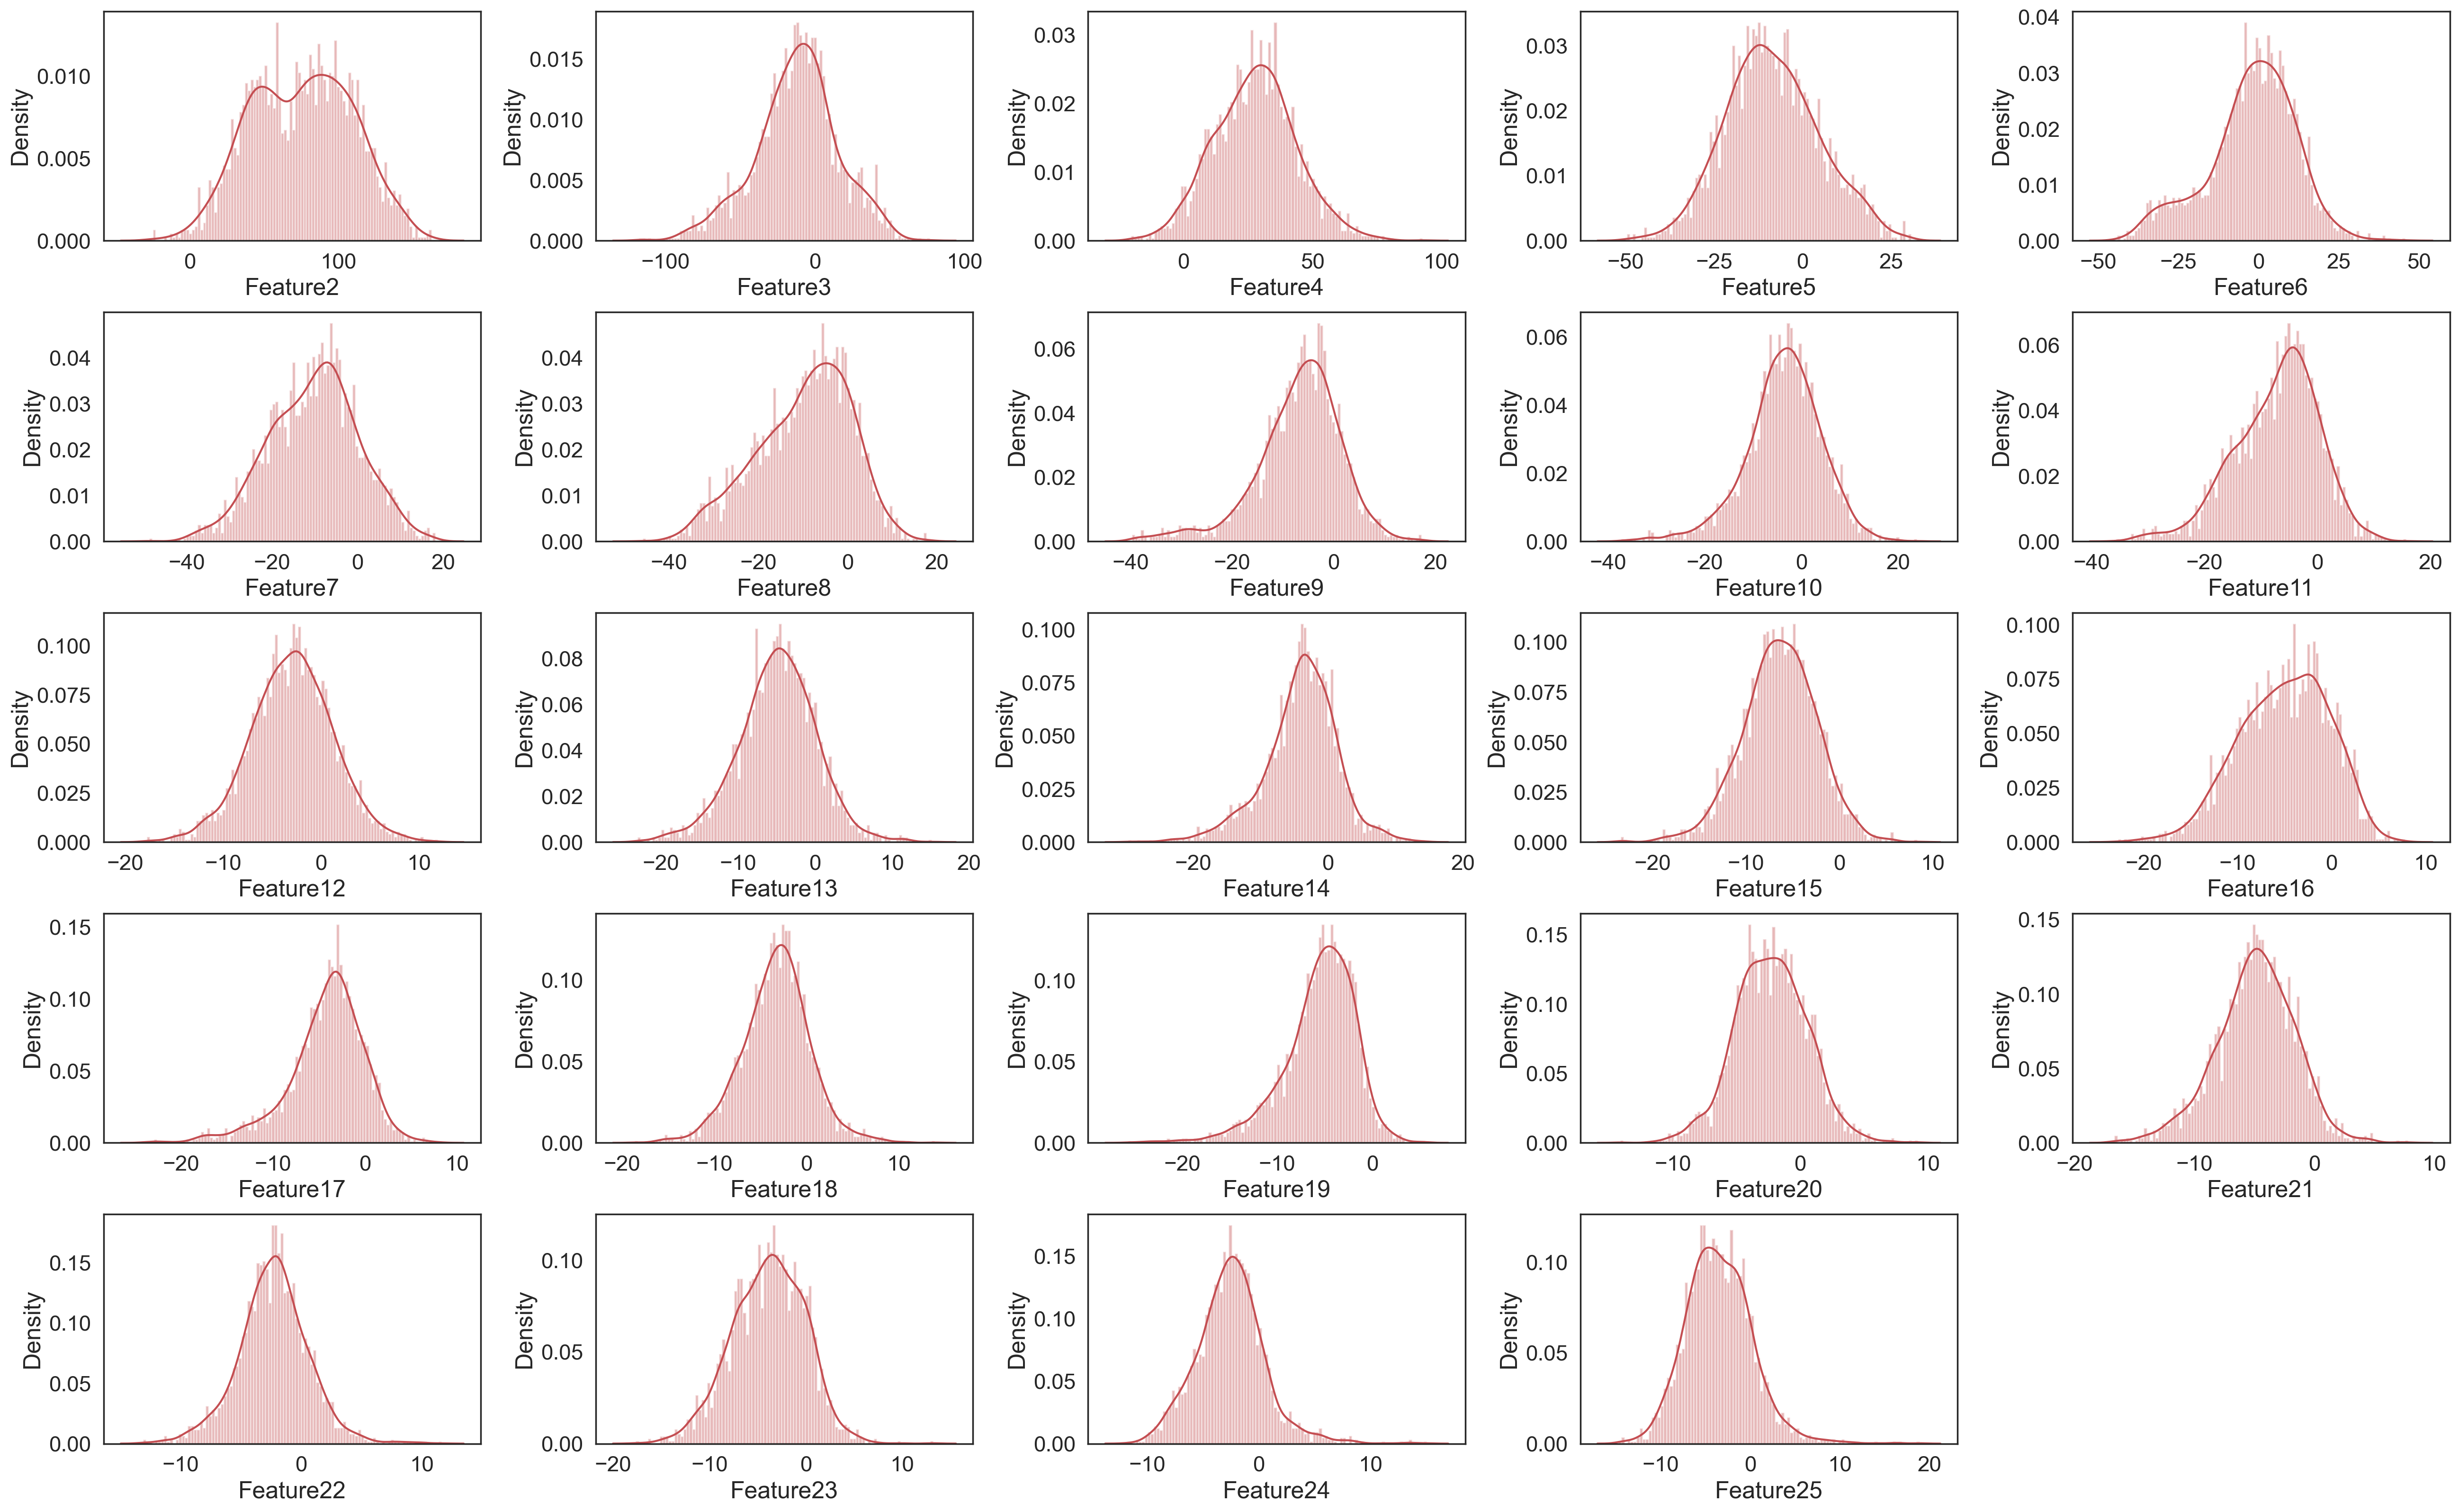

In [58]:
plt.rcParams.update({'figure.figsize': [26, 16], 'font.size': 8})
for i, col in enumerate(x.columns[1:]):
    ax = plt.subplot(5, 5, i + 1)
    sns.distplot(x[col], bins=100, color="r")
    plt.tight_layout()
# plt.savefig("./ASG3_figs/figure6.png")

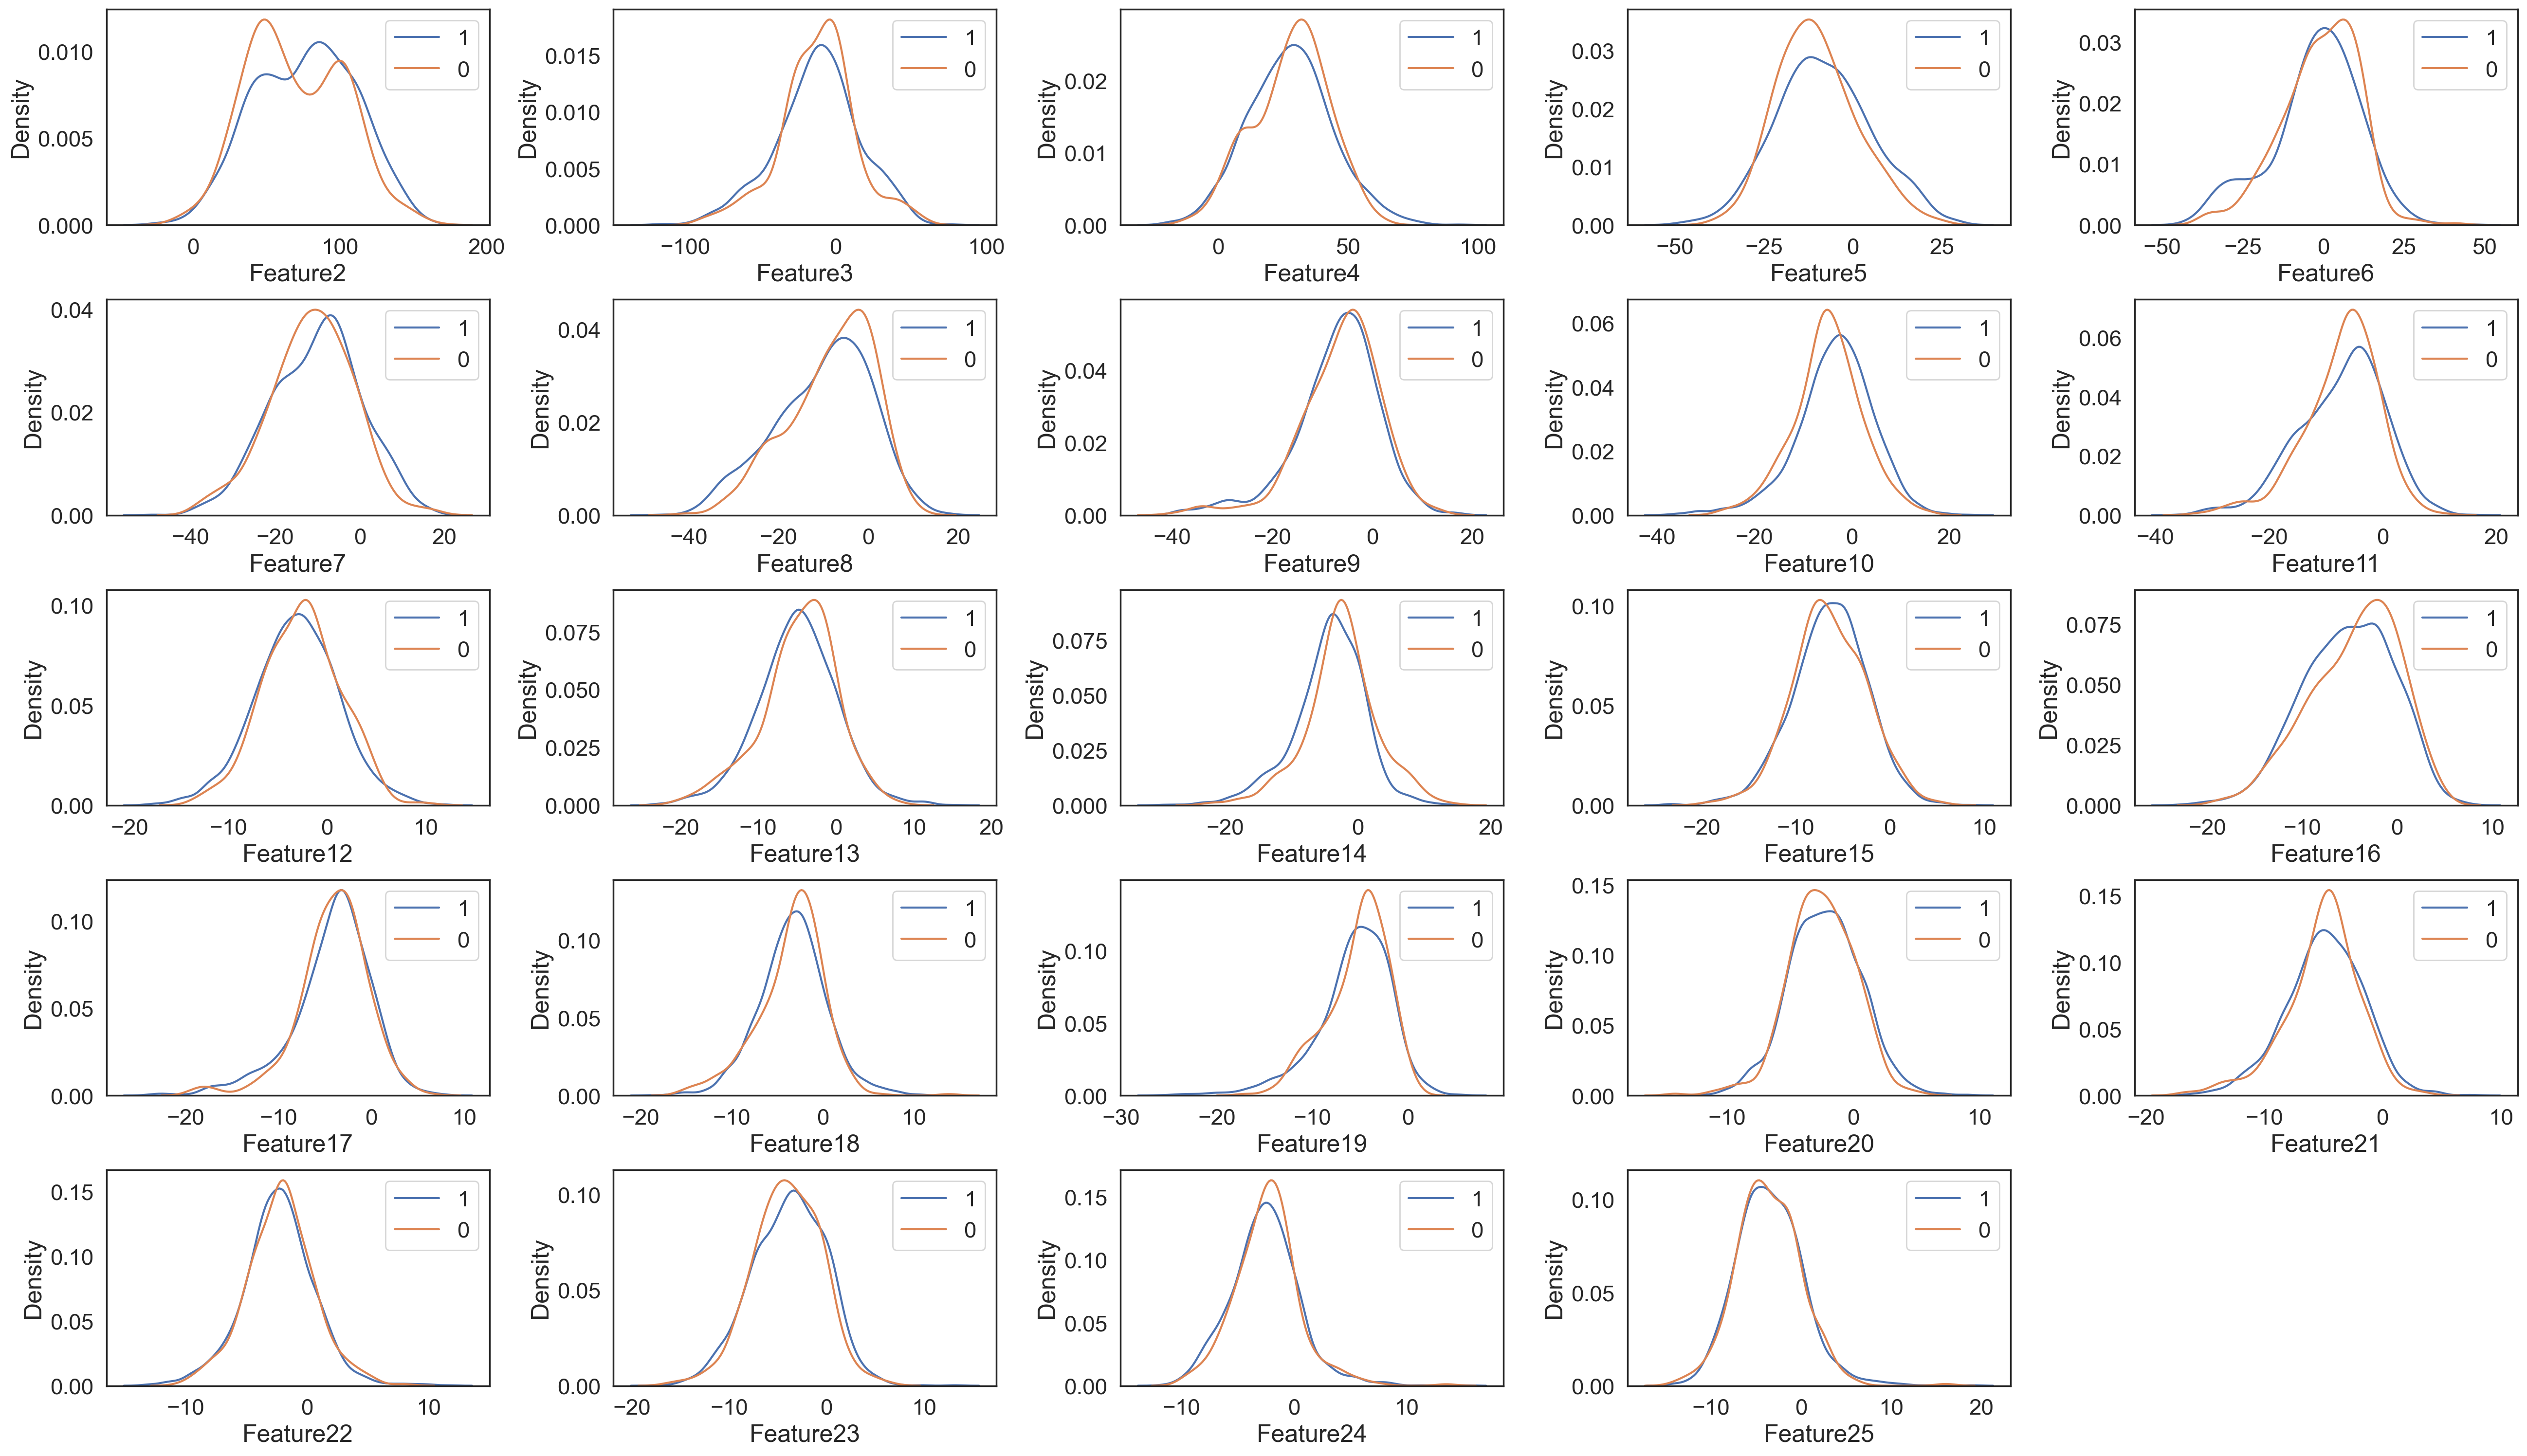

In [59]:
plt.rcParams.update({'figure.figsize': [26, 15], 'font.size': 8})
for i,col in enumerate(x.columns[1:26]):
    ax = plt.subplot(5,5,i+1)
#     ax = plt.title(col)
    for idnt in targets:
        surface_feature = final_data[final_data['Stutter'] == idnt]
        sns.kdeplot(surface_feature[col], label = idnt)
        plt.legend()
        plt.tight_layout()

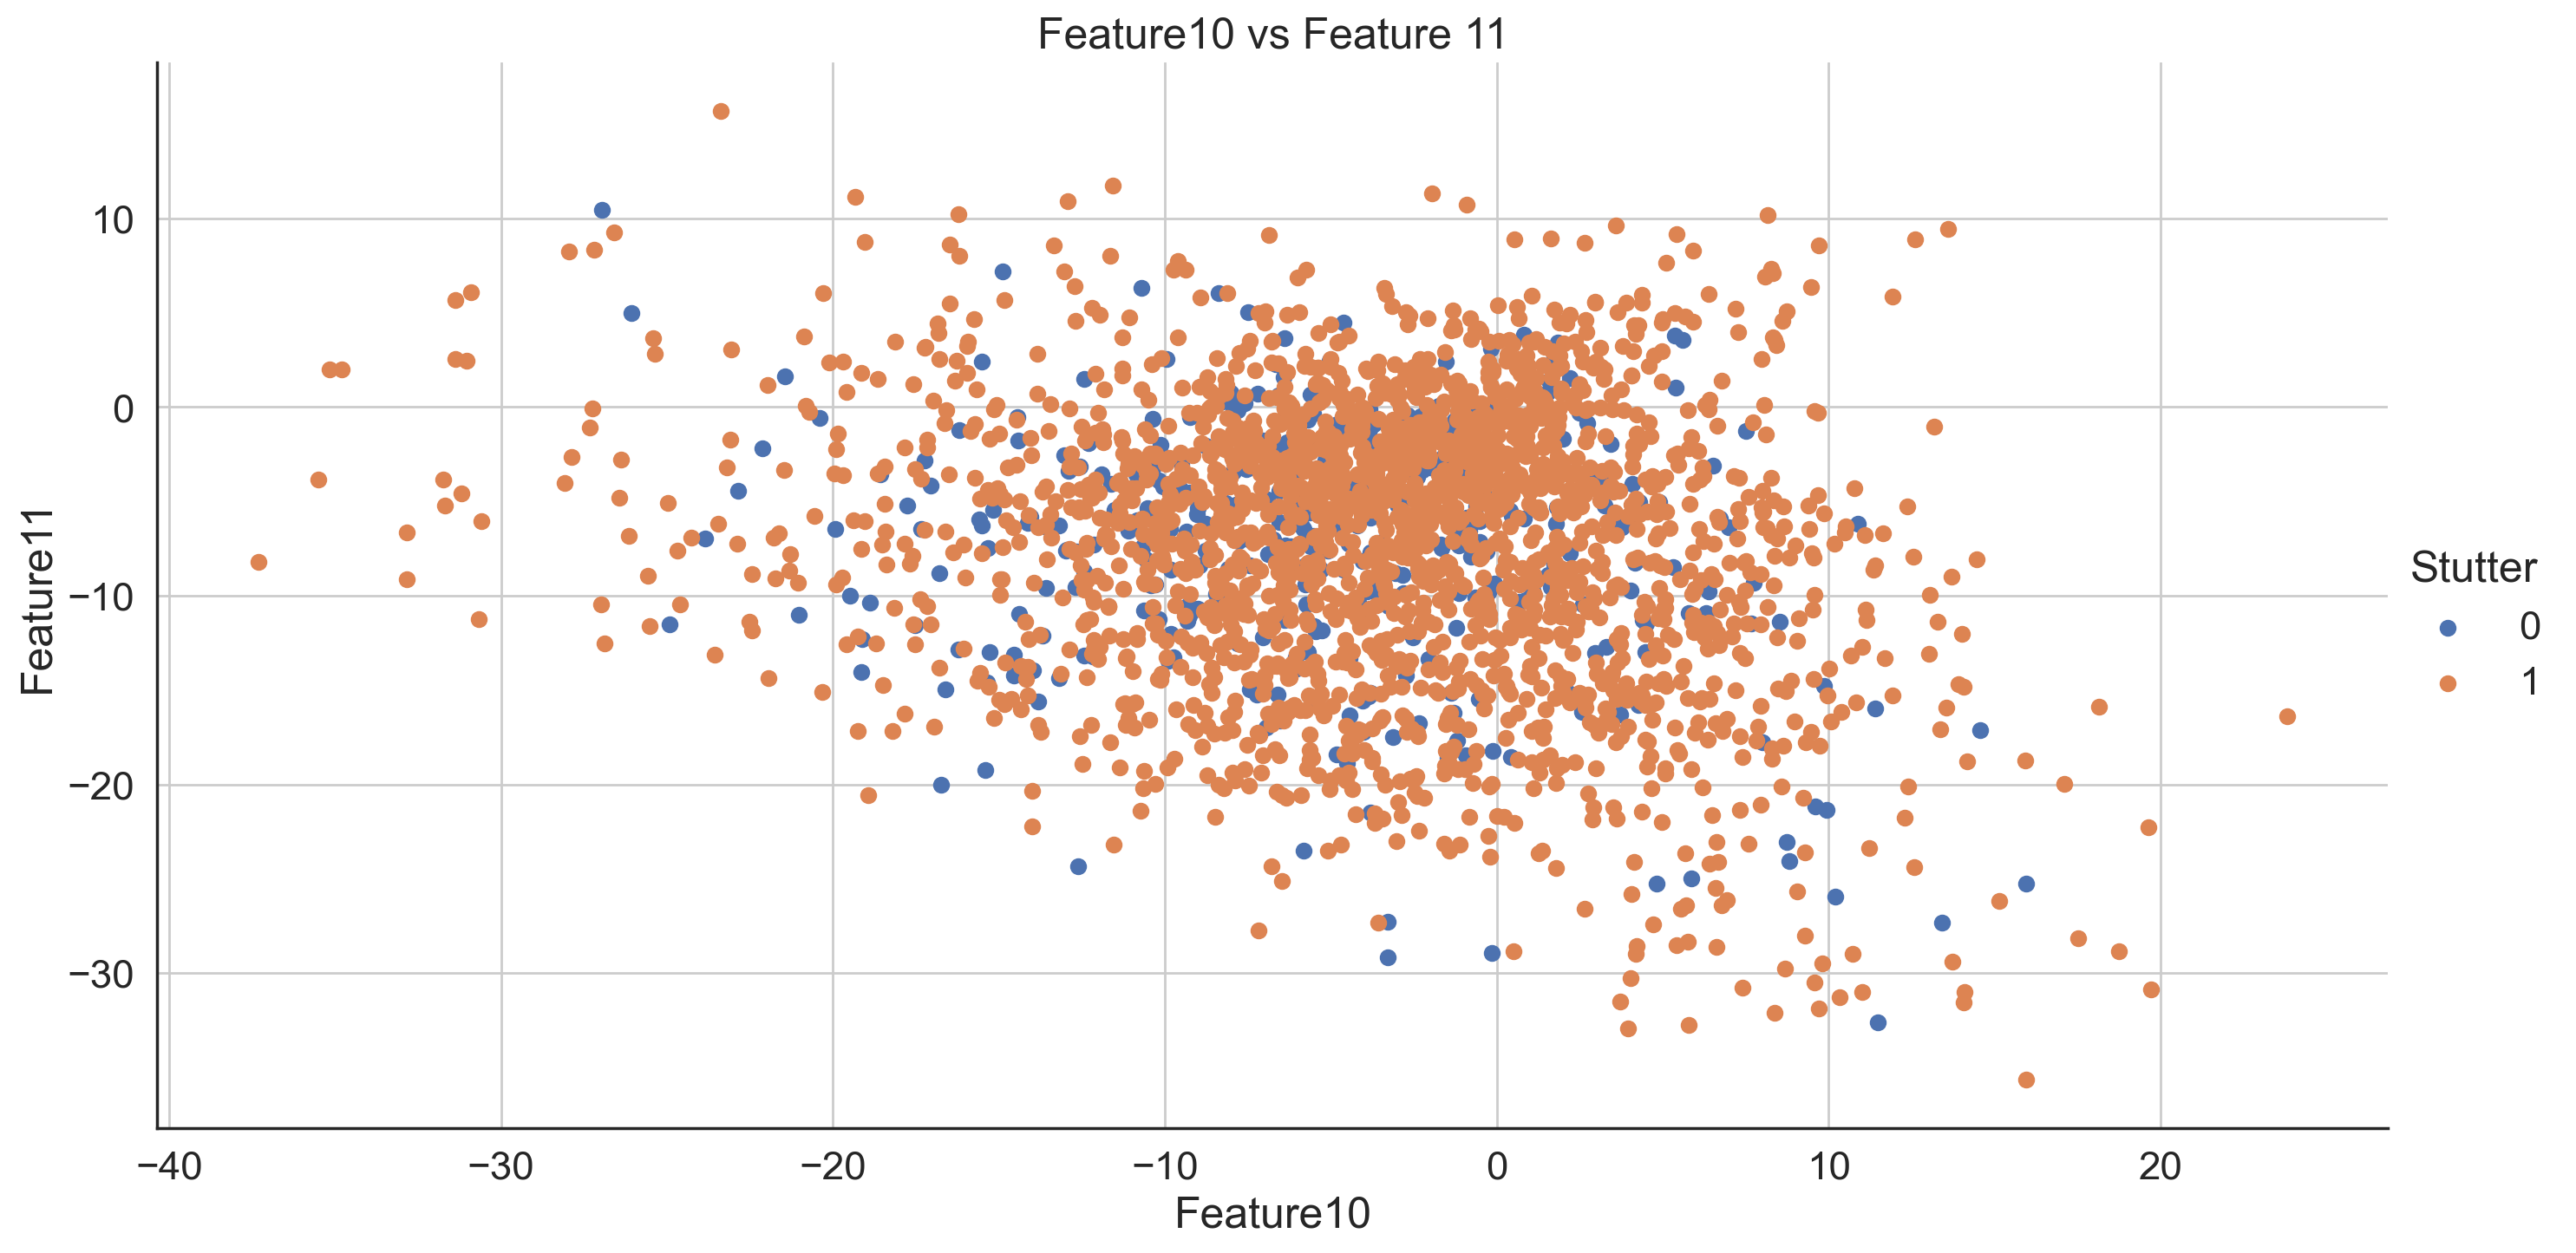

In [60]:
sns.FacetGrid(final_data, hue='Stutter', size=7, aspect=2).map(plt.scatter,'Feature10','Feature11').add_legend()
plt.title('Feature10 vs Feature 11')
plt.grid()
plt.show()

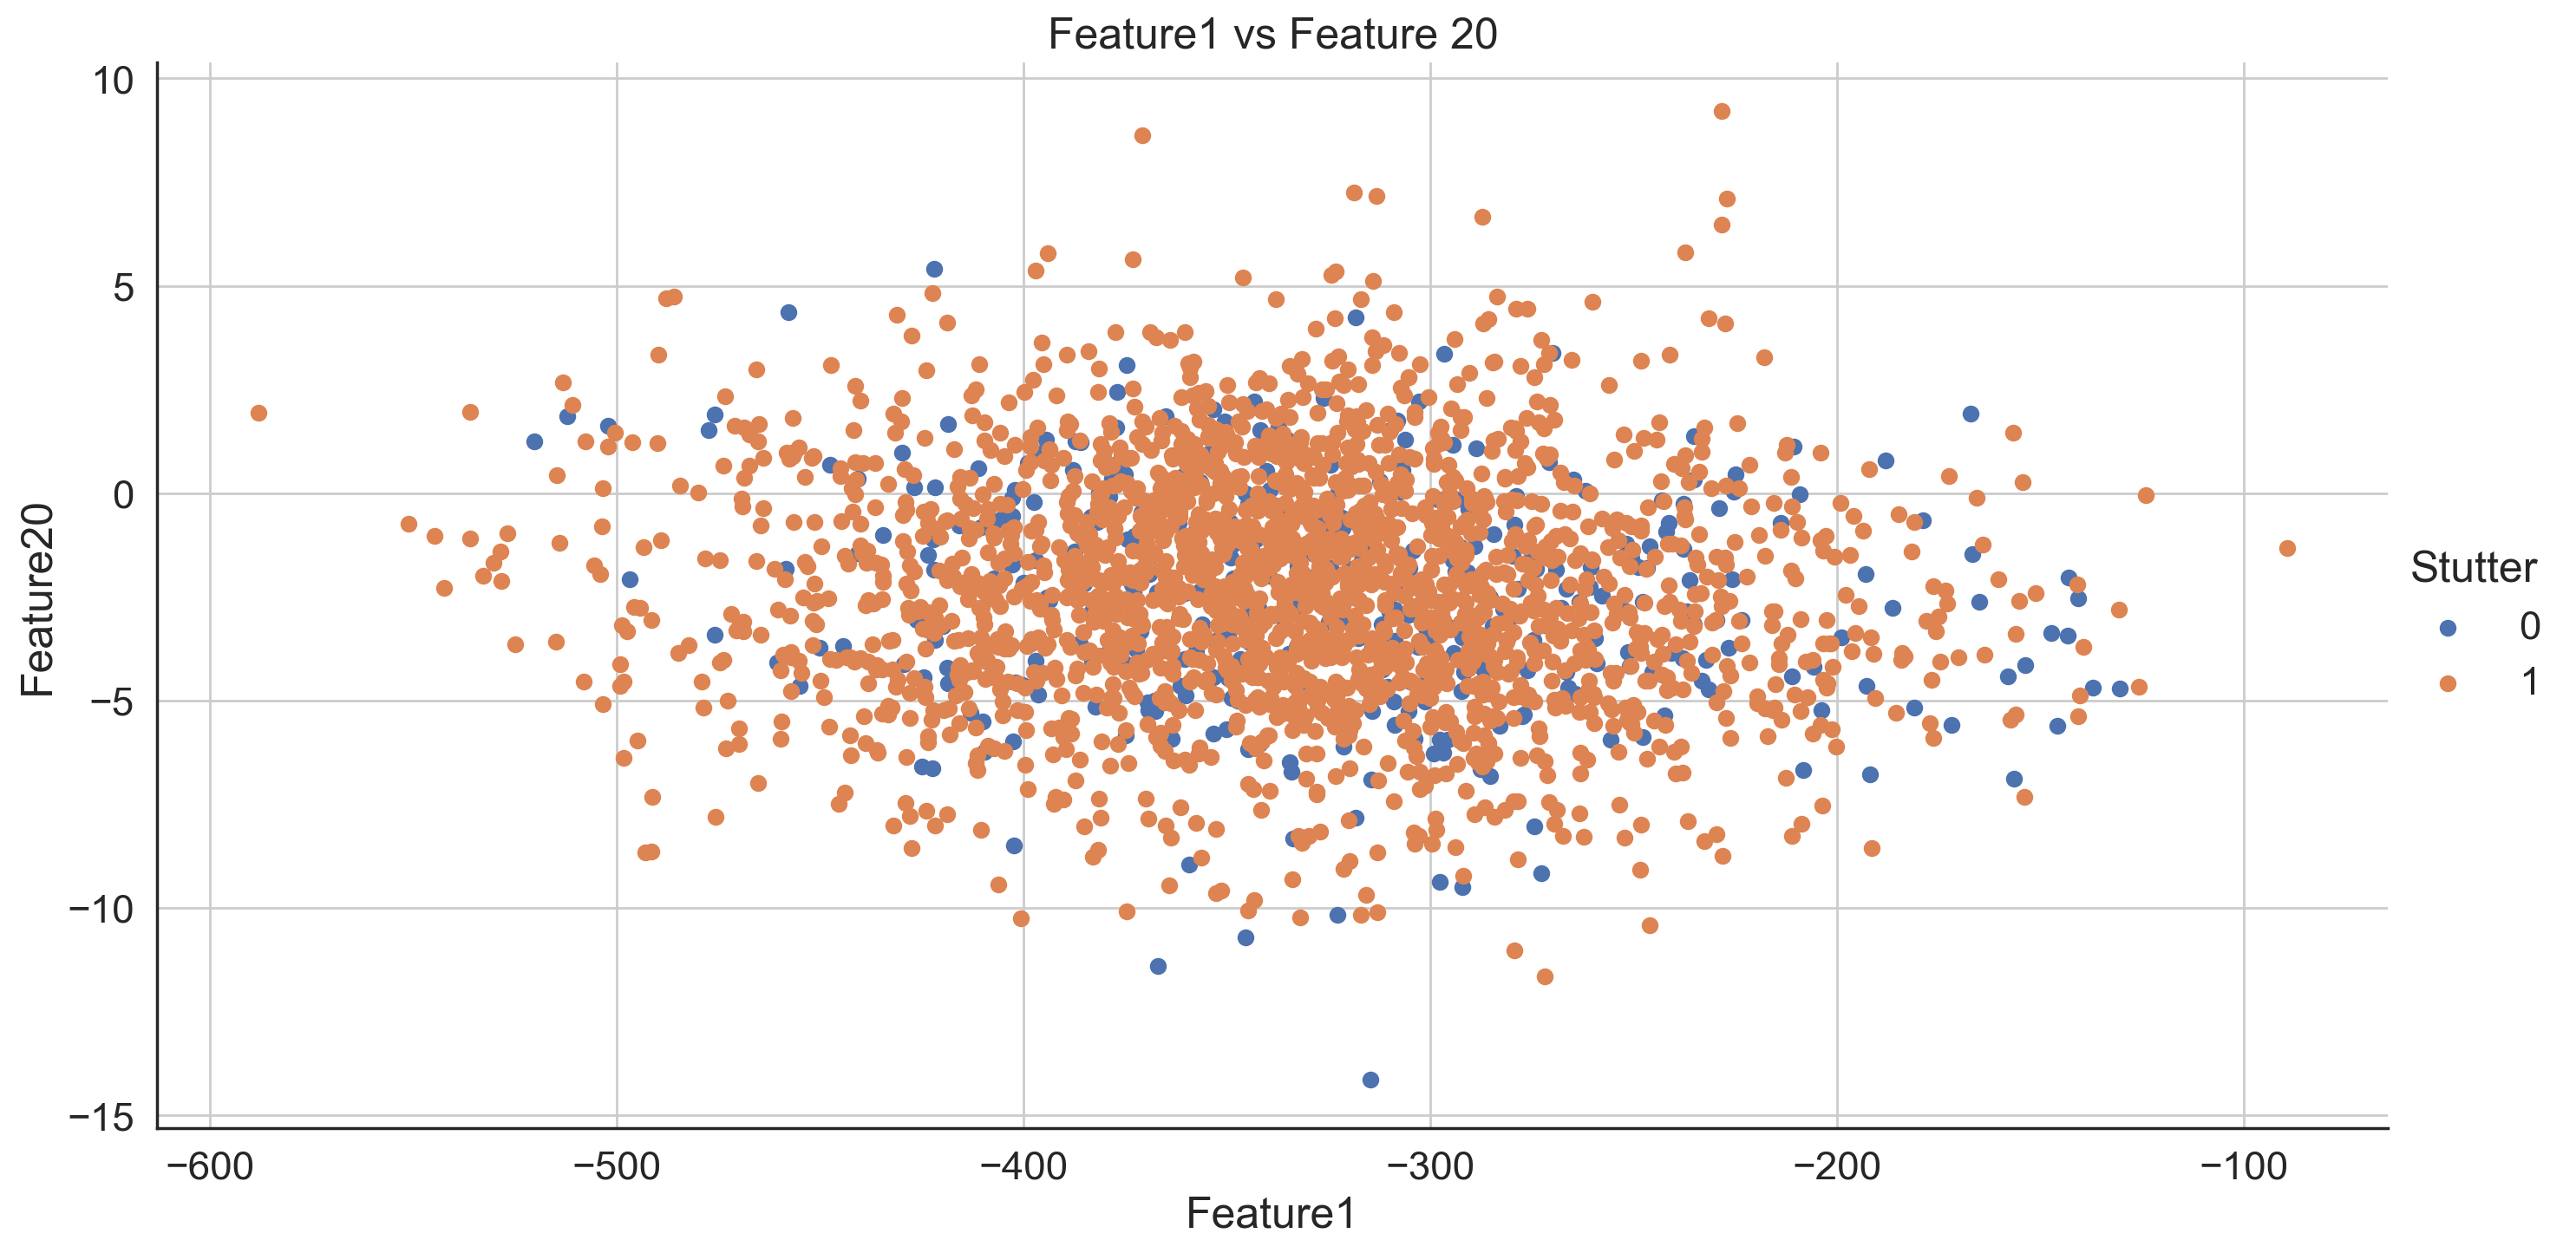

In [61]:
sns.FacetGrid(final_data, hue='Stutter', size=7, aspect=2).map(plt.scatter,'Feature1','Feature20').add_legend()
plt.title('Feature1 vs Feature 20')
plt.grid()
plt.show()

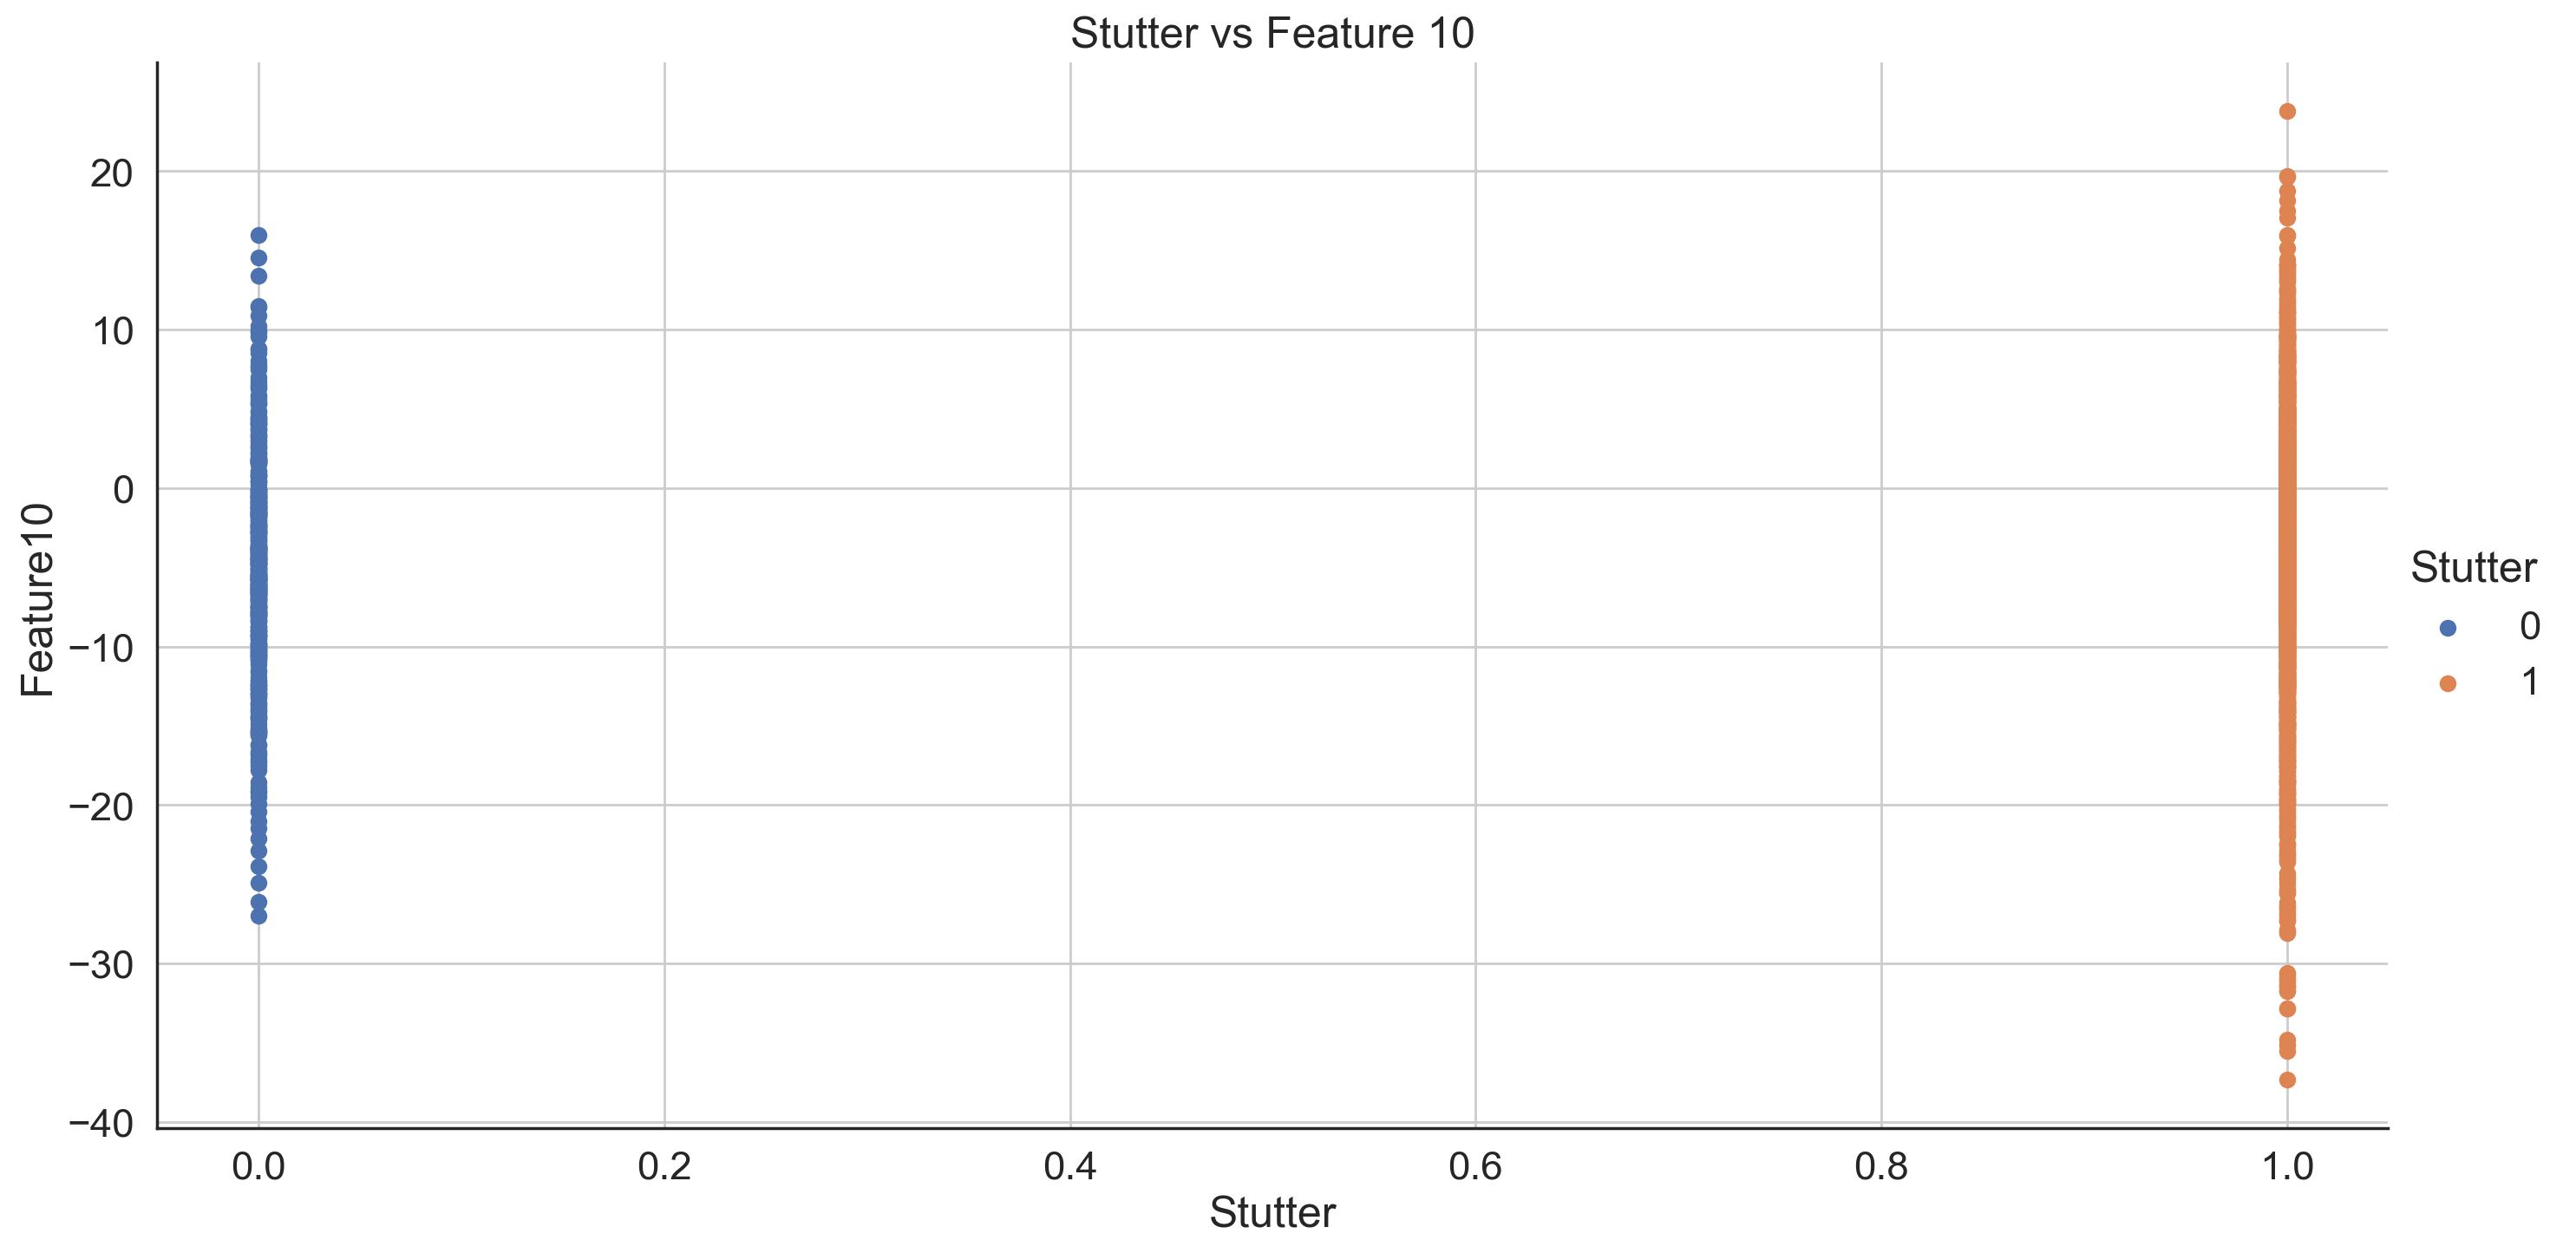

In [62]:
sns.FacetGrid(final_data, hue='Stutter', size=7, aspect=2).map(plt.scatter,'Stutter','Feature10').add_legend()
plt.title('Stutter vs Feature 10')
plt.grid()
plt.show()

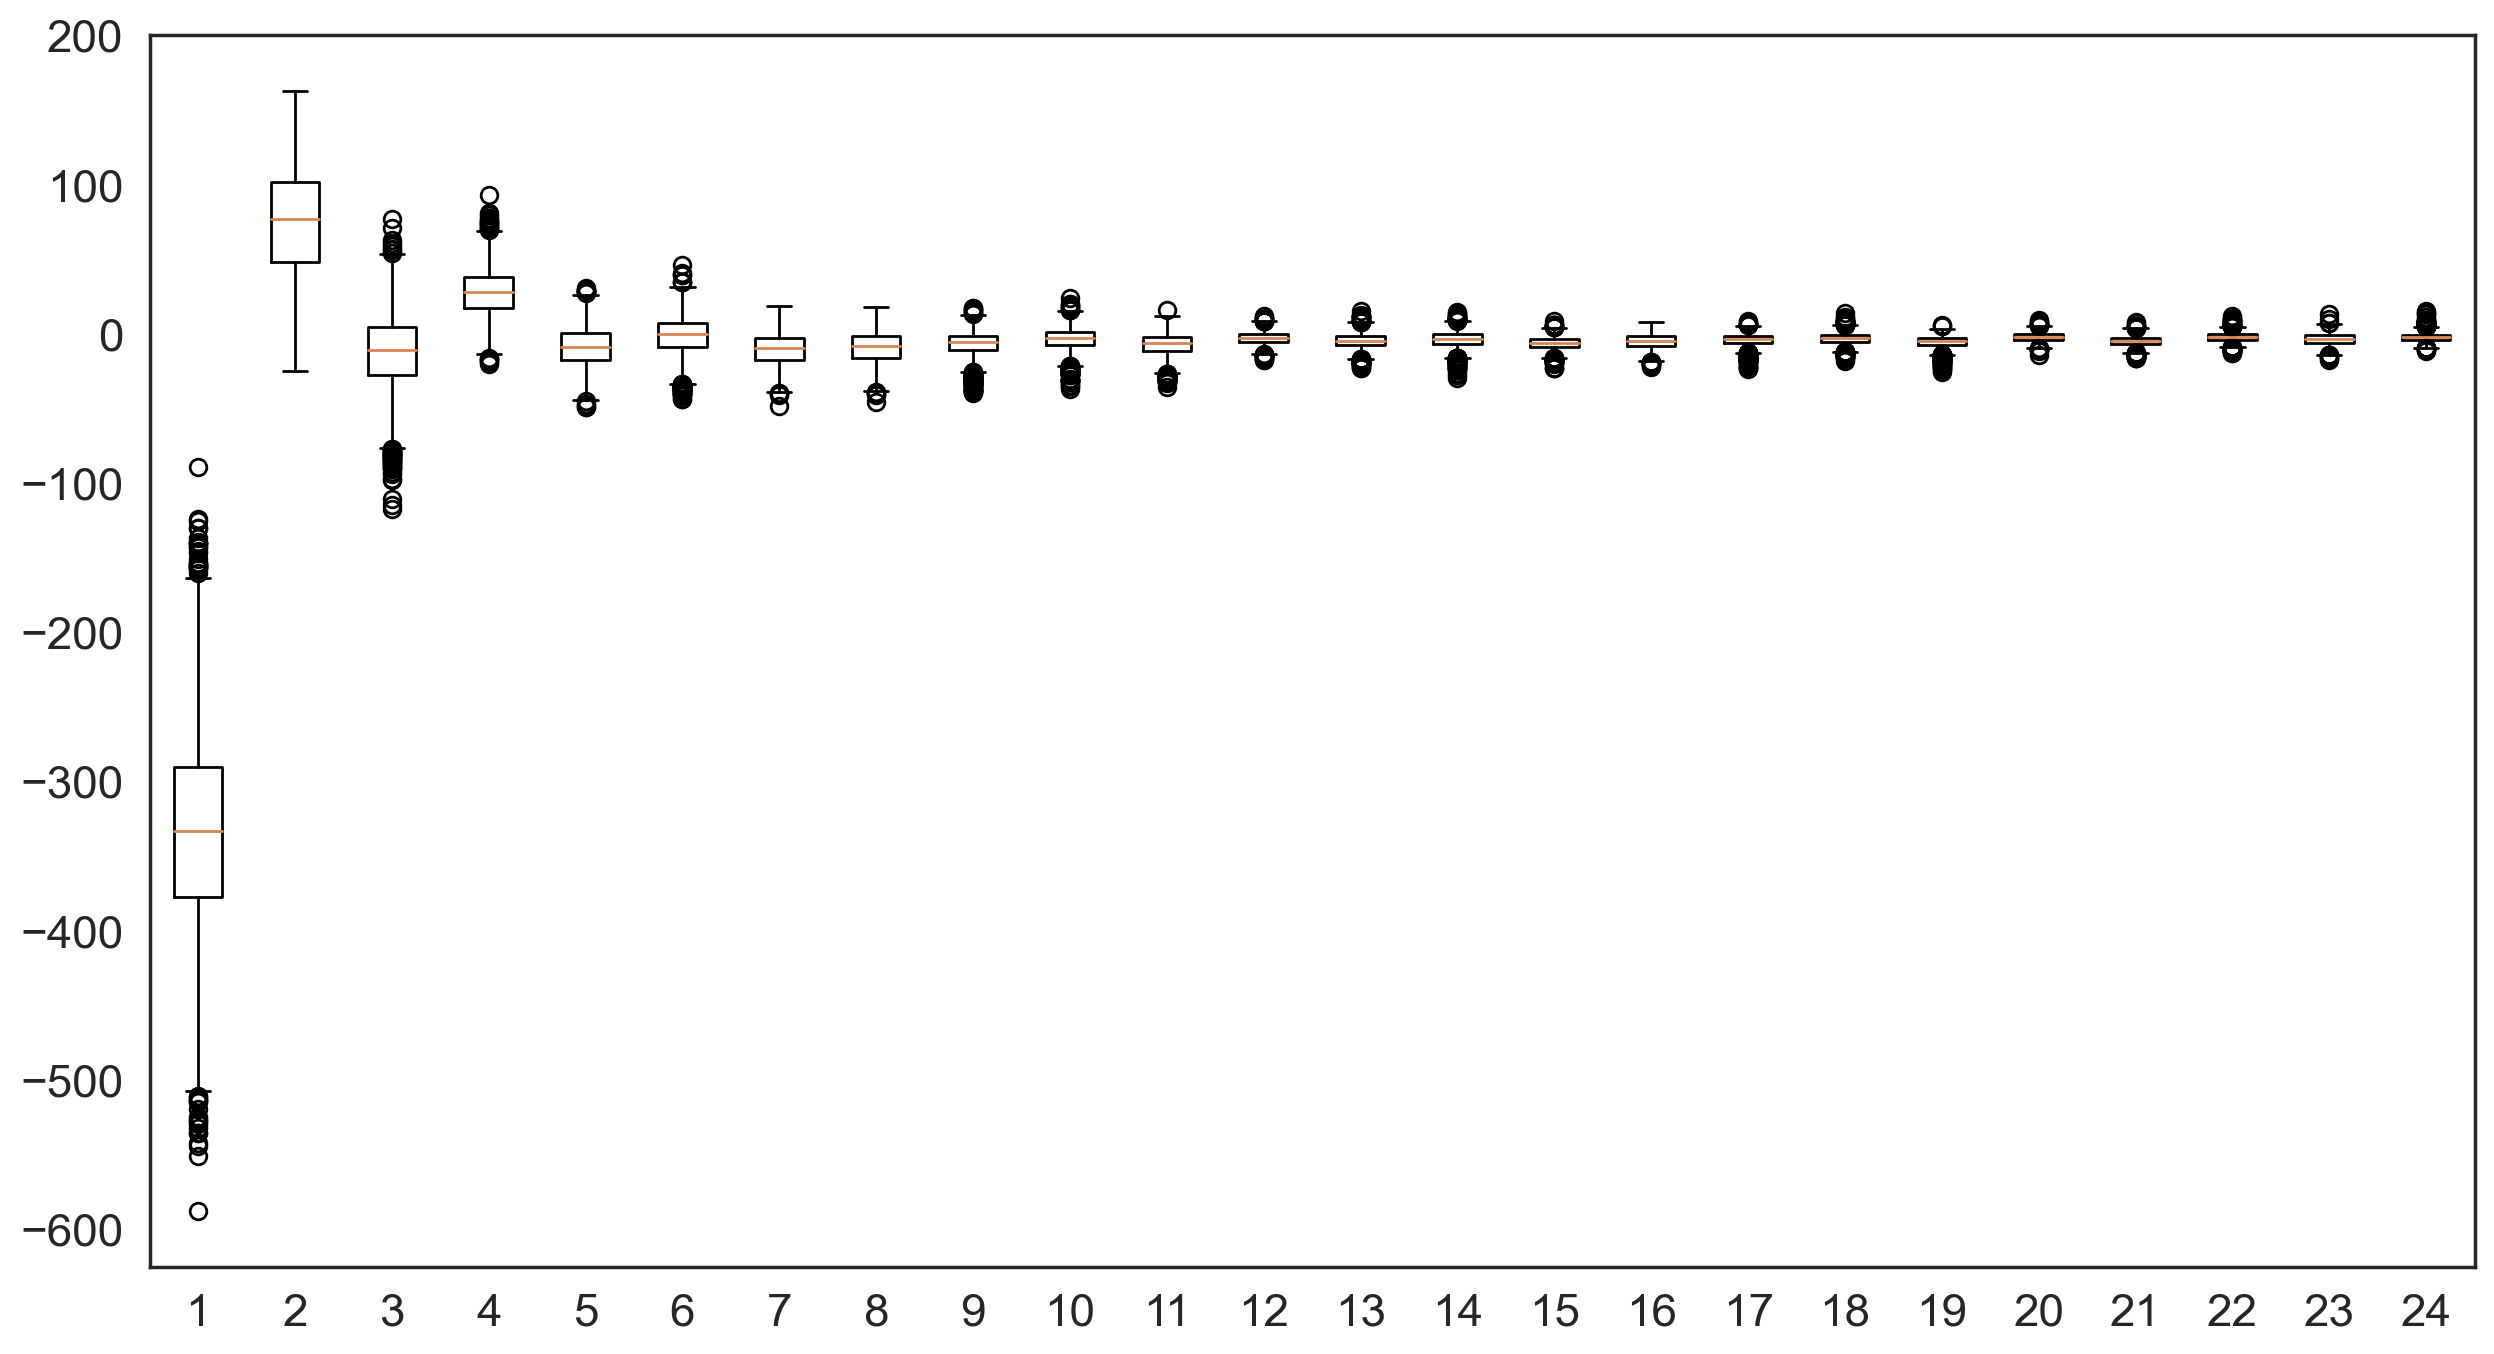

In [63]:
plt.rcParams.update({'figure.figsize': [15, 8], 'font.size': 12})
plt.boxplot(final_data.iloc[:, 0:24]); # plotting 30 feature vector values

# Running model

In [64]:
tr_x = final_data.drop(columns = ['Stutter'])
tr_y = final_data.filter(['Stutter'])

In [65]:
tr_y

Stutter
0           0
1           1
2           1
3           0
4           0
...       ...
3563        1
3564        1
3565        0
3566        1
3567        0

[2451 rows x 1 columns]

Text(0.5, 0.98, ' Correlation Heatmap for Train dataset')

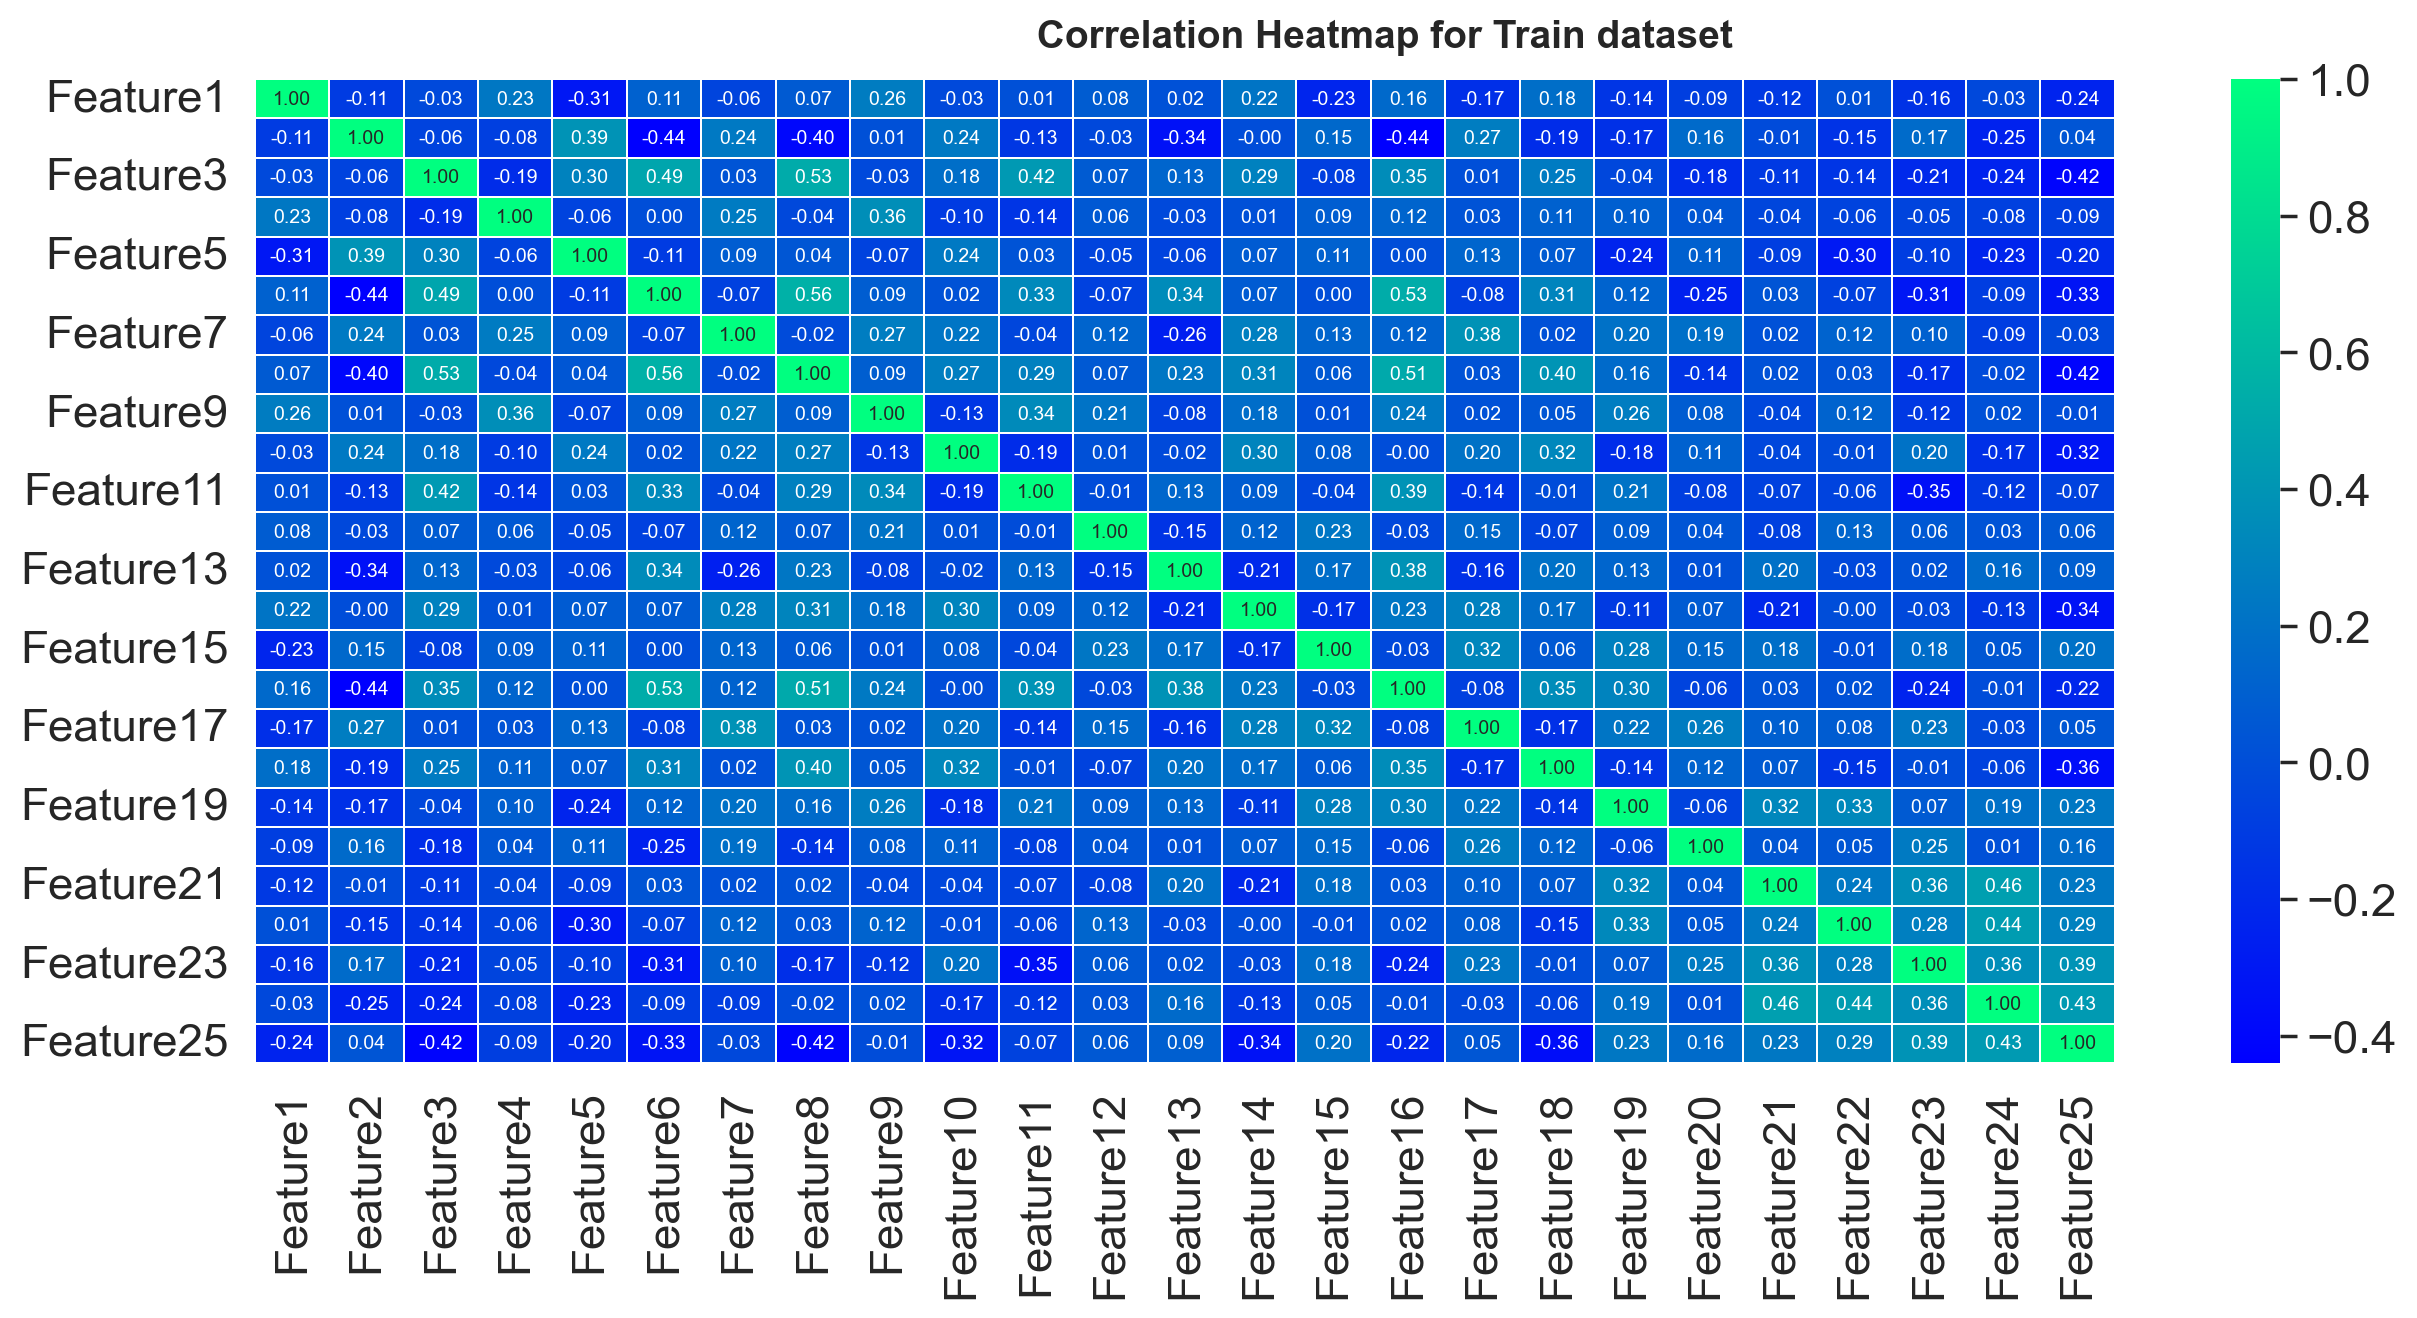

In [66]:
plt.rcParams.update({'figure.figsize': [15, 8], 'font.size': 7})
fig, ax = plt.subplots(1,1, figsize = (15,6))

hm = sns.heatmap(tr_x.iloc[:,0:].corr(),
                ax = ax,
                cmap = 'winter',
                annot = True,
                fmt = '.2f',
                linewidths = 0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle(' Correlation Heatmap for Train dataset', 
              fontsize=14, 
              fontweight='bold')

In [67]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaled_x = StandardScaler().fit_transform(tr_x)
scaled_x =pd.DataFrame(scaled_x) #Scaled training data

In [68]:
scaled_x.columns=["Feature"+str(i) for i in range(1, 26)]

In [69]:
scaled_x

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0    -0.700212 -0.741010  0.529250 -0.845666  0.776680 -0.022686 -0.189664   
1    -0.372131 -0.271290  0.379735 -1.040152  0.304932  0.136172  0.469660   
2     0.577902 -0.044189  0.500722 -1.899118  0.339791  0.233738  0.613505   
3     0.478748 -0.664991  0.392287 -0.315619  0.443695 -0.247879 -0.738971   
4     0.163845 -1.050011 -0.506788  0.218359 -0.928392 -0.215865  0.142813   
...        ...       ...       ...       ...       ...       ...       ...   
2446 -0.825084  0.596325  0.757627 -0.636828  0.884121  0.653365  1.146742   
2447 -0.150765  1.199747  0.713655 -1.268847  0.684012  1.214521  1.018748   
2448  0.214272  0.811386 -0.289165 -0.242395  1.592491  1.110628  0.347086   
2449  0.099012  1.185292  0.569491 -0.561555  0.562762  0.744127  1.348626   
2450  0.184587  1.218281  0.095302 -0.274576  1.330393  0.502751  0.683611   

      Feature8  Feature9  Feature10  ...  Feature16  Feature17  Feature18  \
0     1.030199 -0.282759  -0.376108  ...   0.433661   0.294162  -0.454659   
1     0.330522 -0.104687  -0.362278  ...   0.295034  -0.180733   0.399239   
2     0.556649 -0.050274  -0.198426  ...  -0.382073   0.711262  -0.008335   
3     0.930026 -1.300180  -0.926206  ...   0.893344   0.128546  -0.627737   
4     0.485241  0.013403  -0.612955  ...  -0.381122   0.946793   0.292557   
...        ...       ...        ...  ...        ...        ...        ...   
2446  0.885620 -0.076641   0.205256  ...   0.403803  -1.057895  -0.190862   
2447 -0.123875 -0.939963   0.138161  ...  -0.026391  -1.004461  -0.745559   
2448 -0.470152  0.370343   0.688135  ...  -0.026739  -1.016307  -1.154972   
2449  0.459540 -0.412742   0.024299  ...  -0.993933   0.087991  -1.310322   
2450 -0.739892 -0.702663   0.320723  ...  -0.112111  -1.247113  -0.662042   

      Feature19  Feature20  Feature21  Feature22  Feature23  Feature24  \
0      0.491033  -0.628216   0.632000  -0.002228  -0.251091   0.681197   
1     -0.562700   0.828361   0.127414  -0.111701   0.238615  -0.344099   
2      0.036784   0.299638   0.069443   0.072039  -0.180213  -0.421071   
3      0.628886  -0.785553  -0.048525  -0.900135  -0.184761  -0.388245   
4      0.403402   0.816214   0.902311   0.326966   0.381715  -0.210702   
...         ...        ...        ...        ...        ...        ...   
2446  -0.496341  -0.777549  -0.585160   0.802609  -0.720156   1.078384   
2447  -2.519459  -1.673908   0.631755  -0.621679  -0.840420   0.937377   
2448  -1.819525  -0.058259   1.135629  -0.994206  -0.036450   0.784569   
2449  -1.036405   0.933210  -1.388832   0.015322  -0.491781  -0.189480   
2450  -1.474965  -1.355554   0.338107  -0.782361  -0.624045   0.317216   

      Feature25  
0     -0.357669  
1     -0.070465  
2     -0.807269  
3     -1.237928  
4      0.059409  
...         ...  
2446  -1.033316  
2447  -1.956243  
2448  -2.495862  
2449  -0.913704  
2450  -2.037980  

[2451 rows x 25 columns]

In [70]:
tr = pd.concat([scaled_x, tr_y], axis = 1)

In [71]:
scaled_x

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0    -0.700212 -0.741010  0.529250 -0.845666  0.776680 -0.022686 -0.189664   
1    -0.372131 -0.271290  0.379735 -1.040152  0.304932  0.136172  0.469660   
2     0.577902 -0.044189  0.500722 -1.899118  0.339791  0.233738  0.613505   
3     0.478748 -0.664991  0.392287 -0.315619  0.443695 -0.247879 -0.738971   
4     0.163845 -1.050011 -0.506788  0.218359 -0.928392 -0.215865  0.142813   
...        ...       ...       ...       ...       ...       ...       ...   
2446 -0.825084  0.596325  0.757627 -0.636828  0.884121  0.653365  1.146742   
2447 -0.150765  1.199747  0.713655 -1.268847  0.684012  1.214521  1.018748   
2448  0.214272  0.811386 -0.289165 -0.242395  1.592491  1.110628  0.347086   
2449  0.099012  1.185292  0.569491 -0.561555  0.562762  0.744127  1.348626   
2450  0.184587  1.218281  0.095302 -0.274576  1.330393  0.502751  0.683611   

      Feature8  Feature9  Feature10  ...  Feature16  Feature17  Feature18  \
0     1.030199 -0.282759  -0.376108  ...   0.433661   0.294162  -0.454659   
1     0.330522 -0.104687  -0.362278  ...   0.295034  -0.180733   0.399239   
2     0.556649 -0.050274  -0.198426  ...  -0.382073   0.711262  -0.008335   
3     0.930026 -1.300180  -0.926206  ...   0.893344   0.128546  -0.627737   
4     0.485241  0.013403  -0.612955  ...  -0.381122   0.946793   0.292557   
...        ...       ...        ...  ...        ...        ...        ...   
2446  0.885620 -0.076641   0.205256  ...   0.403803  -1.057895  -0.190862   
2447 -0.123875 -0.939963   0.138161  ...  -0.026391  -1.004461  -0.745559   
2448 -0.470152  0.370343   0.688135  ...  -0.026739  -1.016307  -1.154972   
2449  0.459540 -0.412742   0.024299  ...  -0.993933   0.087991  -1.310322   
2450 -0.739892 -0.702663   0.320723  ...  -0.112111  -1.247113  -0.662042   

      Feature19  Feature20  Feature21  Feature22  Feature23  Feature24  \
0      0.491033  -0.628216   0.632000  -0.002228  -0.251091   0.681197   
1     -0.562700   0.828361   0.127414  -0.111701   0.238615  -0.344099   
2      0.036784   0.299638   0.069443   0.072039  -0.180213  -0.421071   
3      0.628886  -0.785553  -0.048525  -0.900135  -0.184761  -0.388245   
4      0.403402   0.816214   0.902311   0.326966   0.381715  -0.210702   
...         ...        ...        ...        ...        ...        ...   
2446  -0.496341  -0.777549  -0.585160   0.802609  -0.720156   1.078384   
2447  -2.519459  -1.673908   0.631755  -0.621679  -0.840420   0.937377   
2448  -1.819525  -0.058259   1.135629  -0.994206  -0.036450   0.784569   
2449  -1.036405   0.933210  -1.388832   0.015322  -0.491781  -0.189480   
2450  -1.474965  -1.355554   0.338107  -0.782361  -0.624045   0.317216   

      Feature25  
0     -0.357669  
1     -0.070465  
2     -0.807269  
3     -1.237928  
4      0.059409  
...         ...  
2446  -1.033316  
2447  -1.956243  
2448  -2.495862  
2449  -0.913704  
2450  -2.037980  

[2451 rows x 25 columns]

In [72]:
from sklearn.model_selection import train_test_split
fl_train, fl_test, fl_train_label, fl_test_label = train_test_split(tr_x, tr_y, train_size=0.80, random_state= 23, stratify = tr_y)
fl_train

Feature1    Feature2   Feature3   Feature4   Feature5   Feature6  \
3534 -351.476349    8.086010 -18.172405  18.990456 -12.385705   8.099140   
3235 -298.105835   94.869370  50.426876  16.009150  -8.336297  10.318271   
3281 -319.412750  140.981842  16.575605  -0.066548  -3.618191  -3.116983   
358  -307.528595   83.708130  13.784004  31.035126   0.655708 -10.332361   
3211 -297.260193   22.544340  -1.943453  21.799831 -15.700989  11.546064   
...          ...         ...        ...        ...        ...        ...   
3039 -350.581421   80.508614  56.785774  21.872158  -4.225056  10.214795   
1194 -469.246002   52.562065 -21.183128   7.332106  -5.101370  14.956271   
2900 -278.603882   58.231327  -4.977723  29.997522 -21.132828  26.894888   
2285 -331.221954  117.396004  27.264456  36.763710  19.947590   0.799446   
60   -303.587250   53.964516 -14.352305  13.669205  -7.030845  -6.465870   

       Feature7   Feature8   Feature9  Feature10  ...  Feature16  Feature17  \
3534  -7.610337  -0.532328  -0.693221  -2.679596  ...   0.908748  -8.890415   
3235 -11.248550  -4.589092   0.689893  -0.328550  ...  -3.777260  -4.153648   
3281  -6.169193   2.004002  -4.600886   5.072813  ...  -0.239291  -0.764093   
358   -6.121018 -10.577720 -16.496706  -5.611397  ...  -4.885950  -3.790979   
3211  -8.970313  -0.422903  -2.205301  -1.239465  ...   0.520754  -3.573001   
...         ...        ...        ...        ...  ...        ...        ...   
3039  -3.955472  -1.292566  -0.539138  -0.099513  ...  -1.519232  -1.042868   
1194 -12.304249 -15.530036 -13.375538 -14.200835  ...  -7.829172  -3.025586   
2900  -7.441113   0.078468 -11.126988   6.646459  ...  -2.955108  -5.705241   
2285  -0.013420   9.140189  -4.962938  -2.194047  ...  -4.193442  -5.511367   
60   -15.556920 -17.465059  -1.361711   3.433854  ...  -7.007837  -9.408454   

      Feature18  Feature19  Feature20  Feature21  Feature22  Feature23  \
3534   1.750522  -6.030471  -1.069818  -2.364295   1.127509  -3.084993   
3235  -0.936303  -2.275647  -0.153306  -3.369101  -1.380676  -2.924675   
3281  -3.845802  -2.171471   0.640479  -1.507638  -0.059788   0.341258   
358   -1.181261  -6.521506   0.870673 -15.279790  -7.909578 -10.174536   
3211  -0.259958  -3.449614  -0.806376  -4.327333  -0.300122  -6.982427   
...         ...        ...        ...        ...        ...        ...   
3039  -0.261767  -3.164662   1.723830  -1.689960  -1.673553  -1.092339   
1194  -4.337461  -6.992692  -0.131962  -3.100690  -4.773723   0.513207   
2900   6.128919  -2.146371  -4.048260  -4.143939  -2.279286  -2.181304   
2285  -6.516311 -13.690893  -5.594579  -3.012438  -2.154145  -8.758136   
60    -5.056931  -7.753725  -2.211667  -4.185205   1.033439  -0.386245   

      Feature24  Feature25  
3534   3.449691  -3.586882  
3235  -1.376583  -7.846480  
3281  -2.319177  -4.006120  
358   -7.735664  -6.035354  
3211  -0.768740  -7.399917  
...         ...        ...  
3039   0.136291  -3.226569  
1194  -0.713010   0.708108  
2900  -8.526325  -4.233264  
2285  -7.101764  -3.999599  
60    -0.056659  -3.790320  

[1960 rows x 25 columns]

In [73]:
fl_train_label

Stutter
3534        1
3235        0
3281        1
358         0
3211        1
...       ...
3039        0
1194        1
2900        1
2285        1
60          0

[1960 rows x 1 columns]

In [81]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy_scores = np.zeros(5)

# Support Vector Classifier
clf = SVC().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[0] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'Support Vector Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[0]))

# Logistic Regression
clf = LogisticRegression(max_iter=10000).fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[1] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'Logistic Regression accuracy:'+'\033[0m','{}%'.format(accuracy_scores[1]))

# K Nearest Neighbors
clf = KNeighborsClassifier().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[2] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'K Nearest Neighbors Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[2]))

# Adaboost
clf = AdaBoostClassifier().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[3] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'Adaboost Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[3]))

# RandomForestClassifier
clf = RandomForestClassifier().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[4] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'RandomForest Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[4]))

Support Vector Classifier accuracy: 83.91038696537679%
Logistic Regression accuracy: 84.11405295315683%
K Nearest Neighbors Classifier accuracy: 82.28105906313645%
Adaboost Classifier accuracy: 83.29938900203666%
RandomForest Classifier accuracy: 84.11405295315683%


Text(0, 0.5, 'Accuracy after speedrun')

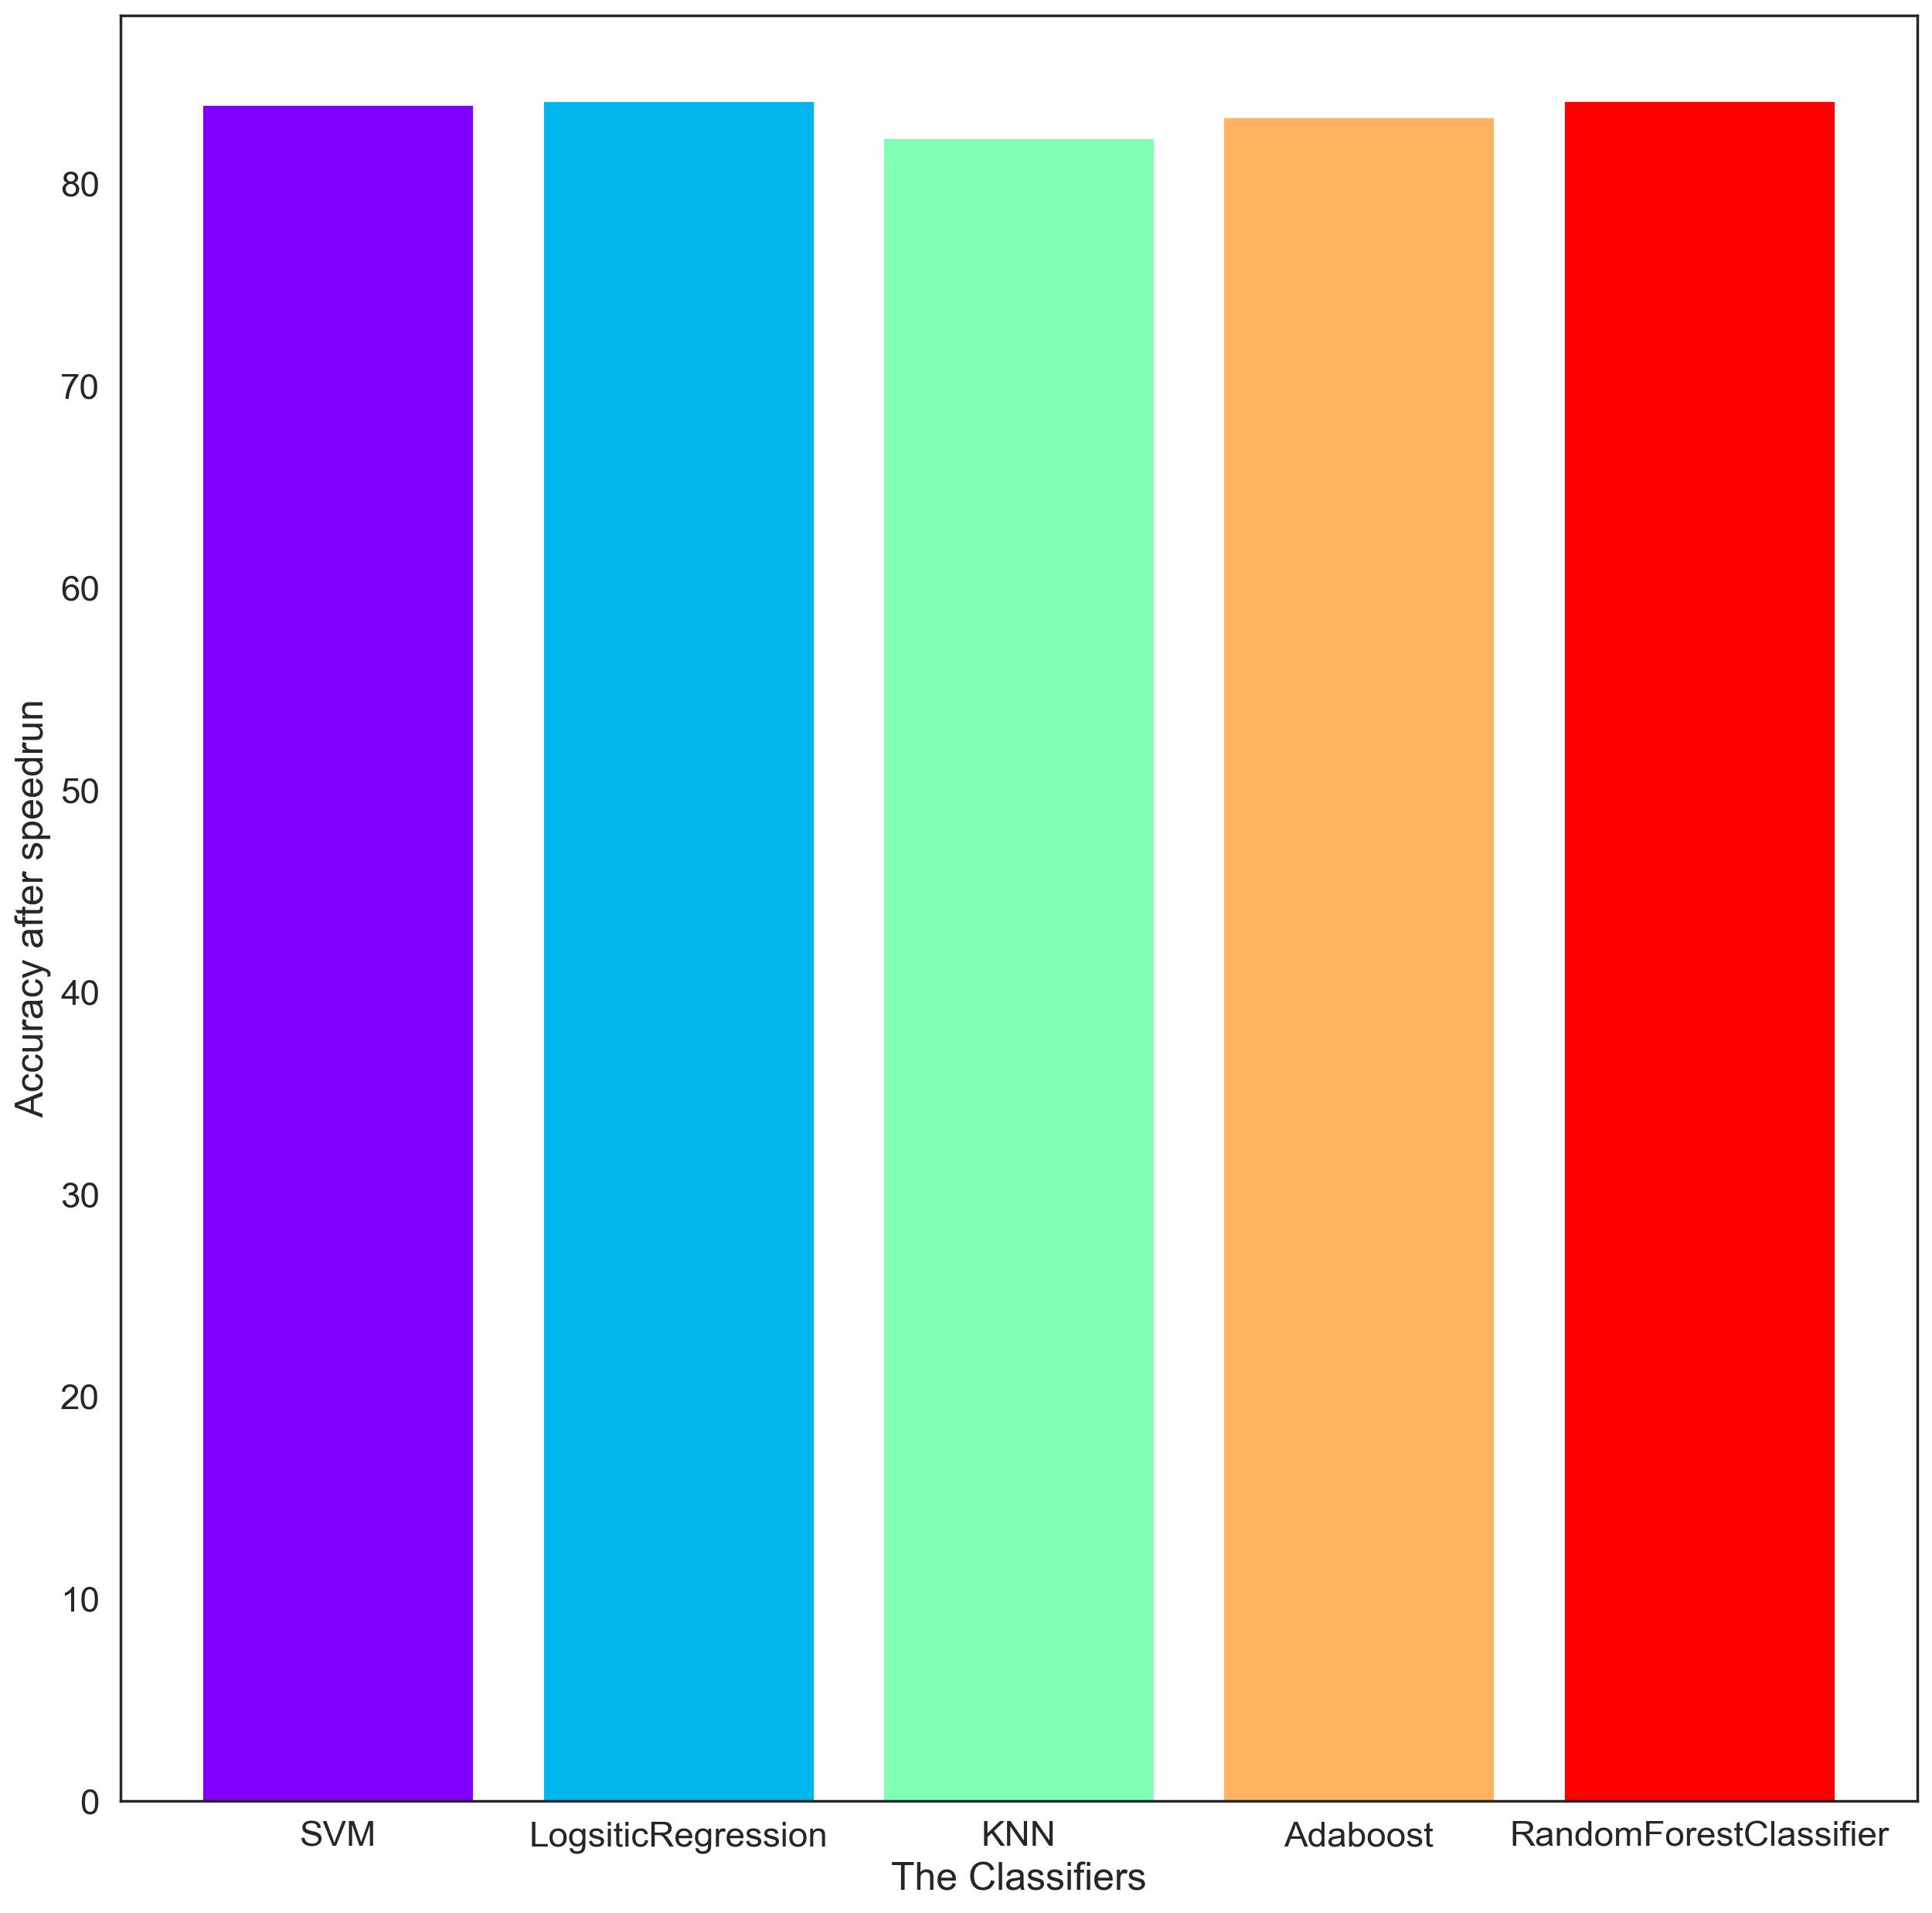

In [75]:
plt.rcParams.update({'figure.figsize': [15, 15], 'font.size': 12})
colors = cm.rainbow(np.linspace(0, 1, 5))
labels = ['SVM', 'LogsiticRegression', 'KNN', 'Adaboost', 'RandomForestClassifier' ]
plt.bar(labels,
        accuracy_scores[:5],
        color = colors)
plt.xlabel('The Classifiers')
plt.ylabel('Accuracy after speedrun')

## Parameter tuning for KNN using all feature vectors

In [77]:
## Parameter tuning for KNN using all feature vectors
from sklearn.neighbors import KNeighborsClassifier
leaf_size = list(range(1,10))
n_neighbors = list(range(1,30))
p = [2]          #[1,2]
metric = ['euclidean', 'manhattan', 'minkowski']
weights = ['uniform']            #['uniform', 'distance']

# #Convert to dictionary
hyperparameters = dict(n_neighbors = n_neighbors,weights = weights, metric = metric, leaf_size = leaf_size, p = p )

# #Create new KNN object
KNN2 = KNeighborsClassifier()

# #Use GridSearch
clf = GridSearchCV(KNN2, hyperparameters, cv = 10)

# #Fit the model
best_model_KNN = clf.fit(fl_train,fl_train_label.values.ravel())

In [78]:
#Print The value of best Hyperparameters

print('Best leaf_size:', best_model_KNN.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model_KNN.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model_KNN.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_model_KNN.best_estimator_.get_params()['weights'])
print('Best metric:', best_model_KNN.best_estimator_.get_params()['metric'])


Best_leaf_size = best_model_KNN.best_estimator_.get_params()['leaf_size']
Best_p = best_model_KNN.best_estimator_.get_params()['p']
Best_n_neighbors = best_model_KNN.best_estimator_.get_params()['n_neighbors']
Best_weights = best_model_KNN.best_estimator_.get_params()['weights']
Best_metric = best_model_KNN.best_estimator_.get_params()['metric']

Best leaf_size: 1
Best p: 2
Best n_neighbors: 17
Best weights: uniform
Best metric: manhattan


 ------------------------------
 Classification Report for SVM
 ------------------------------
              precision    recall  f1-score   support

           0     0.5000    0.0380    0.0706        79
           1     0.8433    0.9927    0.9119       412

    accuracy                         0.8391       491
   macro avg     0.6716    0.5153    0.4913       491
weighted avg     0.7881    0.8391    0.7766       491

KNN Classifier accuracy: 83.91038696537679%


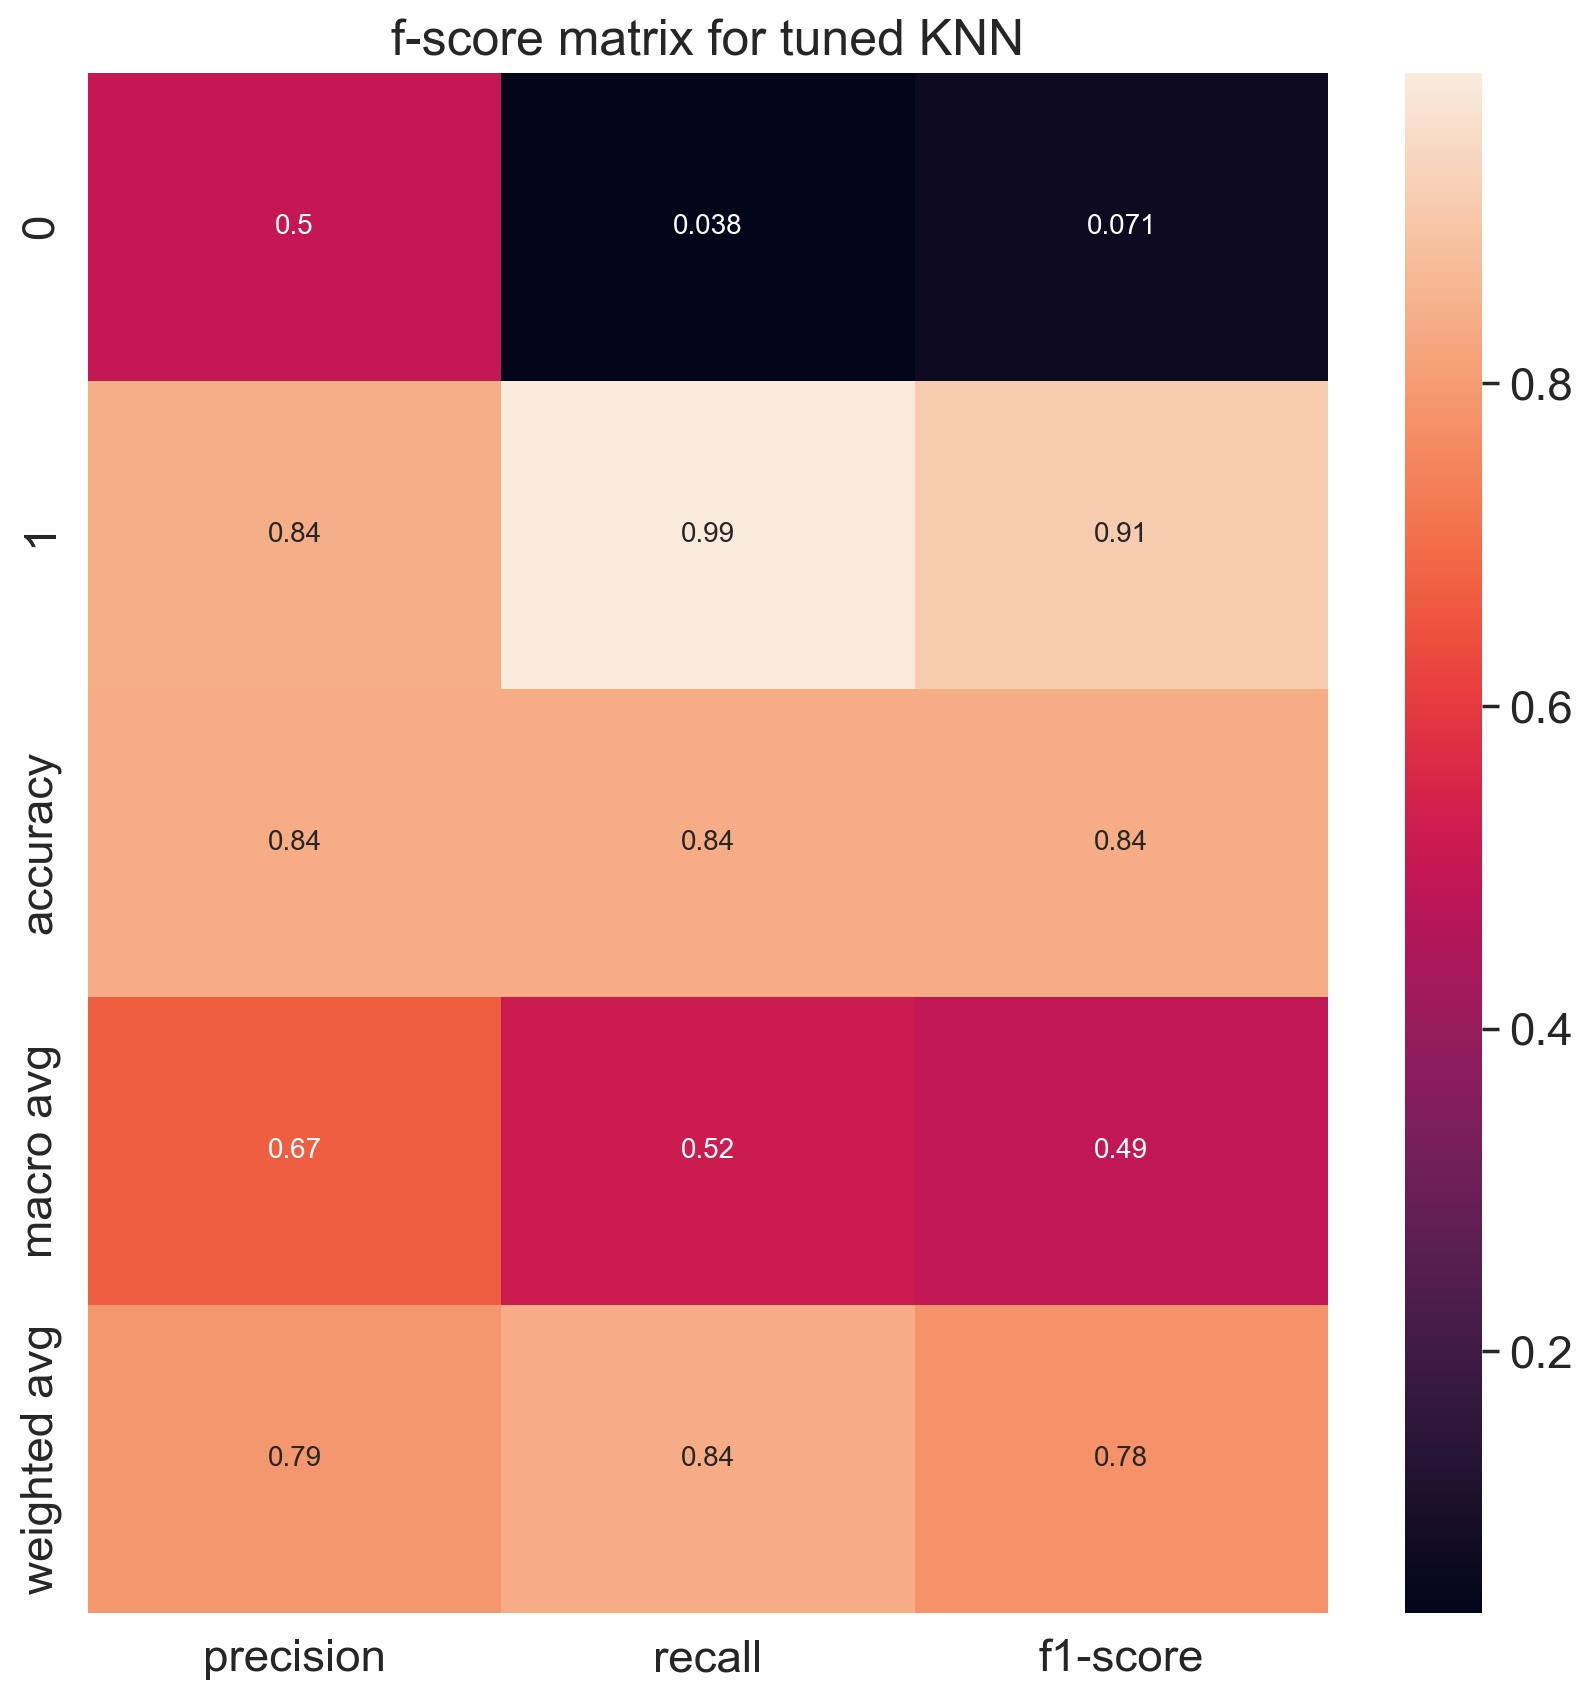

In [76]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 17 ,weights = 'uniform', metric = 'manhattan', leaf_size = 1, p = 2)
clf_KNN = KNN.fit(fl_train, fl_train_label.values.ravel())
KNN_pred = KNN.predict(fl_test)

tbl = np.reshape(KNN_pred, (len(KNN_pred),1))

                
dfKNN = pd.DataFrame(tbl)

y_true = fl_test_label
y_pred = dfKNN
print(' ------------------------------\n','\033[1m'+'\033[95m'+'Classification Report for SVM\n'+'\033[0m','------------------------------')
print(classification_report(y_true, y_pred, digits=4))
re = classification_report(y_true, y_pred, output_dict=True)
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 10})
sns.heatmap(pd.DataFrame(re).iloc[:-1, :].T, annot=True)
plt.title ('f-score matrix for tuned KNN')
accuracy_scores_KNN = accuracy_score(y_true, y_pred)*100
print('\033[1m'+'\033[92m'+'KNN Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores_KNN))


                          -------------------------
                          Confusion Matrix for KNN
                          -------------------------


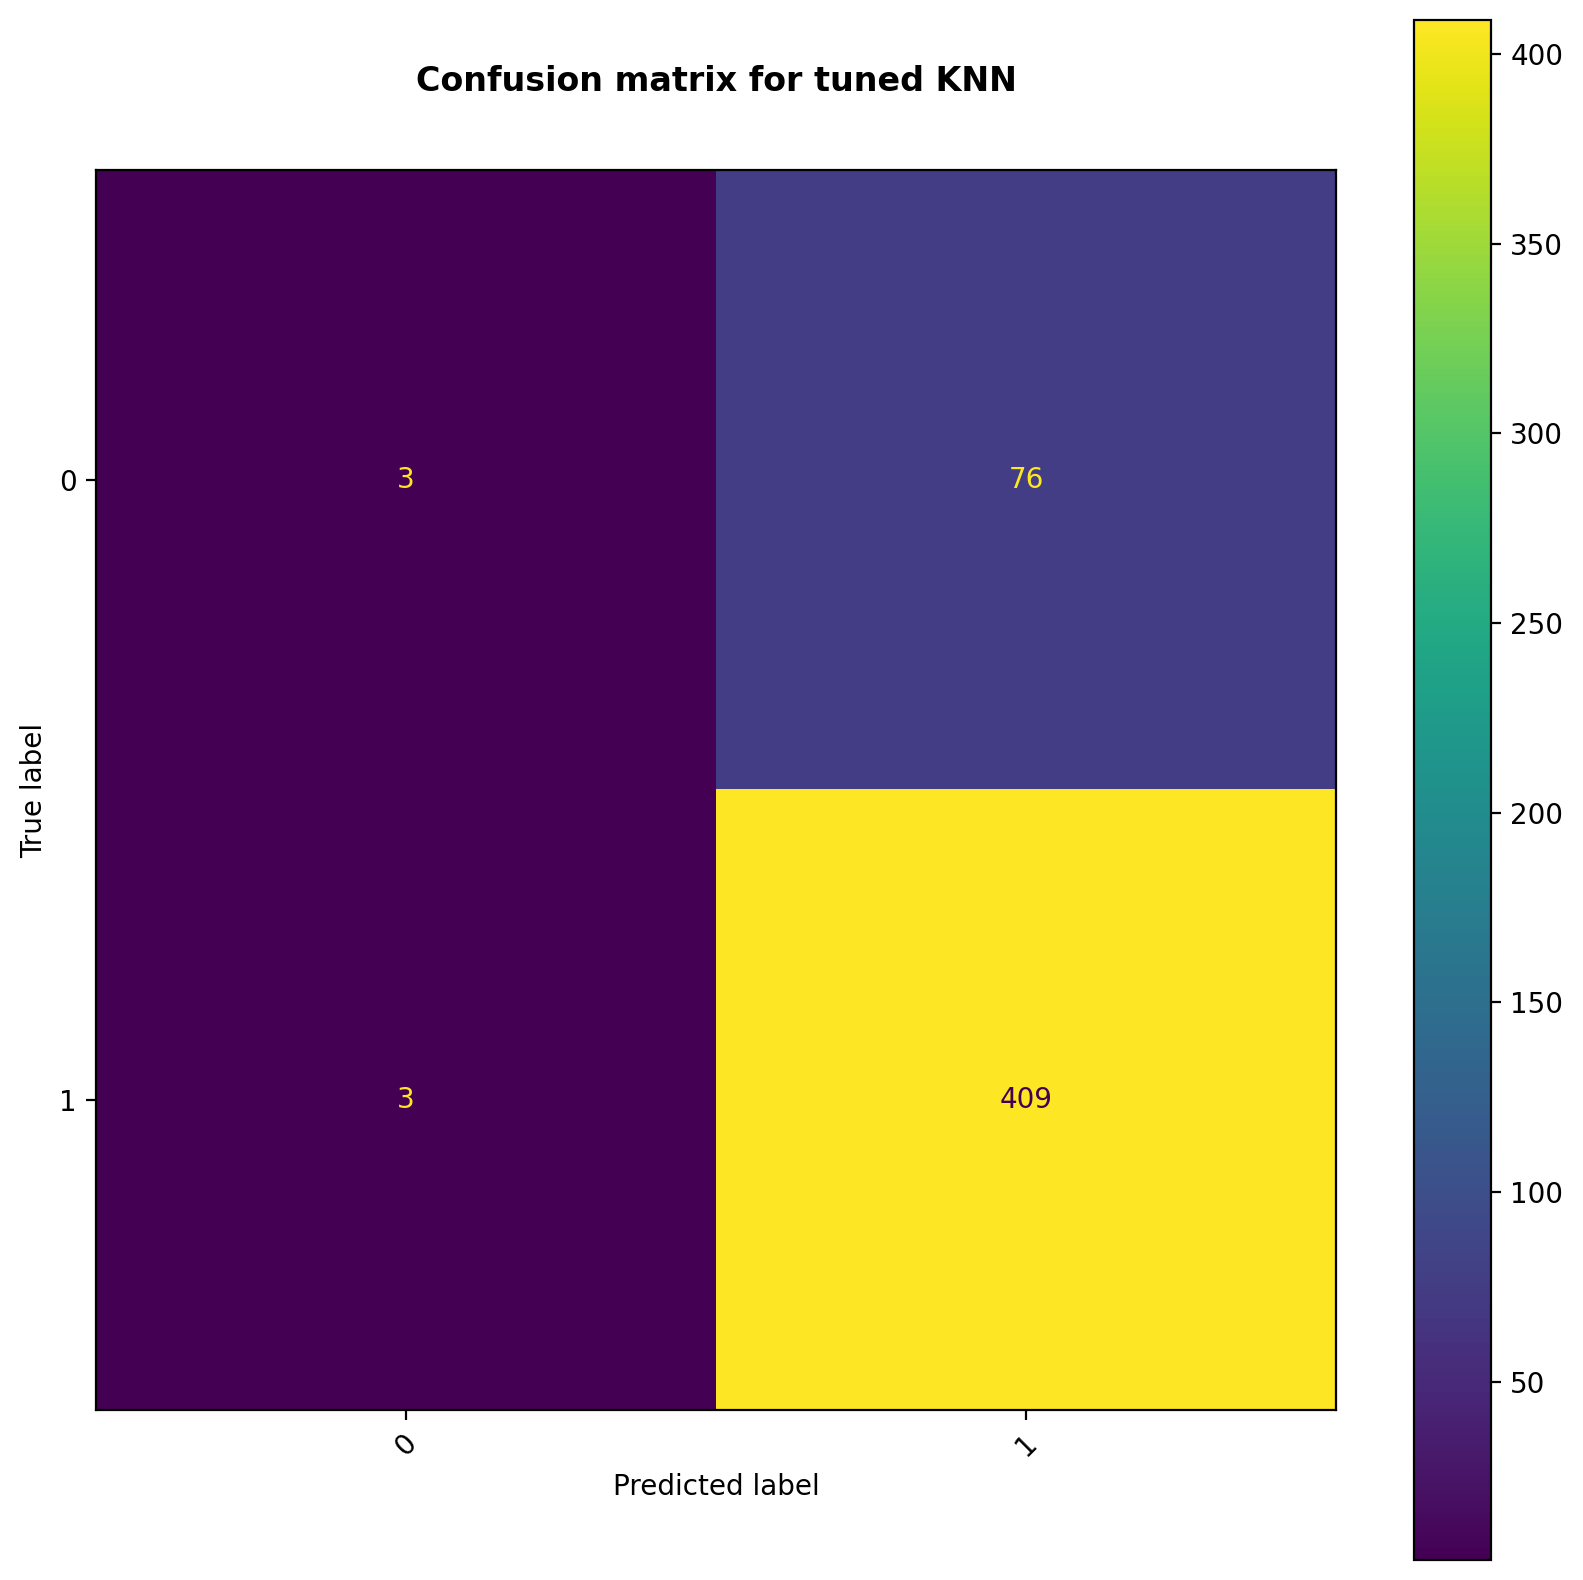

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 10})
print('                          -------------------------\n','\033[1m'+'\033[96m'+'                         Confusion Matrix for KNN\n'+'\033[0m','                         -------------------------')

CM = confusion_matrix(fl_test_label, KNN_pred, labels=clf_KNN.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=clf_KNN.classes_)
disp.plot(xticks_rotation=45)
plt.title('Confusion matrix for tuned KNN',fontweight='bold', y =1.05)
plt.grid(False)
plt.show()

## Parameter tuning for SVM using all feature vectors

In [72]:
from sklearn.svm import SVC

# C = [0.10, 0.1, 10, 25]
kernel = ['linear', 'poly', 'rbf']
gamma = [1e-1, 1e-2]


# #Convert to dictionary
hyperparameters = dict(kernel = kernel, gamma = gamma)

# #Create new KNN object
SVC = SVC()

# #Use GridSearch
clf = GridSearchCV(SVC, hyperparameters, cv = 5)

# #Fit the model
best_model_SVC = clf.fit(fl_train,fl_train_label.values.ravel())


In [ ]:
#Print The value of best Hyperparameters


print('Best C:', best_model_SVC.best_estimator_.get_params()['C'])
print('Best kernel:', best_model_SVC.best_estimator_.get_params()['kernel'])
print('Best gamma:', best_model_SVC.best_estimator_.get_params()['gamma'])



Best_C = best_model_SVC.best_estimator_.get_params()['C']
Best_kernel = best_model_SVC.best_estimator_.get_params()['kernel']
Best_gamma = best_model_SVC.best_estimator_.get_params()['gamma']

 ------------------------------
 Classification Report for SVM
 ------------------------------
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        79
           1     0.8391    1.0000    0.9125       412

    accuracy                         0.8391       491
   macro avg     0.4196    0.5000    0.4563       491
weighted avg     0.7041    0.8391    0.7657       491

SVM Classifier accuracy: 83.91038696537679%


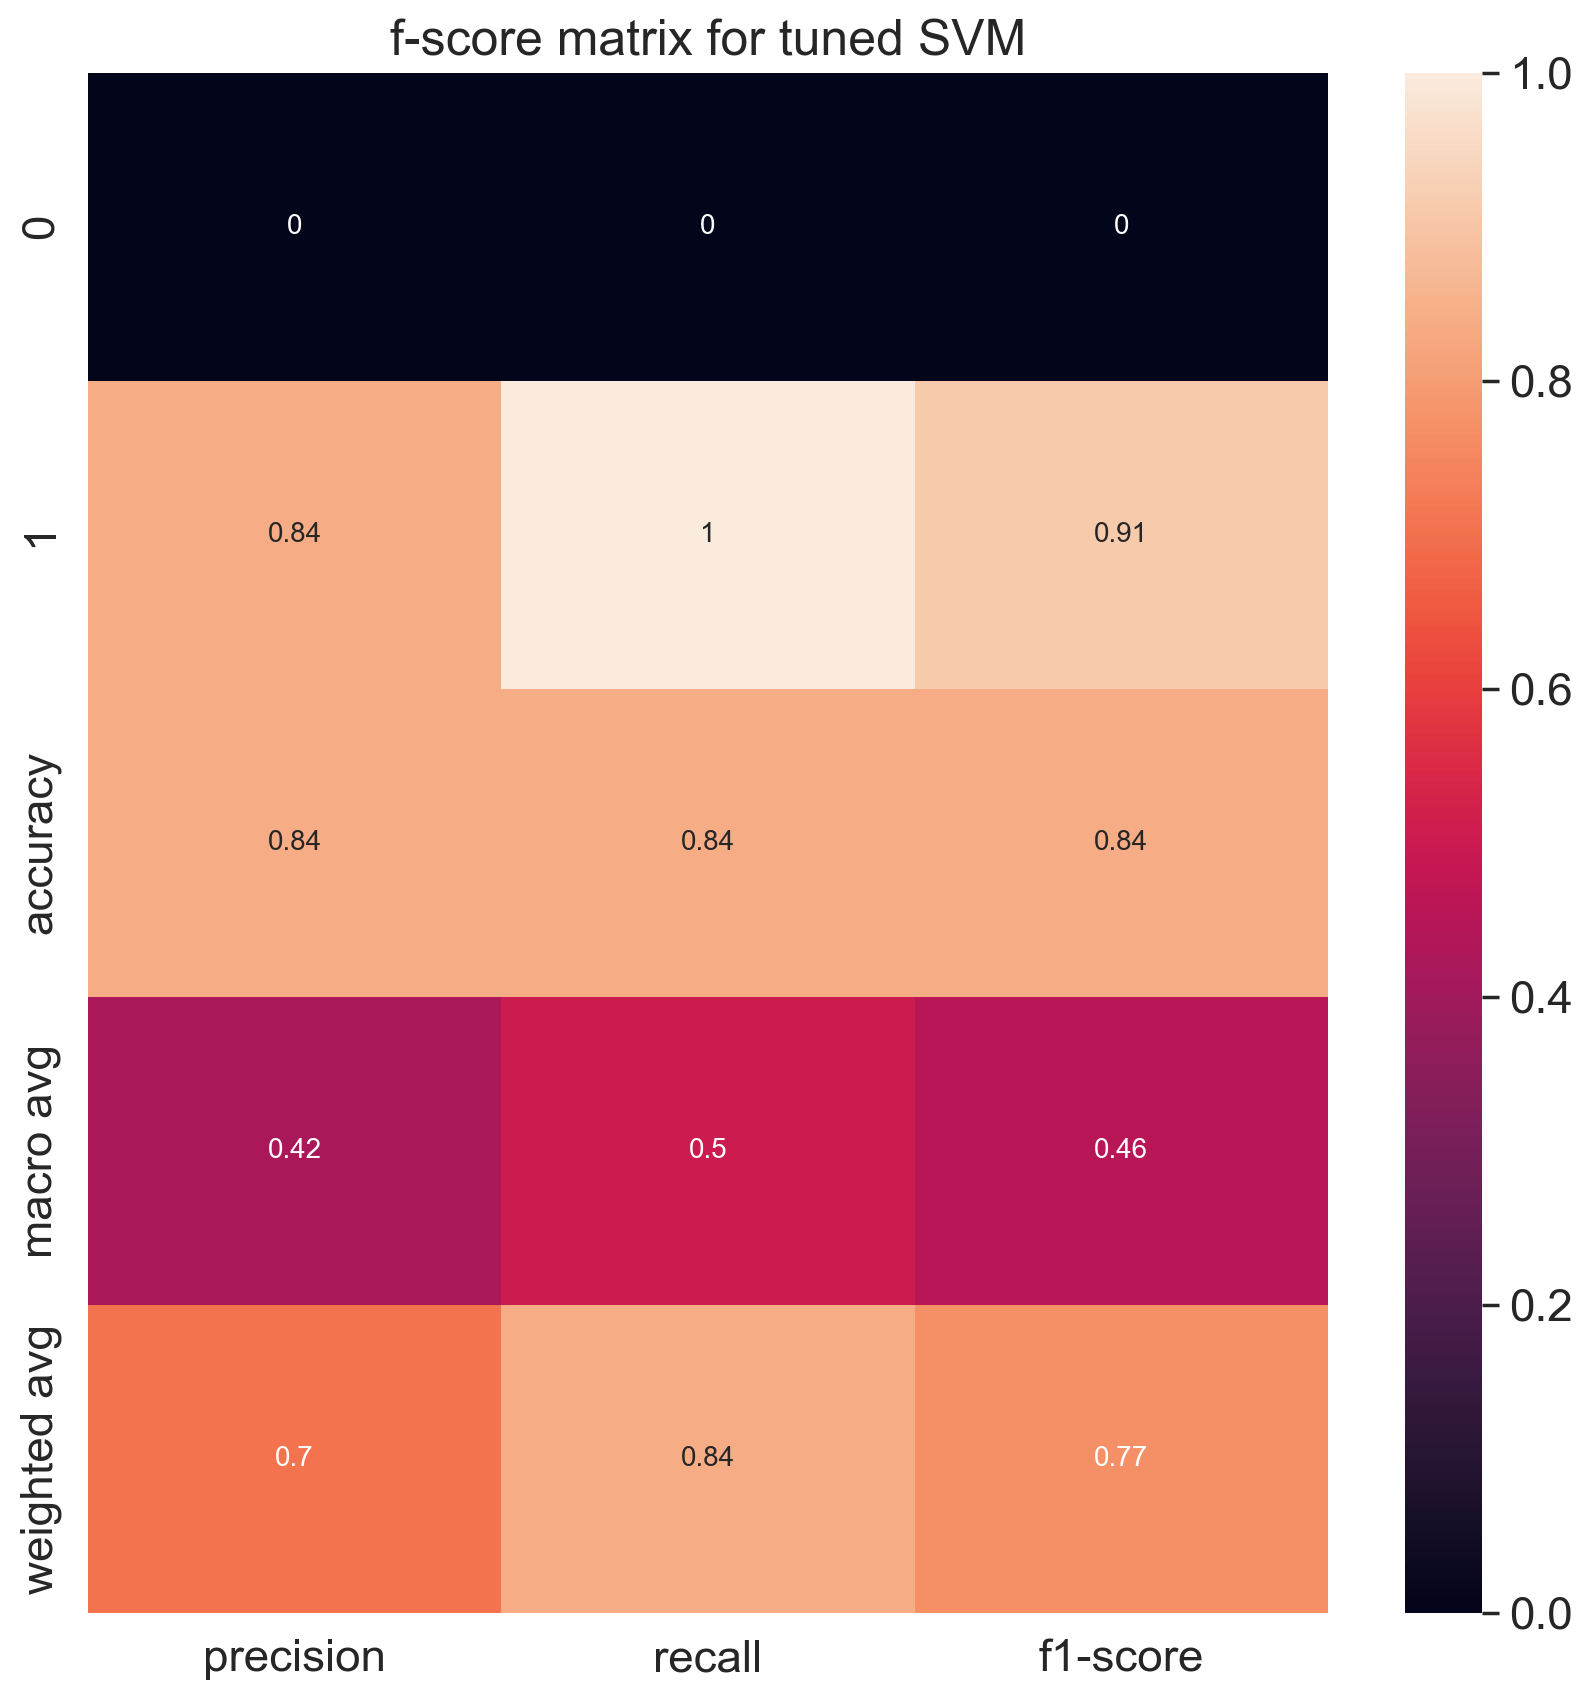

In [77]:
from sklearn.svm import SVC
SVM = SVC(kernel = 'rbf', gamma = 0.001)
clf_SVM = SVM.fit(fl_train, fl_train_label.values.ravel())
SVM_pred = SVM.predict(fl_test)

tbl = np.reshape(SVM_pred, (len(SVM_pred),1))

                
dfSVM = pd.DataFrame(tbl)

y_true = fl_test_label
y_pred = dfSVM
print(' ------------------------------\n','\033[1m'+'\033[95m'+'Classification Report for SVM\n'+'\033[0m','------------------------------')
print(classification_report(y_true, y_pred, digits=4))
re = classification_report(y_true, y_pred,digits=4, output_dict=True)
sns.heatmap(pd.DataFrame(re).iloc[:-1, :].T, annot=True)
plt.title ('f-score matrix for tuned SVM')
accuracy_scores_SVM = accuracy_score(y_true, y_pred)*100
print('\033[1m'+'\033[92m'+'SVM Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores_SVM))

                          -------------------------
                          Confusion Matrix for SVM
                          -------------------------


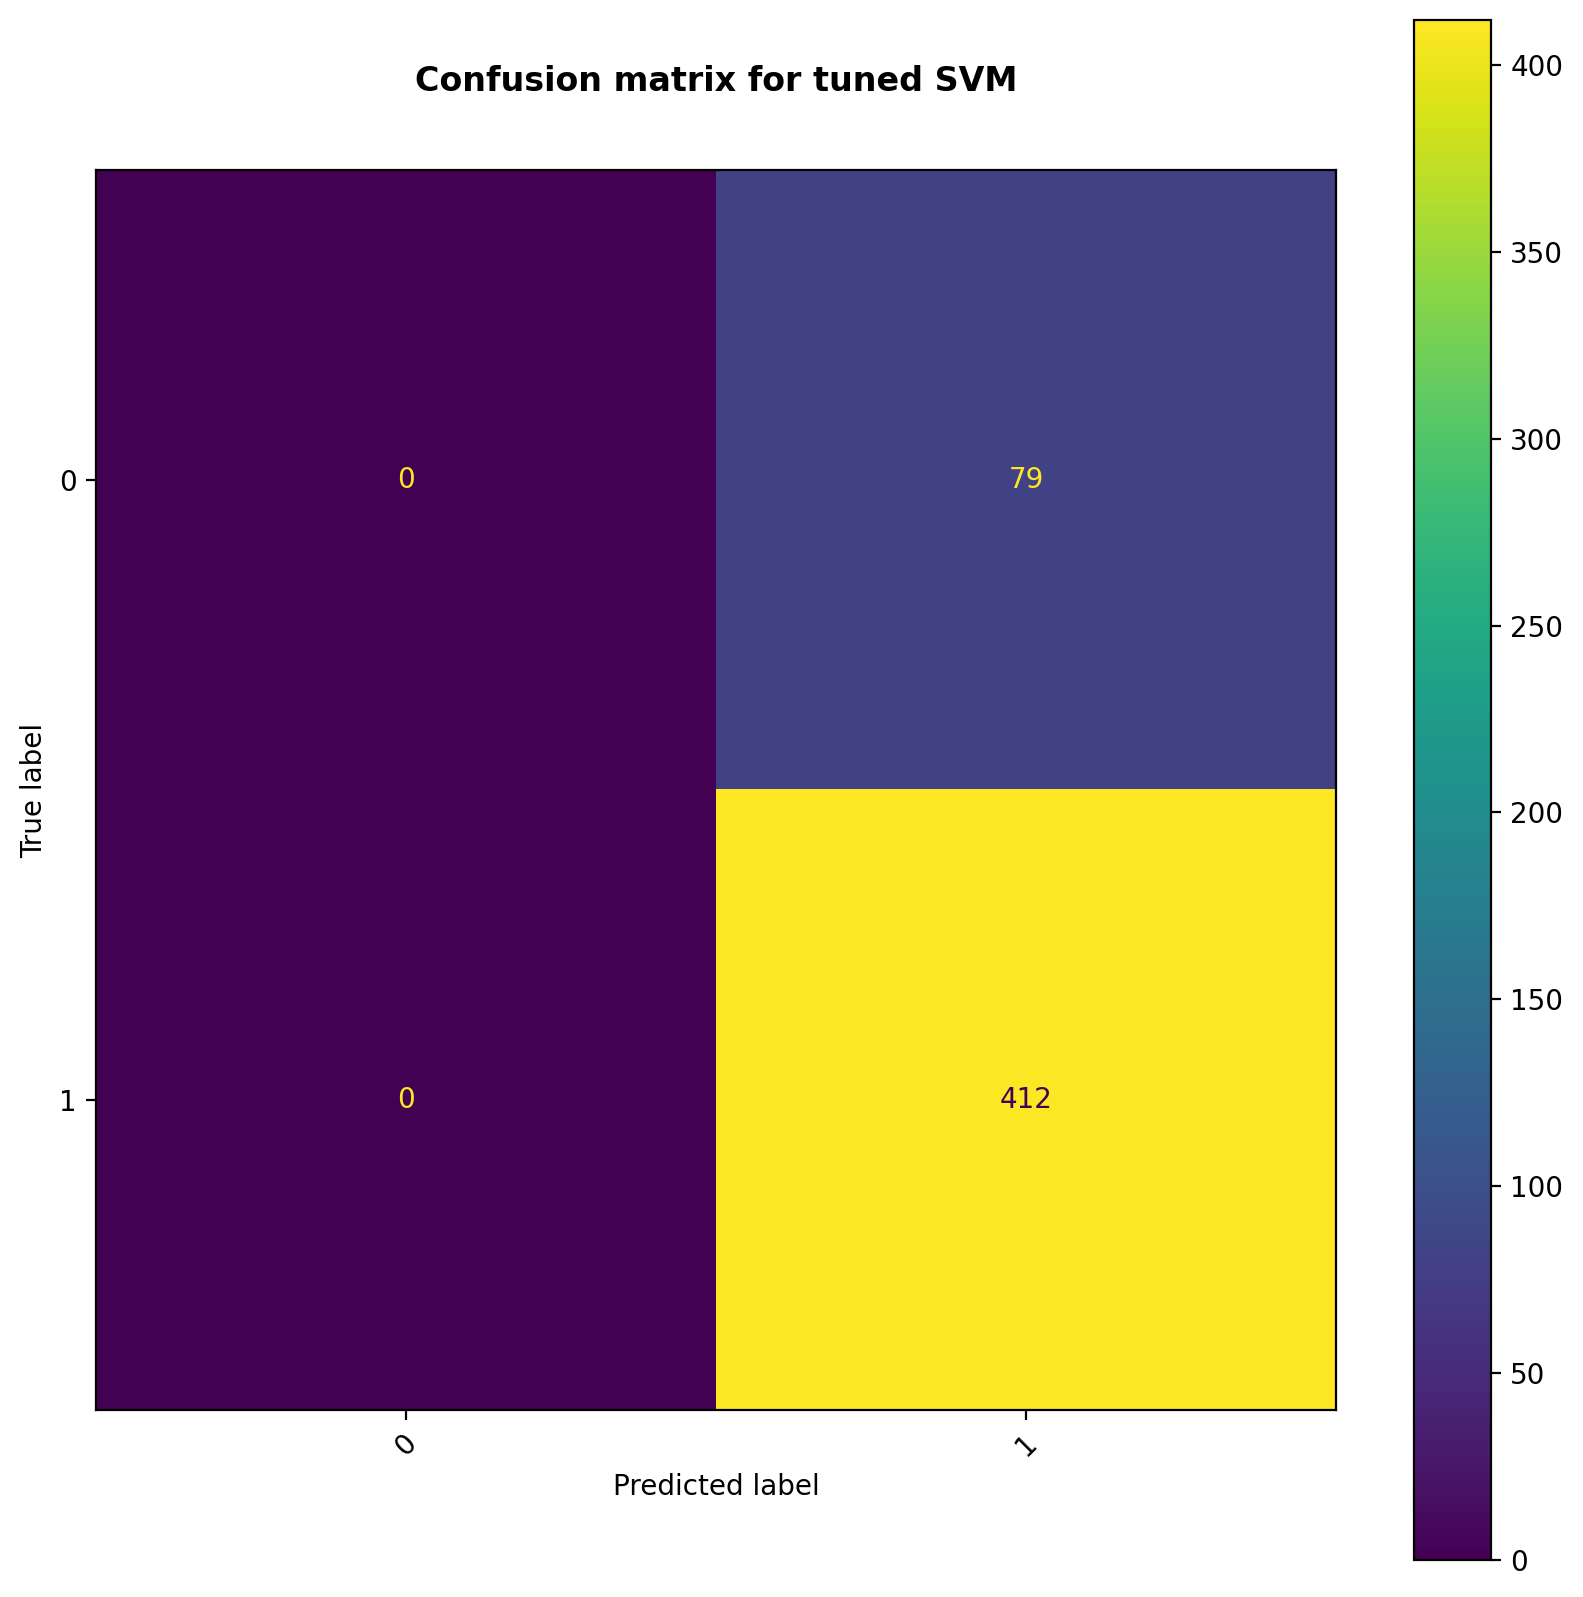

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 10})
print('                          -------------------------\n','\033[1m'+'\033[96m'+'                         Confusion Matrix for SVM\n'+'\033[0m','                         -------------------------')

CM = confusion_matrix(fl_test_label, SVM_pred, labels=clf_SVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=clf_SVM.classes_)
disp.plot(xticks_rotation=45)
plt.title('Confusion matrix for tuned SVM',fontweight='bold', y =1.05)
plt.grid(False)
plt.show()

## Parameter tuning for RandomForest Classifier using all feature vectors

In [78]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [100, 300]
max_depth = [5, 8, 15]
min_samples_split = [ 5, 10, 15]
min_samples_leaf = [1, 2] 


# #Convert to dictionary
hyperparameters = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)

# #Create new RNDMFRST object
RND = RandomForestClassifier()

# #Use GridSearch
clf = GridSearchCV(RND, hyperparameters, cv = 5)

# #Fit the model
best_model_SVC = clf.fit(fl_train,fl_train_label.values.ravel())


In [80]:
#Print The value of best Hyperparameters


print('Best n_estimators:', best_model_SVC.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model_SVC.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model_SVC.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model_SVC.best_estimator_.get_params()['min_samples_leaf'])



Best_n_estimators = best_model_SVC.best_estimator_.get_params()['n_estimators']
Best_max_depth = best_model_SVC.best_estimator_.get_params()['max_depth']
Best_min_samples_split = best_model_SVC.best_estimator_.get_params()['min_samples_split']
Best_min_samples_leaf = best_model_SVC.best_estimator_.get_params()['min_samples_leaf']

Best n_estimators: 100
Best max_depth: 5
Best min_samples_split: 5
Best min_samples_leaf: 1


 ------------------------------
 Classification Report for RandomForest
 ------------------------------
              precision    recall  f1-score   support

           0     1.0000    0.0127    0.0250        79
           1     0.8408    1.0000    0.9135       412

    accuracy                         0.8411       491
   macro avg     0.9204    0.5063    0.4693       491
weighted avg     0.8664    0.8411    0.7706       491

RandomForest Classifier accuracy: 83.91038696537679%


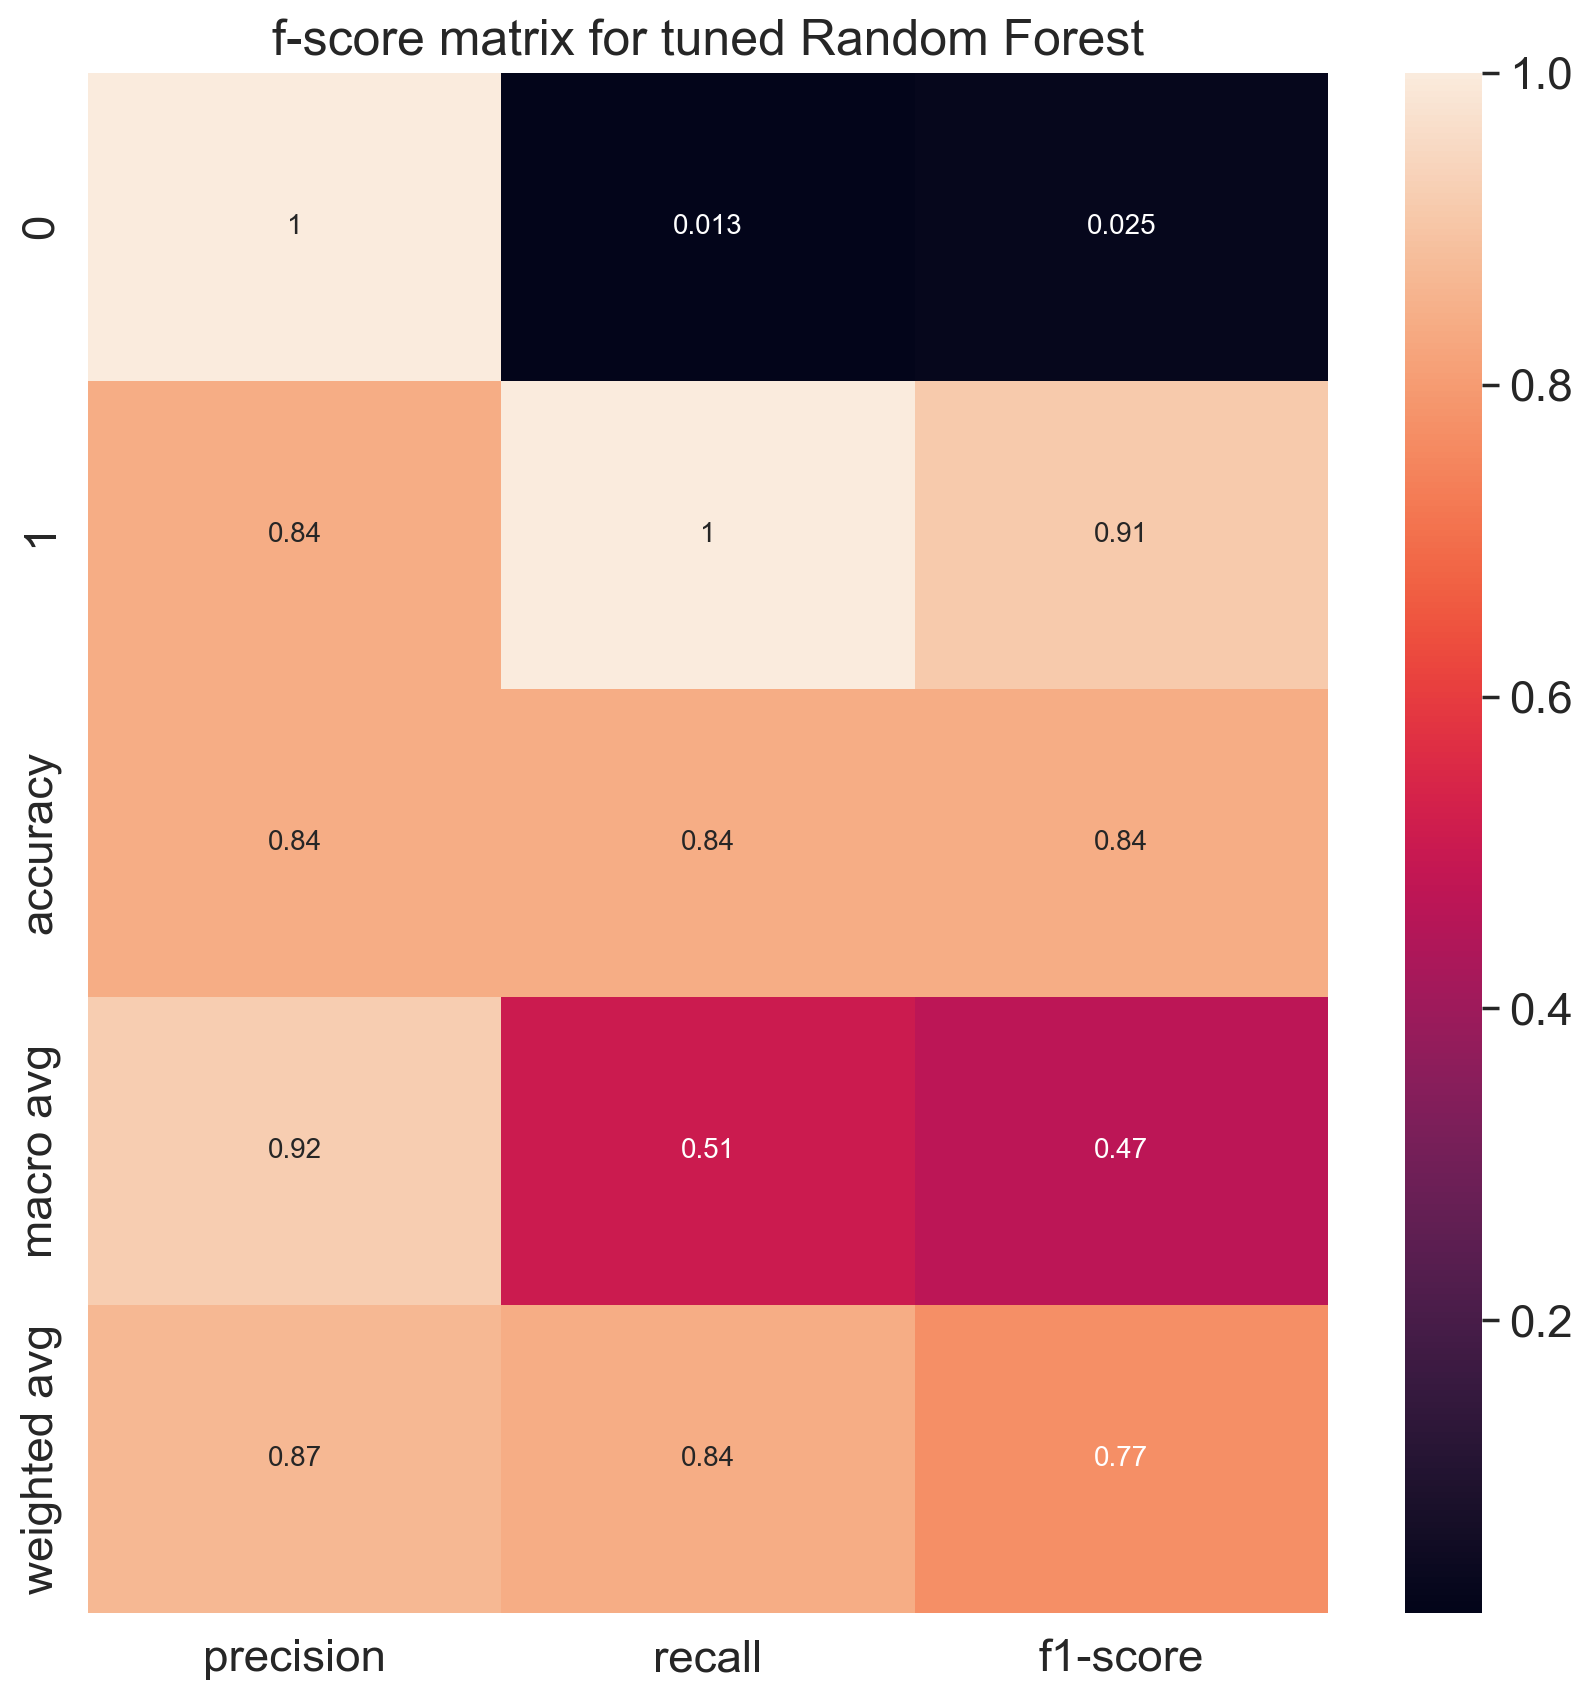

In [78]:
RND = RandomForestClassifier()
clf_SVM = RND.fit(fl_train, fl_train_label.values.ravel())
SVM_pred = RND.predict(fl_test)

tbl = np.reshape(SVM_pred, (len(SVM_pred),1))

                
dfSVM = pd.DataFrame(tbl)

y_true = fl_test_label
y_pred = dfSVM
print(' ------------------------------\n','\033[1m'+'\033[95m'+'Classification Report for RandomForest\n'+'\033[0m','------------------------------')
print(classification_report(y_true, y_pred, digits=4))
re = classification_report(y_true, y_pred,digits=4, output_dict=True)
sns.heatmap(pd.DataFrame(re).iloc[:-1, :].T, annot=True)
plt.title ('f-score matrix for tuned Random Forest')
accuracy_scores_RND = accuracy_score(y_true, y_pred)*100
print('\033[1m'+'\033[92m'+'RandomForest Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores_SVM))

                          -------------------------
                          Confusion Matrix for Random Forest
                          -------------------------


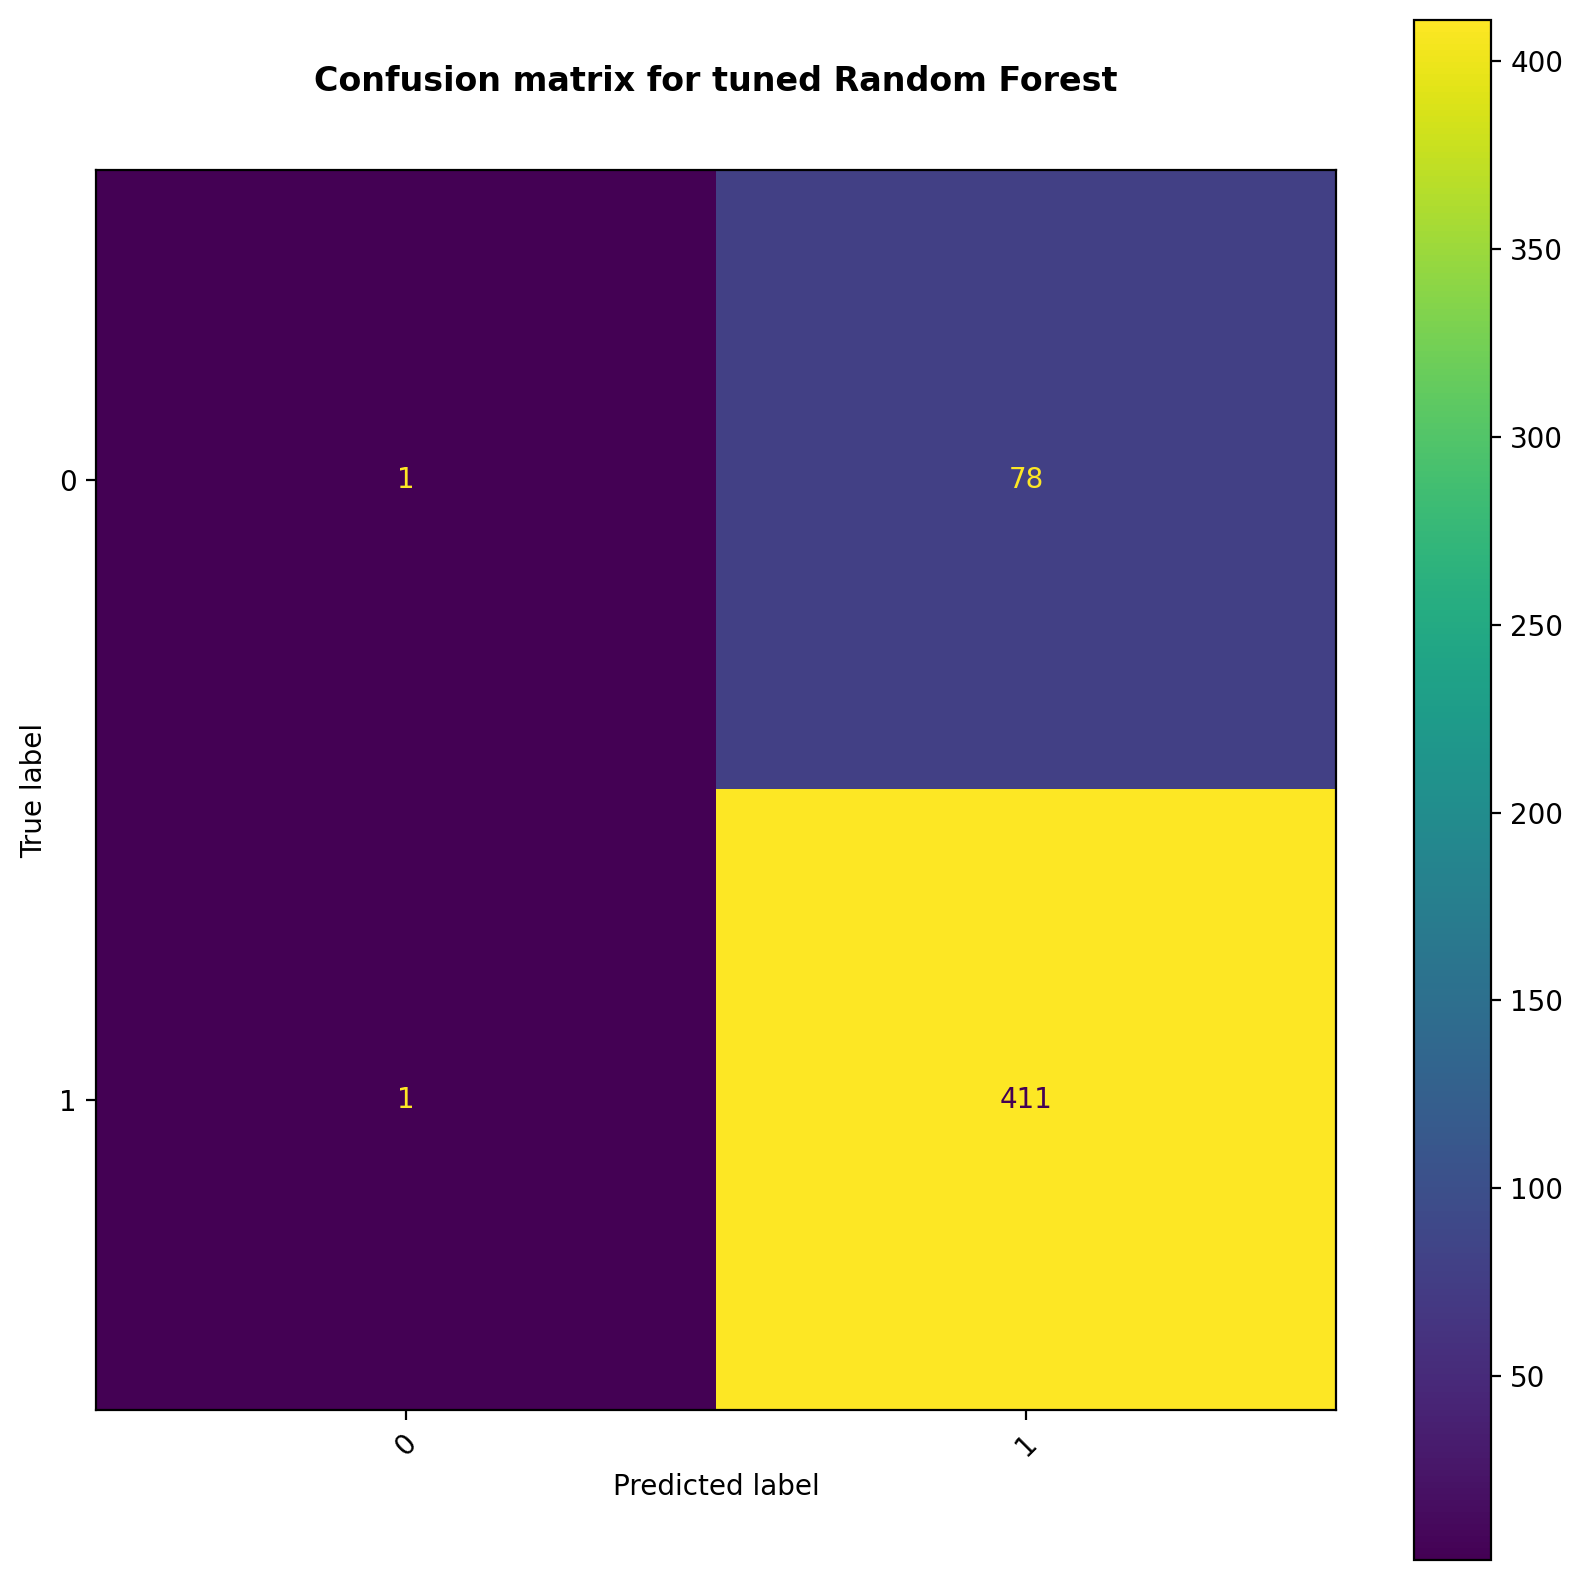

In [91]:
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 10})
print('                          -------------------------\n','\033[1m'+'\033[96m'+'                         Confusion Matrix for Random Forest\n'+'\033[0m','                         -------------------------')

CM = confusion_matrix(fl_test_label, SVM_pred, labels=clf_SVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=clf_SVM.classes_)
disp.plot(xticks_rotation=45)
plt.title('Confusion matrix for tuned Random Forest',fontweight='bold', y =1.05)
plt.grid(False)
plt.show()

## Parameter tuning for LogisticRegression using all feature vectors

In [85]:
from sklearn.linear_model import LogisticRegression

C =  [0.10, 0.1, 10, 25]
# penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['lbfgs','newton-cg','liblinear']
max_iter = [1000, 5000, 10000]


# #Convert to dictionary
hyperparameters = dict(C = C, solver = solver, max_iter = max_iter)

# #Create new KNN object
LOGR = LogisticRegression()

# #Use GridSearch
clf = GridSearchCV(LOGR, hyperparameters, cv = 10)

# #Fit the model
best_model_LOG = clf.fit(fl_train,fl_train_label.values.ravel())

In [84]:
#Print The value of best Hyperparameters


print('Best C:', best_model_LOG.best_estimator_.get_params()['C'])
print('Best penalty:', best_model_LOG.best_estimator_.get_params()['penalty'])
print('Best solver:', best_model_LOG.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model_LOG.best_estimator_.get_params()['max_iter'])


Best_C_LOG = best_model_LOG.best_estimator_.get_params()['C']
Best_penalty = best_model_LOG.best_estimator_.get_params()['penalty']
Best_solver = best_model_LOG.best_estimator_.get_params()['solver']
Best_max_iter = best_model_LOG.best_estimator_.get_params()['max_iter']

Best C: 0.1
Best penalty: l2
Best solver: liblinear
Best max_iter: 1000


 ---------------------------------------------
 Classification Report for LogisticRegression
 ---------------------------------------------
              precision    recall  f1-score   support

           0     1.0000    0.0127    0.0250        79
           1     0.8408    1.0000    0.9135       412

    accuracy                         0.8411       491
   macro avg     0.9204    0.5063    0.4693       491
weighted avg     0.8664    0.8411    0.7706       491

LogisticRegression Classifier accuracy: 84.11405295315683%


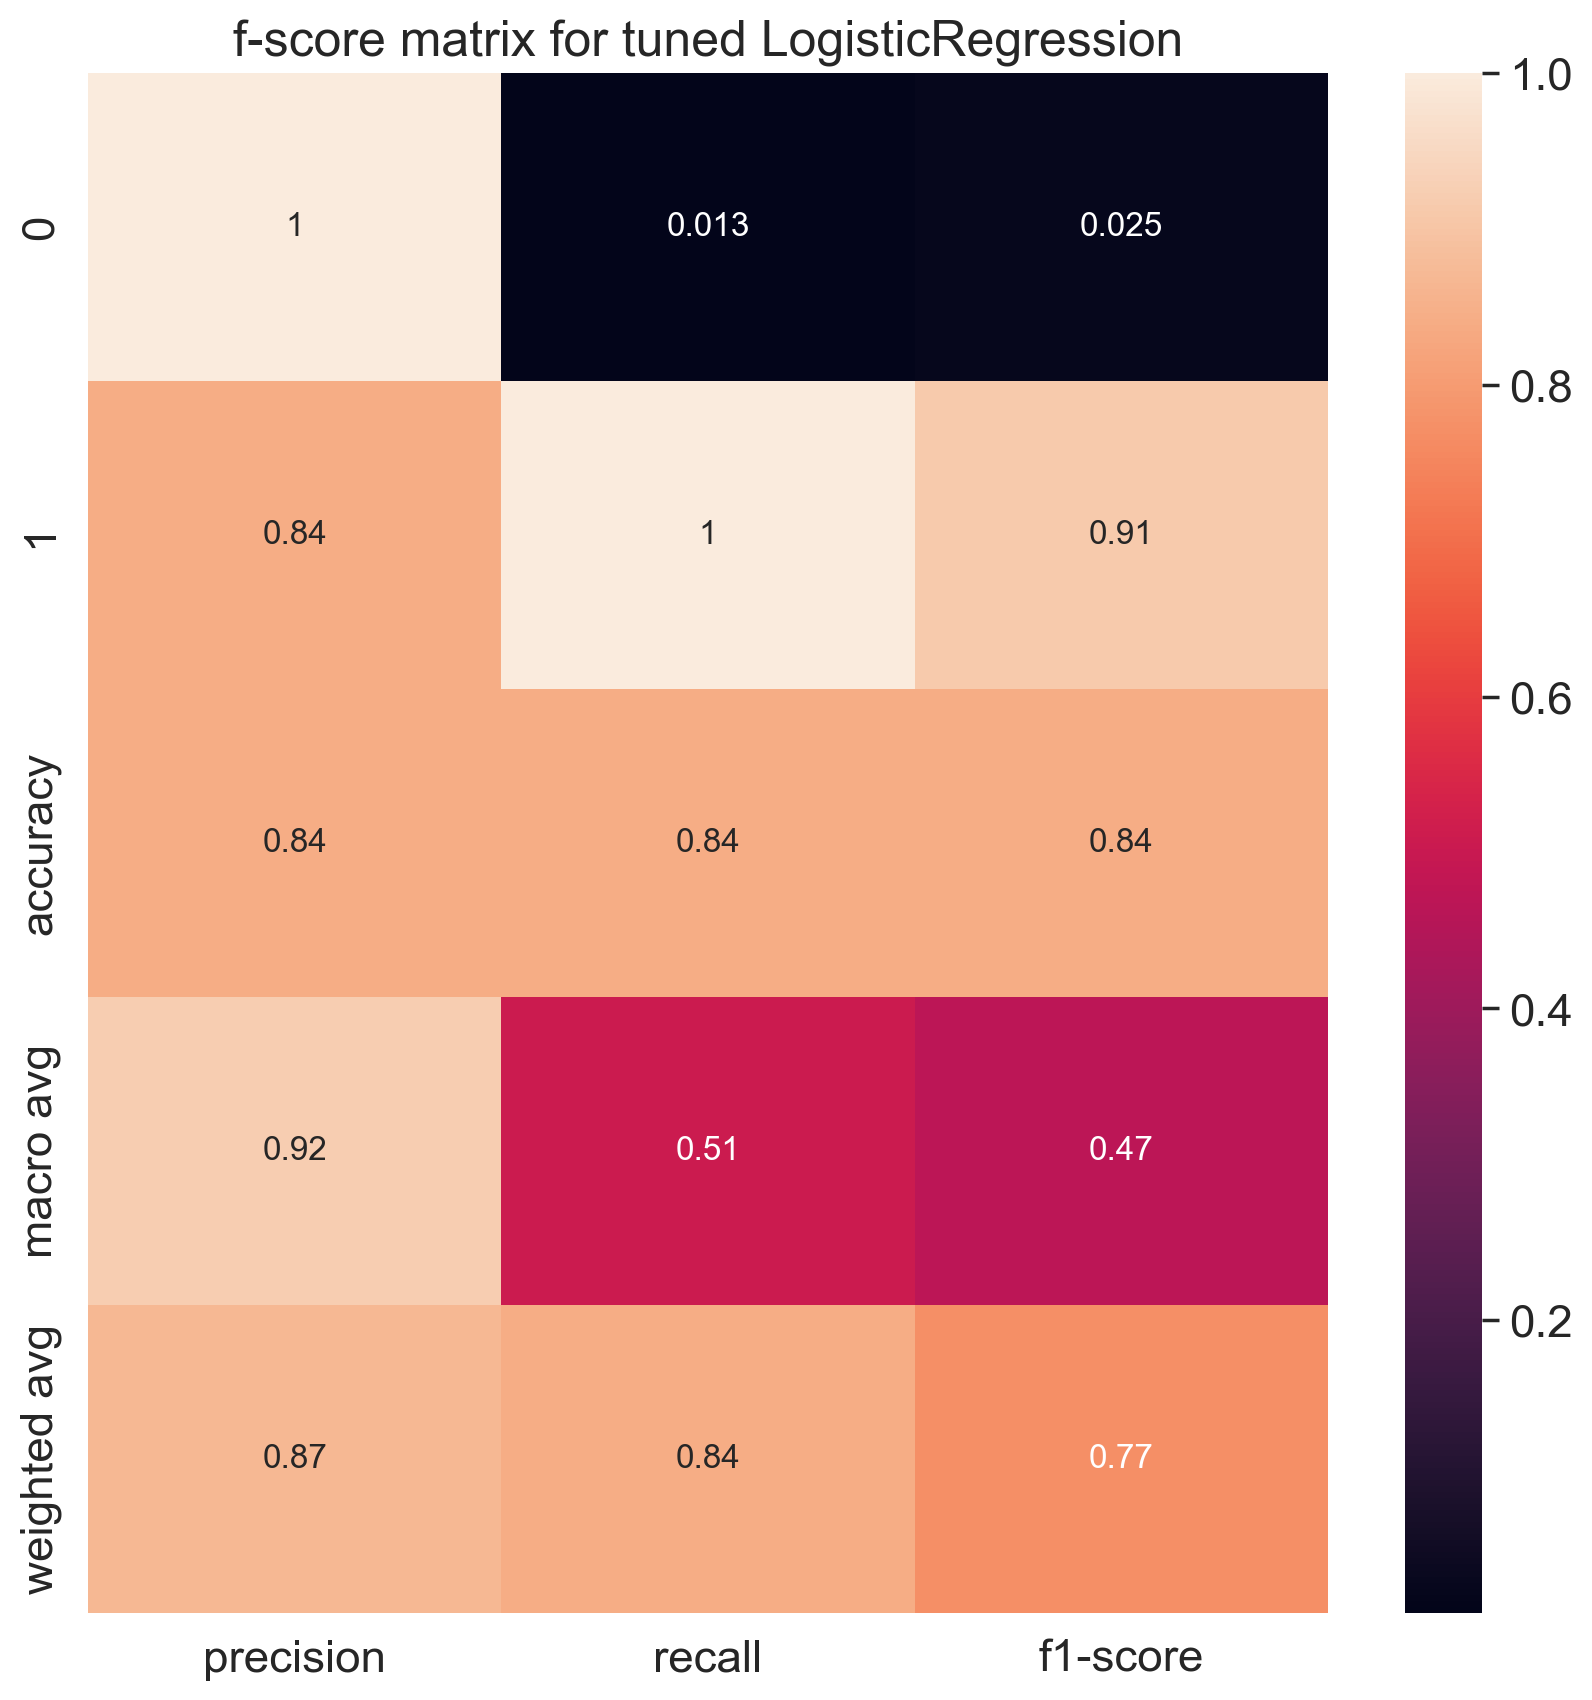

In [83]:

from sklearn.linear_model import LogisticRegression
LOGR = LogisticRegression(C = 0.01 ,penalty = 'l2', solver = 'liblinear', max_iter = 1000)
clf_LOGR = LOGR.fit(fl_train, fl_train_label.values.ravel())
LOGR_pred = LOGR.predict(fl_test)

tbl = np.reshape(LOGR_pred, (len(LOGR_pred),1))

                
dfLOGR = pd.DataFrame(tbl)

y_true = fl_test_label
y_pred = dfLOGR
print(' ---------------------------------------------\n','\033[1m'+'\033[95m'+'Classification Report for LogisticRegression\n'+'\033[0m','---------------------------------------------')
print(classification_report(y_true, y_pred, digits=4))
re = classification_report(y_true, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(re).iloc[:-1, :].T, annot=True)
plt.title ('f-score matrix for tuned LogisticRegression')
accuracy_scores_LOGR = accuracy_score(y_true, y_pred)*100
print('\033[1m'+'\033[92m'+'LogisticRegression Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores_LOGR))

                          -------------------------
                          Confusion Matrix for LOG
                          -------------------------


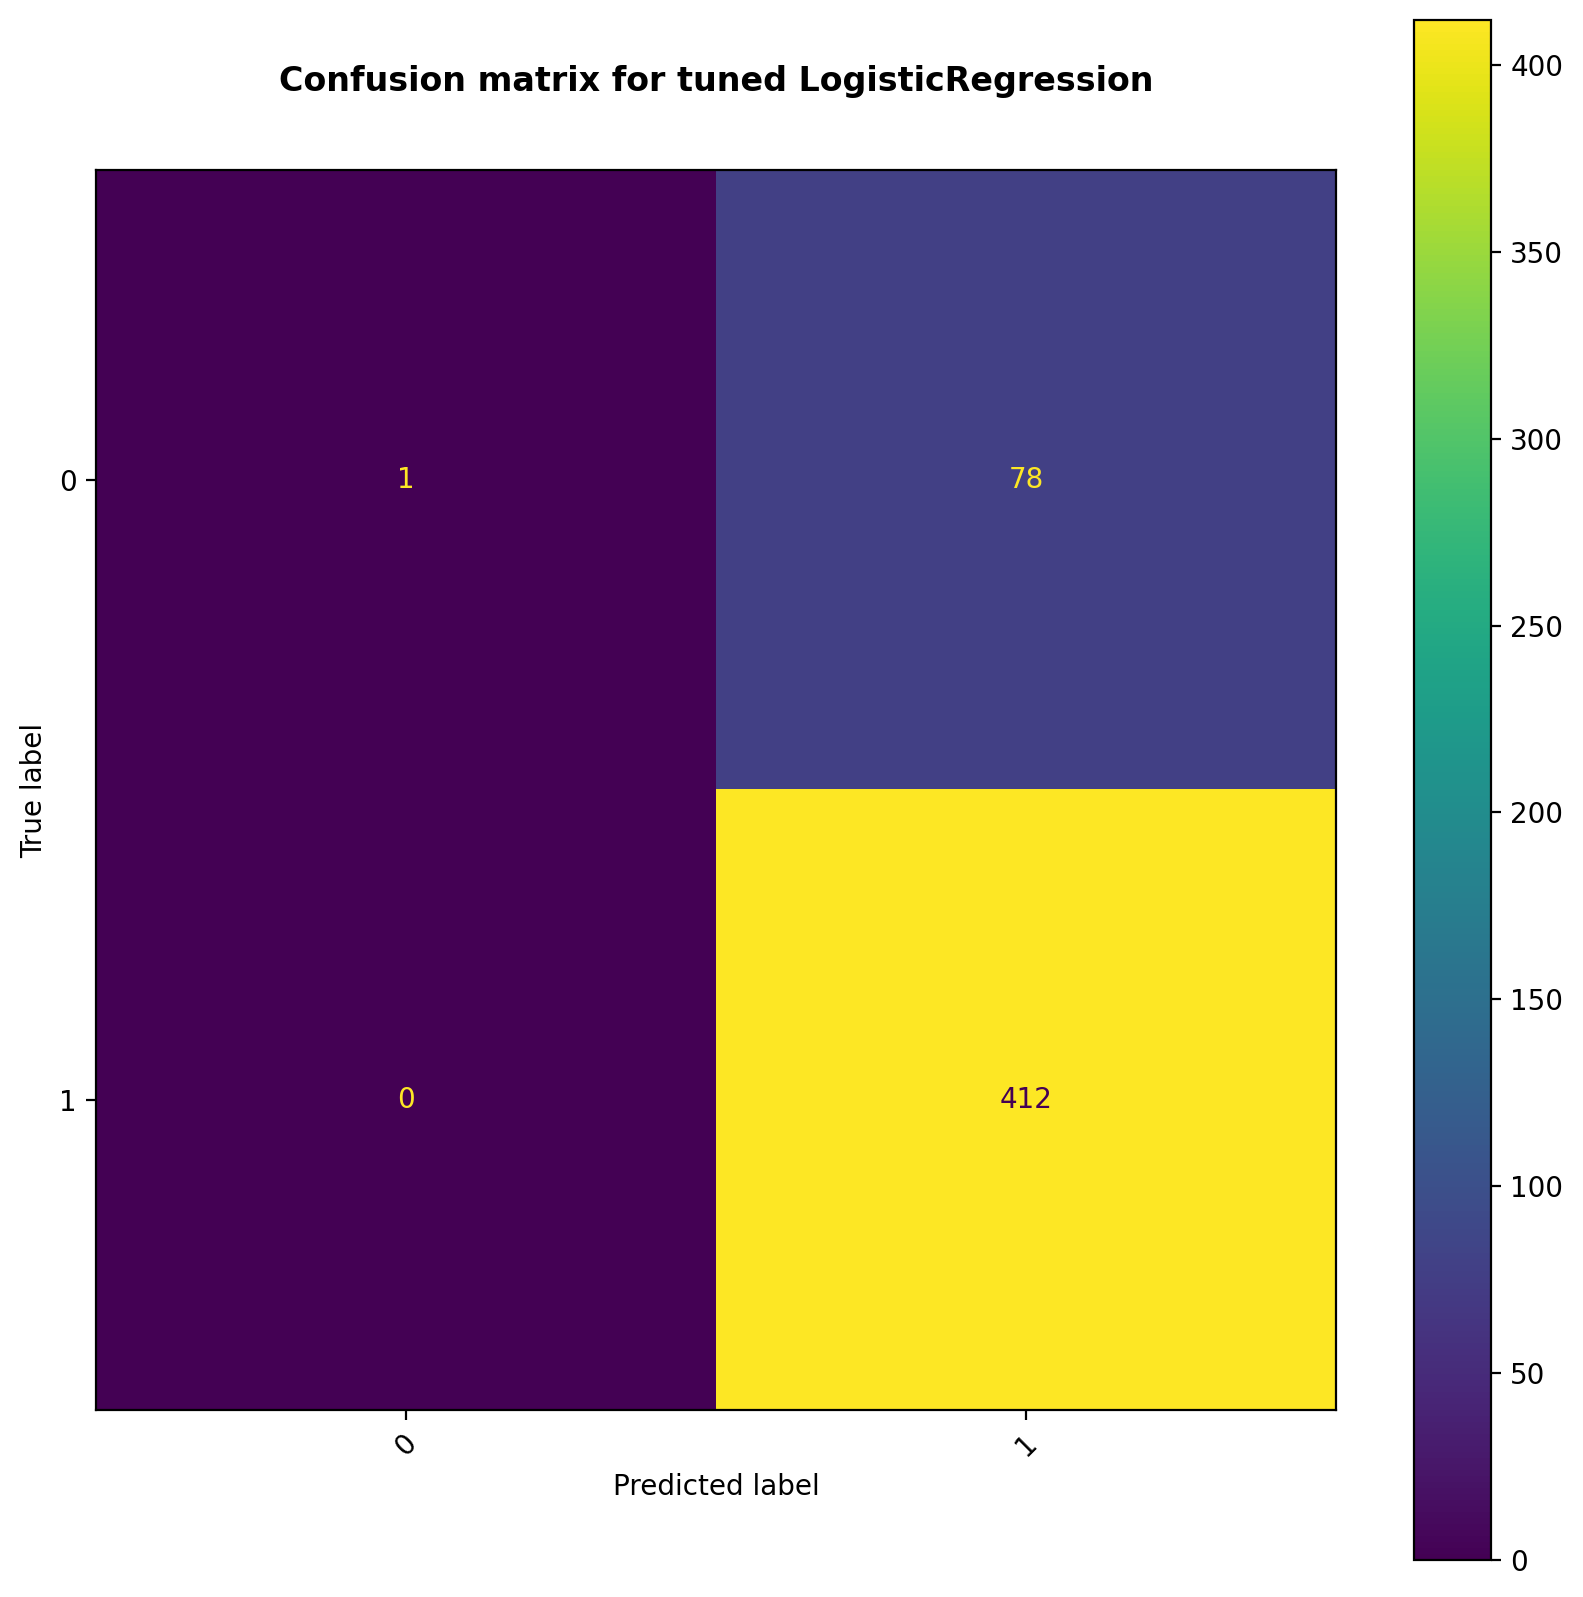

In [87]:
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 10})
print('                          -------------------------\n','\033[1m'+'\033[96m'+'                         Confusion Matrix for LOG\n'+'\033[0m','                         -------------------------')

CM = confusion_matrix(fl_test_label, LOGR_pred, labels=clf_LOGR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=clf_LOGR.classes_)
disp.plot(xticks_rotation=45)
plt.title('Confusion matrix for tuned LogisticRegression',fontweight='bold', y =1.05)
plt.grid(False)
plt.show()

# Comparing accuracy of the four tuned classifiers

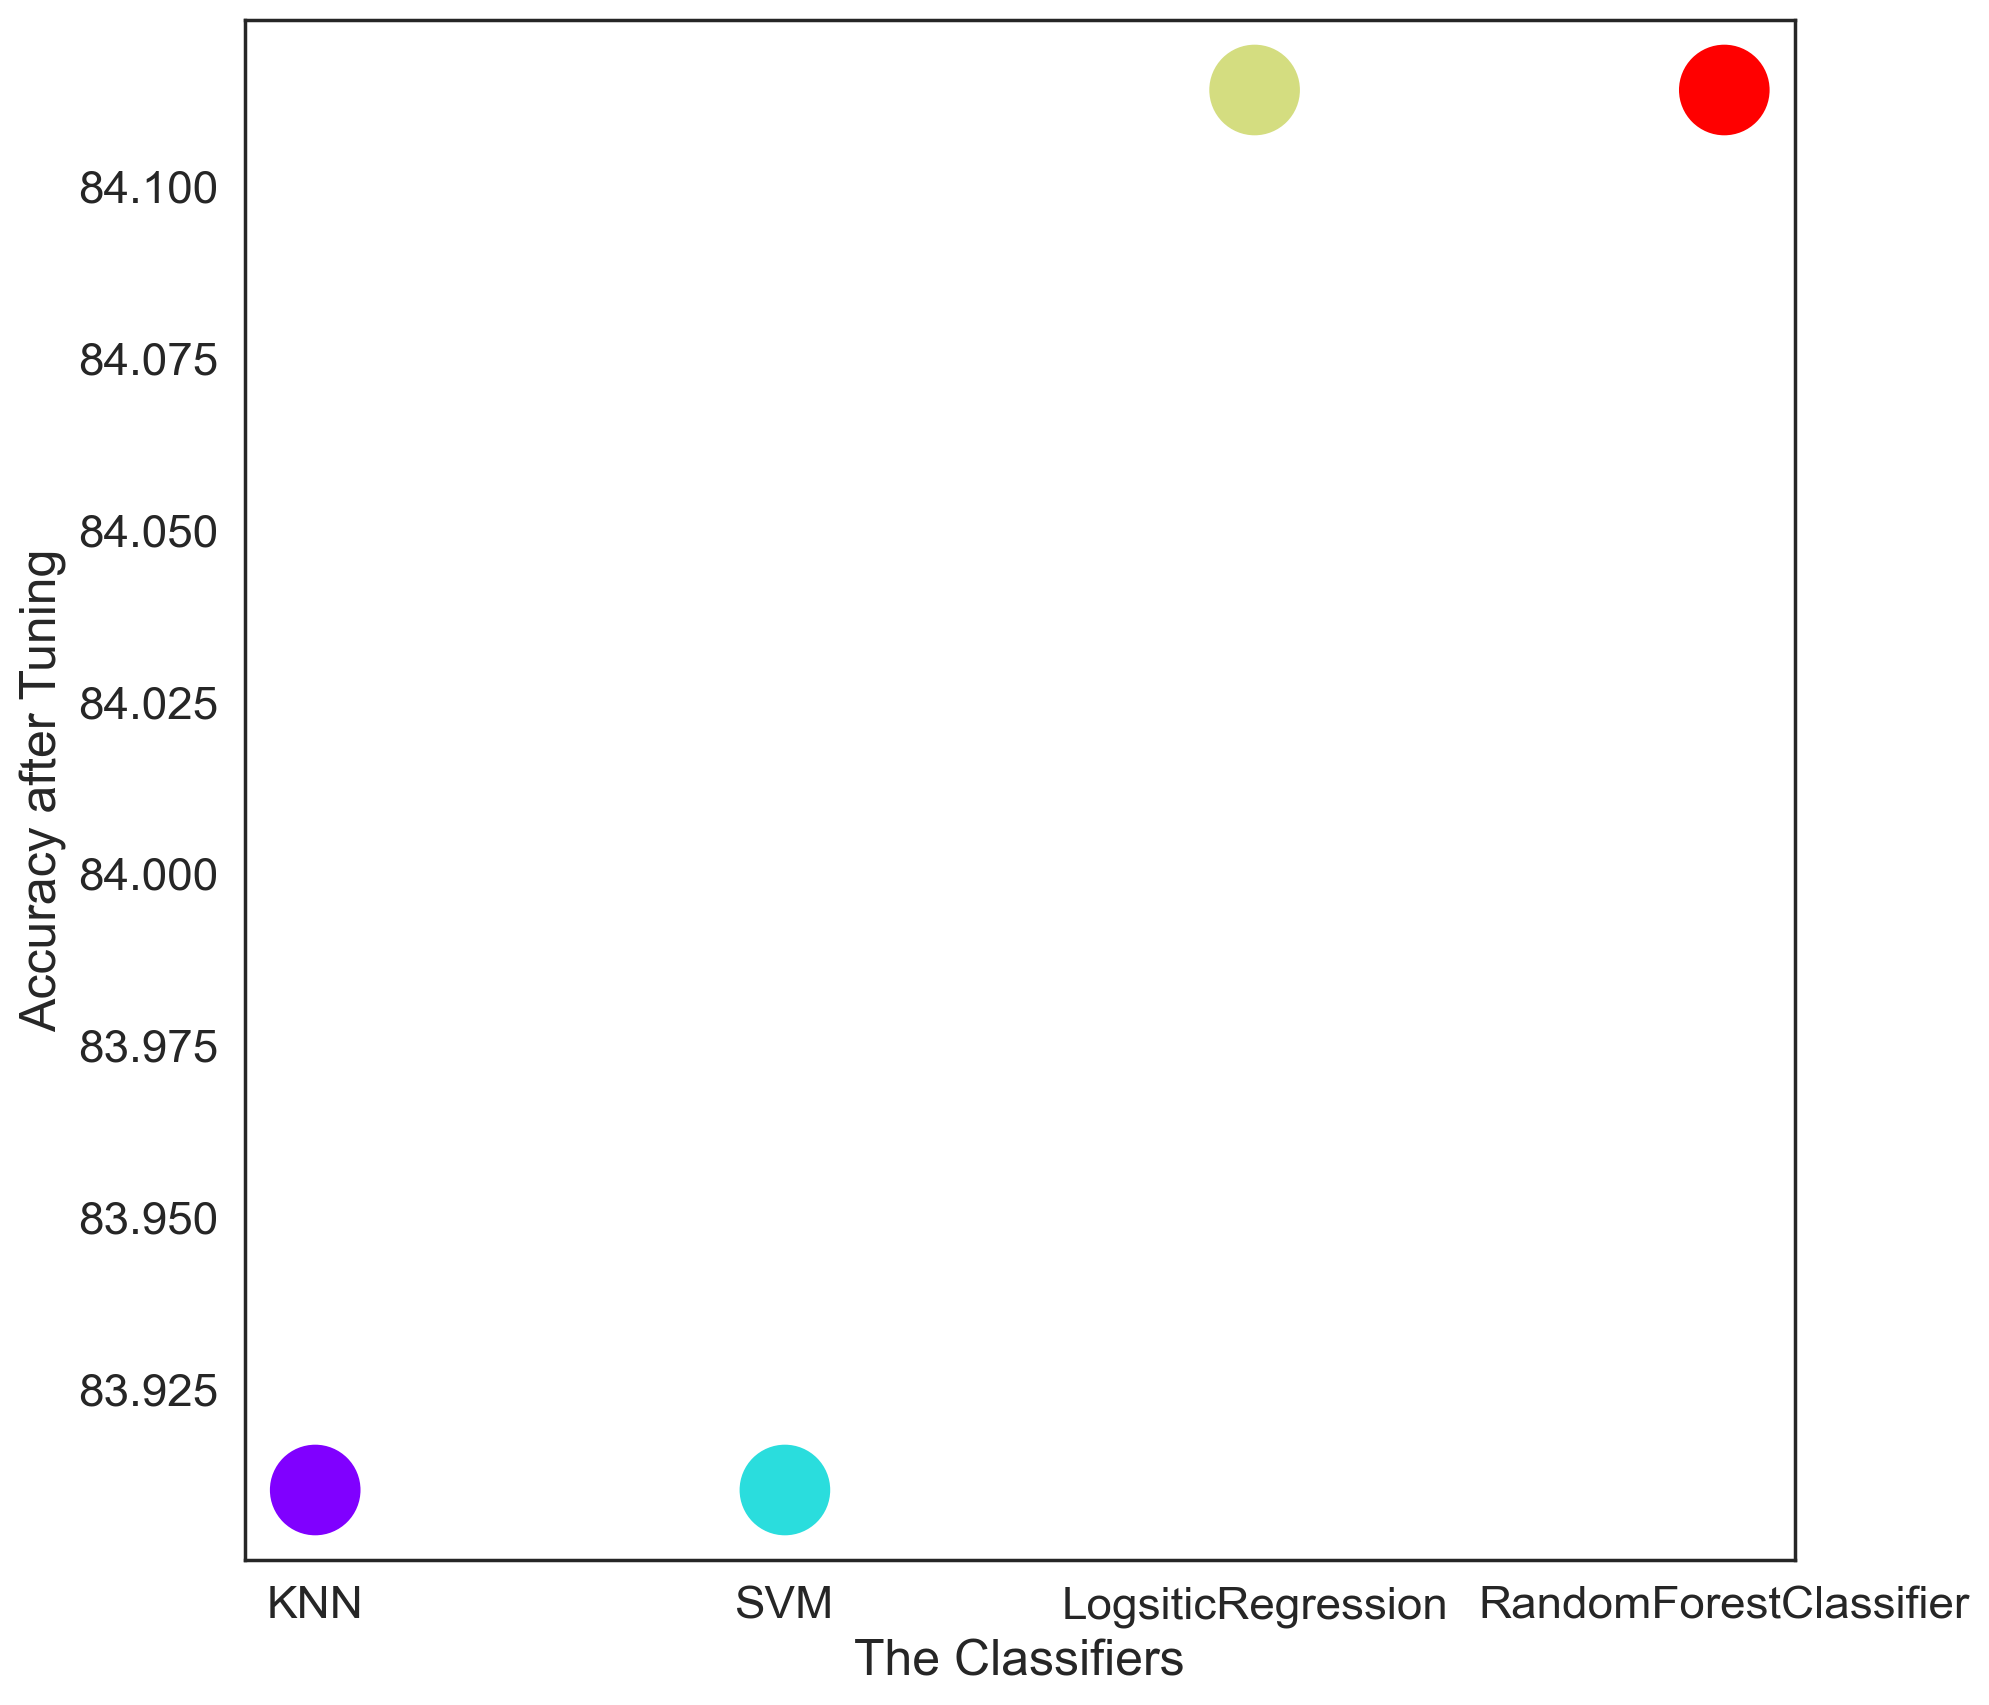

In [84]:

colors = cm.rainbow(np.linspace(0, 1, 4))
labels = ['KNN', 'SVM', 'LogsiticRegression', 'RandomForestClassifier']
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 12})
plt.scatter(labels,
        [accuracy_scores_KNN,accuracy_scores_SVM,accuracy_scores_LOGR,accuracy_scores_RND ],
        color = colors, s=1000)
plt.xlabel('The Classifiers')
plt.ylabel('Accuracy after Tuning');